# 0.0. Imports

In [302]:
import numpy      as np
import pandas     as pd
import boruta     as bt
import scikitplot as skplt
import pickle
import psycopg2   as pg

import seaborn    as sns

from matplotlib        import pyplot as plt
from matplotlib.artist import Artist as art

from sklearn                 import metrics         as mt
from sklearn                 import preprocessing   as pp
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from skopt                   import BayesSearchCV
from scipy.stats             import uniform, randint





## 0.1. Helper Function

In [341]:
def jupyter_settings():
    """
    Configurações para visualizações no Jupyter Notebook.

    Retorna:
    - Nenhum (apenas configura as opções de visualização)
    """

    from IPython.core.display import HTML
    %matplotlib inline
    
    plt.style.use('Solarize_Light2')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
   
    sns.set_palette('Set2')
    sns.set_style("darkgrid")
 
 
def conversion_plots(df, feature):
    """
    Plota um gráfico de barras para visualizar a conversão em relação a uma determinada feature.

    Argumentos:
    - df: o DataFrame contendo os dados
    - feature: a feature para a qual deseja-se visualizar a conversão

    Retorna:
    - Nenhum (apenas plota o gráfico)
    """
   
    # Define o estilo do seaborn para ocultar as linhas de grade nos eixos
    sns.set_style({'axes.grid': False})

    # Conta o número total de ocorrências para cada valor da feature
    total = df.groupby(feature)[['id']].count().reset_index()  
    
    # Conta o número de ocorrências onde a resposta é igual a 1 para cada valor da feature
    response1 = df[df['response'] == 1].groupby(feature)[['id']].count().reset_index().rename(columns={'id': 'interested'})  
    
    # Combina os dados de contagem total e interessados em uma tabela, preenchendo valores ausentes com zero
    total = total.merge(response1, how='left', on=feature).fillna(0)  

    # Calcula o percentual de interessados em relação ao total de ocorrências
    total['perc'] = (total.interested / total.id) * 100  
    

    # Plota um gráfico de barras com a feature no eixo x e o percentual no eixo y
    fig, ax = plt.subplots()  
    sns.barplot(data=total, x=feature, y='perc', ax=ax)  
    plt.ylim(0, 100)  
    ax.set_ylabel('Percentual')  
    ax.set_xlabel(feature)  
    
    # Formata o rótulo com o percentual formatado com duas casas decimais
    for i in total.index:
        label = f"{total.loc[i, 'perc']:.2f}%"  
        y = total.loc[i, 'perc']  
        plt.annotate(label, (i, y), ha='center', va='bottom', rotation=90)  # Adiciona rótulos aos pontos do gráfico
        
    plt.show()  



def line_plot(df, feature):
    """
    Plota um gráfico de linhas para visualizar a distribuição de uma feature em relação à resposta.

    Argumentos:
    - df: o DataFrame contendo os dados
    - feature: a feature a ser visualizada

    Retorna:
    - Nenhum (apenas plota o gráfico)
    """

    # Filtra os dados para cada resposta
    response_0 = df.loc[df['response'] == 0, feature]
    response_1 = df.loc[df['response'] == 1, feature]
    
    # Plota as curvas de densidade das idades para cada resposta
    sns.distplot(response_0, hist=False, kde=True, label='Response 0')
    sns.distplot(response_1, hist=False, kde=True, label='Response 1')
    
    # Configurações adicionais do gráfico
    plt.xlabel(feature)
    plt.ylabel('Interessed')
    plt.title(f'Distribuição de {feature} por Resposta')
    plt.legend()
    
    plt.show()


def calculate_metrics(models, x_train, y_train, x_val, y_val):
    """
    Calcula as métricas de desempenho para vários modelos.

    Argumentos:
    - models: uma lista de modelos a serem avaliados
    - x_train: os dados de treinamento
    - y_train: os rótulos de treinamento
    - x_val: os dados de validação
    - y_val: os rótulos de validação

    Retorna:
    - Uma lista de dicionários contendo os resultados das métricas de desempenho para cada modelo testado.
    """

    results = [] 
   
    for model in models:
        model_name = model.__class__.__name__  # Obtém o nome da classe do modelo
        model.fit(x_train, y_train)  # Treina o modelo com os dados de treinamento
        y_pred = model.predict(x_val)  # Faz previsões com o modelo nos dados de validação
        
        precision = mt.precision_score(y_val, y_pred)  # Calcula a métrica de precisão
        recall = mt.recall_score(y_val, y_pred)  # Calcula a métrica de recall
        f1 = mt.f1_score(y_val, y_pred)  # Calcula a métrica F1-score
        
        # Cria um dicionário com os resultados das métricas para o modelo atual
        result = {
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }  
        
        results.append(result)  
    
    return results  


def perform_cross_validation(models, x_train, y_train, scoring=['precision', 'recall', 'f1']):
    """
    Realiza a validação cruzada para avaliar o desempenho de diferentes modelos.

    Argumentos:
    - models: uma lista de modelos a serem avaliados
    - x_train: os dados de treinamento
    - y_train: os rótulos de treinamento
    - scoring: uma lista de métricas de avaliação. As métricas padrão são ['precision', 'recall', 'f1'].

    Retorna:
    - Uma lista de dicionários contendo os resultados das métricas para cada modelo testado.
    """

    # Lista para armazenar os resultados das métricas de validação cruzada
    results = []  
    
    for i, model in enumerate(models):
        # Realiza a validação cruzada com o modelo fornecido
        cv_results = ms.cross_validate(model, x_train, y_train, scoring=scoring, cv=5) 
        # Obtém o nome da classe do modelo 
        model_name = model.__class__.__name__  
        
        # Calcula a média e o desvio padrão da métrica de precisão nos conjuntos de validação
        precision_mean = cv_results['test_precision'].mean()  
        precision_std = cv_results['test_precision'].std()  
        
        # Calcula a média e o desvio padrão da métrica de recall nos conjuntos de validação
        recall_mean = cv_results['test_recall'].mean()  
        recall_std = cv_results['test_recall'].std()  
        
        # Calcula a média e o desvio padrão da métrica de F1 score nos conjuntos de validação
        f1_mean = cv_results['test_f1'].mean()  
        f1_std = cv_results['test_f1'].std() 
        

        # Cria um dicionário com os resultados das métricas para o modelo atual
        result = {
            'Model': model_name,
            'Precision Mean': precision_mean,
            'Precision Std': precision_std,
            'Recall Mean': recall_mean,
            'Recall Std': recall_std,
            'F1-Score Mean': f1_mean,
            'F1-Score Std': f1_std
        }  
        
        results.append(result) 
    
    return results 



def precision_at_k(data, k=10):
    """
    Calcula a precisão no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular a precisão. O valor padrão é 10.
    
    Retorna:
    - A precisão no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "precision_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula a precisão acumulada
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    # Retorna a precisão no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'precision_at_k'], data)


def recall_at_k(data, k=15):
    """
    Calcula o recall no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular o recall. O valor padrão é 15.
    
    Retorna:
    - O recall no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "recall_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula o recall acumulado
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    # Retorna o recall no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'recall_at_k'], data)

SyntaxError: unterminated triple-quoted string literal (detected at line 239) (2640961457.py, line 228)

In [304]:
jupyter_settings()

## 0.2. Load dataset

In [305]:
# # # Define as variáveis de conexão do PostgreSQL
# host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port = "5432"
# database = "comunidadedsdb"
# user = "member"
# password = "cdspa"

# # Conecta-se ao PostgreSQL usando a biblioteca psycopg2
# conn = pg.connect(host=host, port=port, database=database, user=user, password=password)

# # Define a query que seleciona todos os registros de três tabelas em um único resultado
# query = """
#             SELECT *
#             FROM pa004.users u 
#                 INNER JOIN pa004.vehicle v ON (u.id = v.id)
#                 INNER JOIN pa004.insurance i ON (u.id = i.id)
#         """

# # Executa a query e armazena o resultado em um DataFrame do pandas
# df_raw = pd.read_sql(query, conn)

# conn.close()

In [306]:
df_raw = pd.read_csv('../src/data/train.csv')

In [307]:
df_raw.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0  320439    Male   45                1         24.0                   1    1-2 Year             No          2630.0                 124.0      121         0
1  315251  Female   56                1         28.0                   0    1-2 Year            Yes         59275.0                 124.0      267         0
2  146045    Male   25                1         36.0                   0    < 1 Year             No         32151.0                  26.0      104         0
3  297225  Female   47                1         28.0                   0   > 2 Years            Yes          2630.0                  26.0      171         1
4  339258  Female   37                1         14.0                   0    1-2 Year            Yes         42603.0                  26.0       43         0

## 0.3. Data Split ----- VER


In [308]:
train, test = ms.train_test_split(df_raw, test_size=0.2, stratify=df_raw.Response, shuffle=True, random_state=25)

In [309]:
train.shape

(79923, 12)

In [310]:
train.to_csv('../src/data/train.csv', index=False)

In [311]:
test.shape

(19981, 12)

In [312]:
test.to_csv('../src/data/test.csv', index=False)

# 1.0. Data Description

|      Nome              |         Significado                                |
|------------------------|---------------------------------------------------|
|       id               |       ID único por cliente                         |
|      gender            |      Gênero do cliente                             |
|      age               |      Idade                                         |
|  region_code           |      Código da região                              |
| policy_sales_channel   |      Código para os canais de contato com o cliente|
|  driving_license       |      Se o cliente possui habilitação               |
|  vehicle_age           |      Idade do veículo                              |
|  vehicle_damage        |      Se o veículo já foi danificado                |
| previously_insured     |      Se o cliente já possui seguro de carro        |
| annual_premium         |      Valor anual do seguro de saúde do cliente     |
|      vintage           |      Número de dias em que o cliente tem o seguro  |
|      response          |      Resposta do cliente em relação ao interesse   |


In [313]:
df1 = train.copy()

In [314]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [315]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new


## 1.2. Data Dimensions

In [316]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 99904
Number of Cols: 12


## 1.3. Data Types

In [317]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Change Types

## 1.5. Check NA

In [318]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6. Data Descriptive 

In [319]:
# Separando atributos numéricos e categóricos do dataframe

# Seleciona apenas colunas do tipo numérico
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Seleciona todas as colunas que não são numéricas ou datas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1. Numerical Attributes

In [320]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatena todos os dataframes criados anteriormente
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Renomeia as colunas
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

metrics



attributes     min       max     range           mean    median            std       skew    kurtosis
0                    id     4.0  381108.0  381104.0  190246.331959  189921.0  109961.222116   0.004480   -1.198186
1                   age    20.0      85.0      65.0      38.847554      36.0      15.519534   0.668599   -0.572561
2       driving_license     0.0       1.0       1.0       0.997598       1.0       0.048954 -20.329326  411.289719
3           region_code     0.0      52.0      52.0      26.360726      28.0      13.207789  -0.112892   -0.864222
4    previously_insured     0.0       1.0       1.0       0.457379       0.0       0.498180   0.171109   -1.970761
5        annual_premium  2630.0  495106.0  492476.0   30554.657581   31663.0   17231.605327   1.716436   31.397054
6  policy_sales_channel     1.0     163.0     162.0     111.838085     128.0      54.295767  -0.891839   -0.987923
7               vintage    10.0     299.0     289.0     154.163347     153.5      83.757074   0.012556   -1.201850
8              response     0.0       1.0       1.0       0.122568       0.0       0.327940   2.301870    3.298673

### 1.6.2. Categorical Attributes

In [321]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. Feature Engineering


In [322]:
df2 = df1.copy()

In [323]:
# Mapeando a coluna 'vehicle_damage' de 'Yes' e 'No' para valores binários de 1 e 0.
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Transformando os valores categóricos em nomes mais descritivos
df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# 3.0. Data Filtering

In [324]:
df3 = df2.copy()

# 4.0. Data Analysis

In [325]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

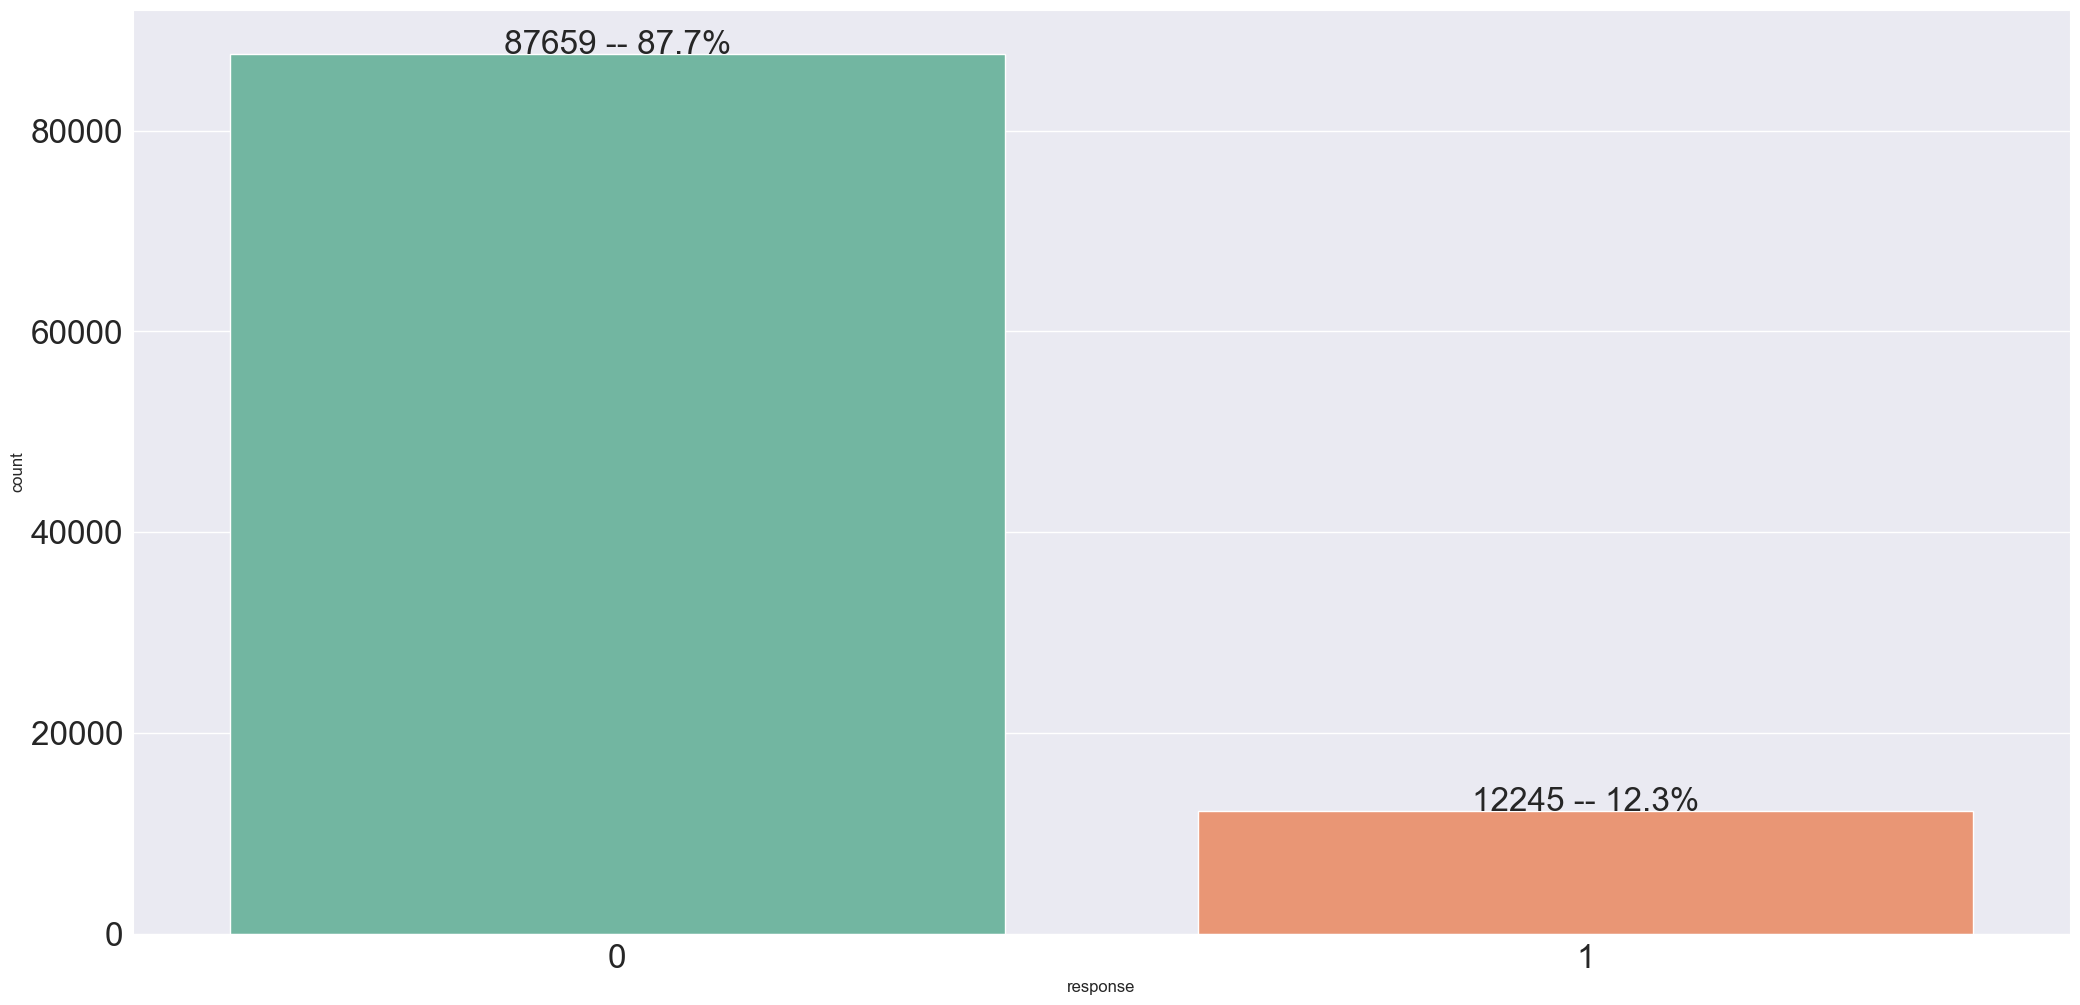

In [326]:
fig, ax = plt.subplots()
sns.countplot(data = df1, x='response', ax = ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1)*100, 1)}%', ha='center')

#### 4.1.2. Numeic Variable

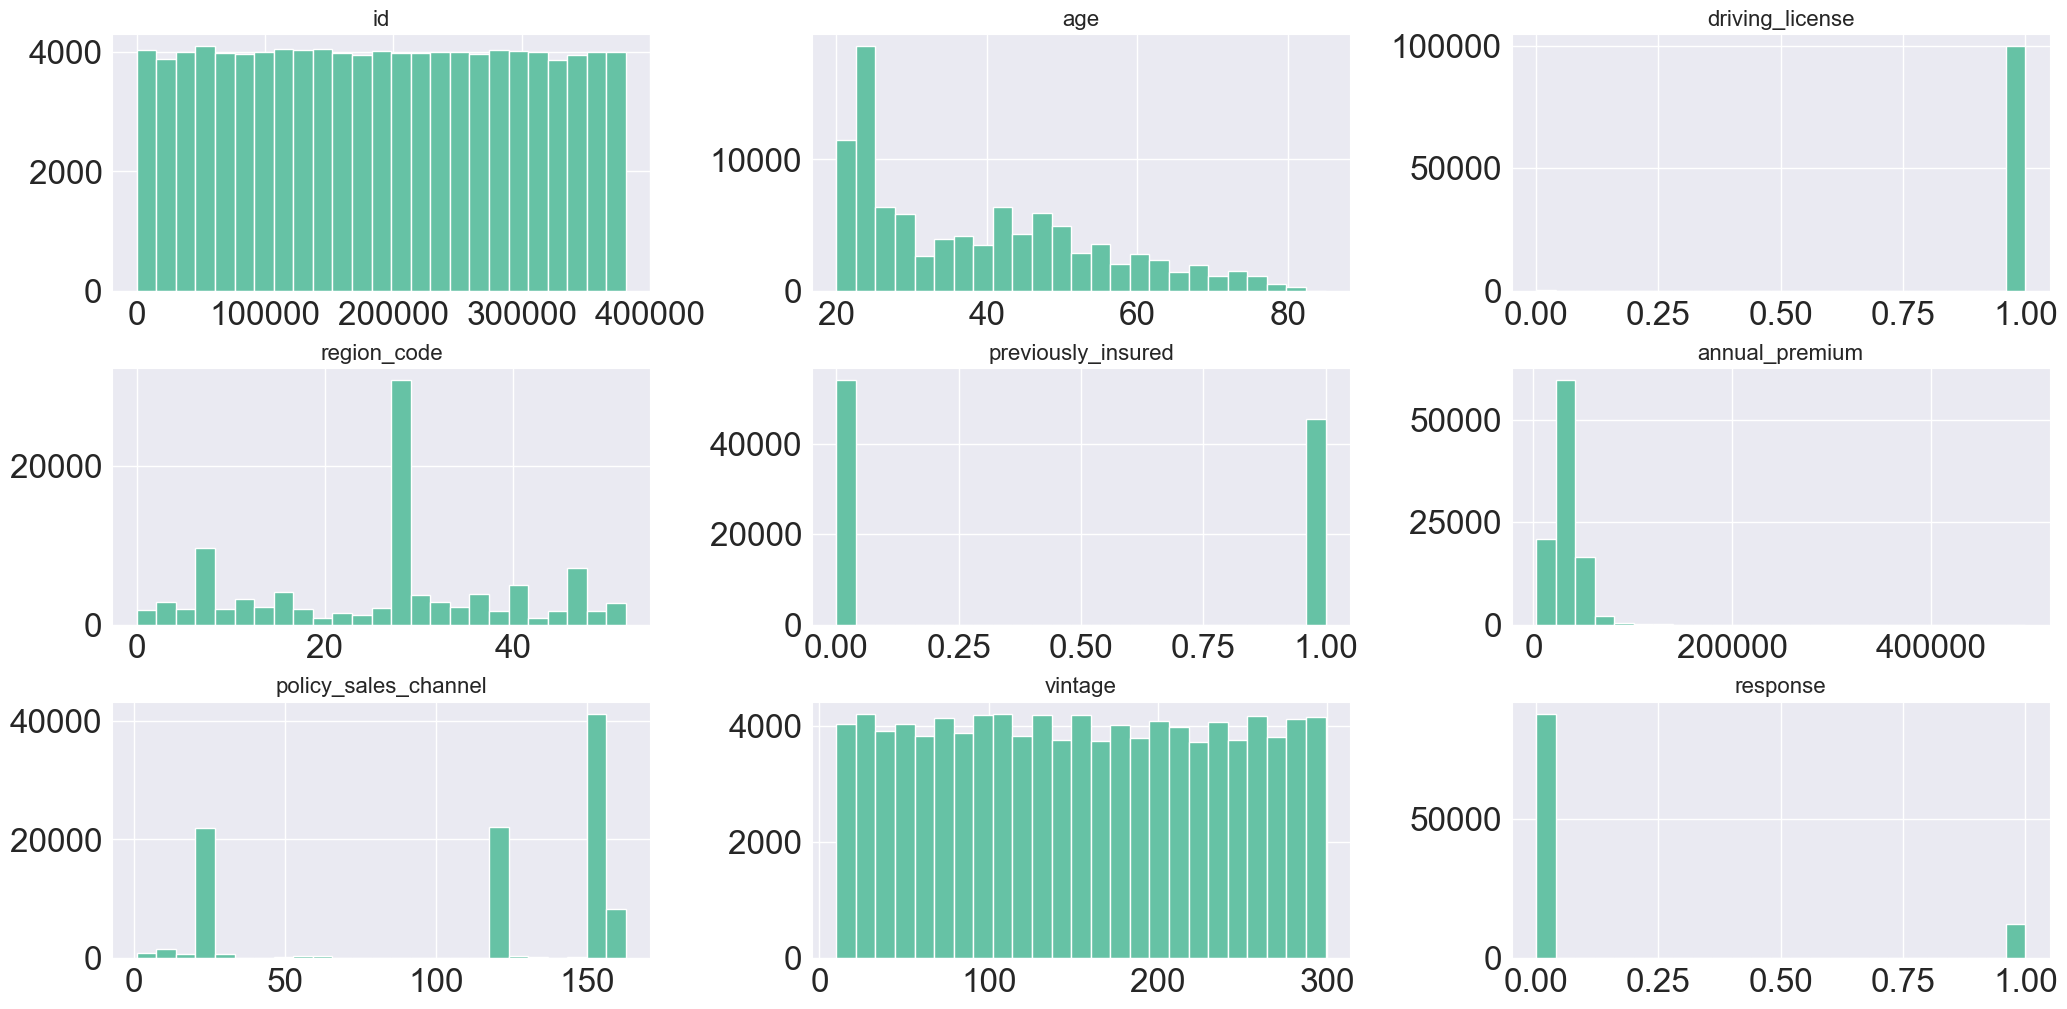

In [327]:
num_attributes.hist(bins=25);

## 4.2. Bivariate Analysis


### 4.2.1. Gender

- Dos 105.424 clientes homens no total, 13% demonstram interesse no seguro
- Já entre as mulheres, das 89.703 clientes, 10% possuem interesse no seguro

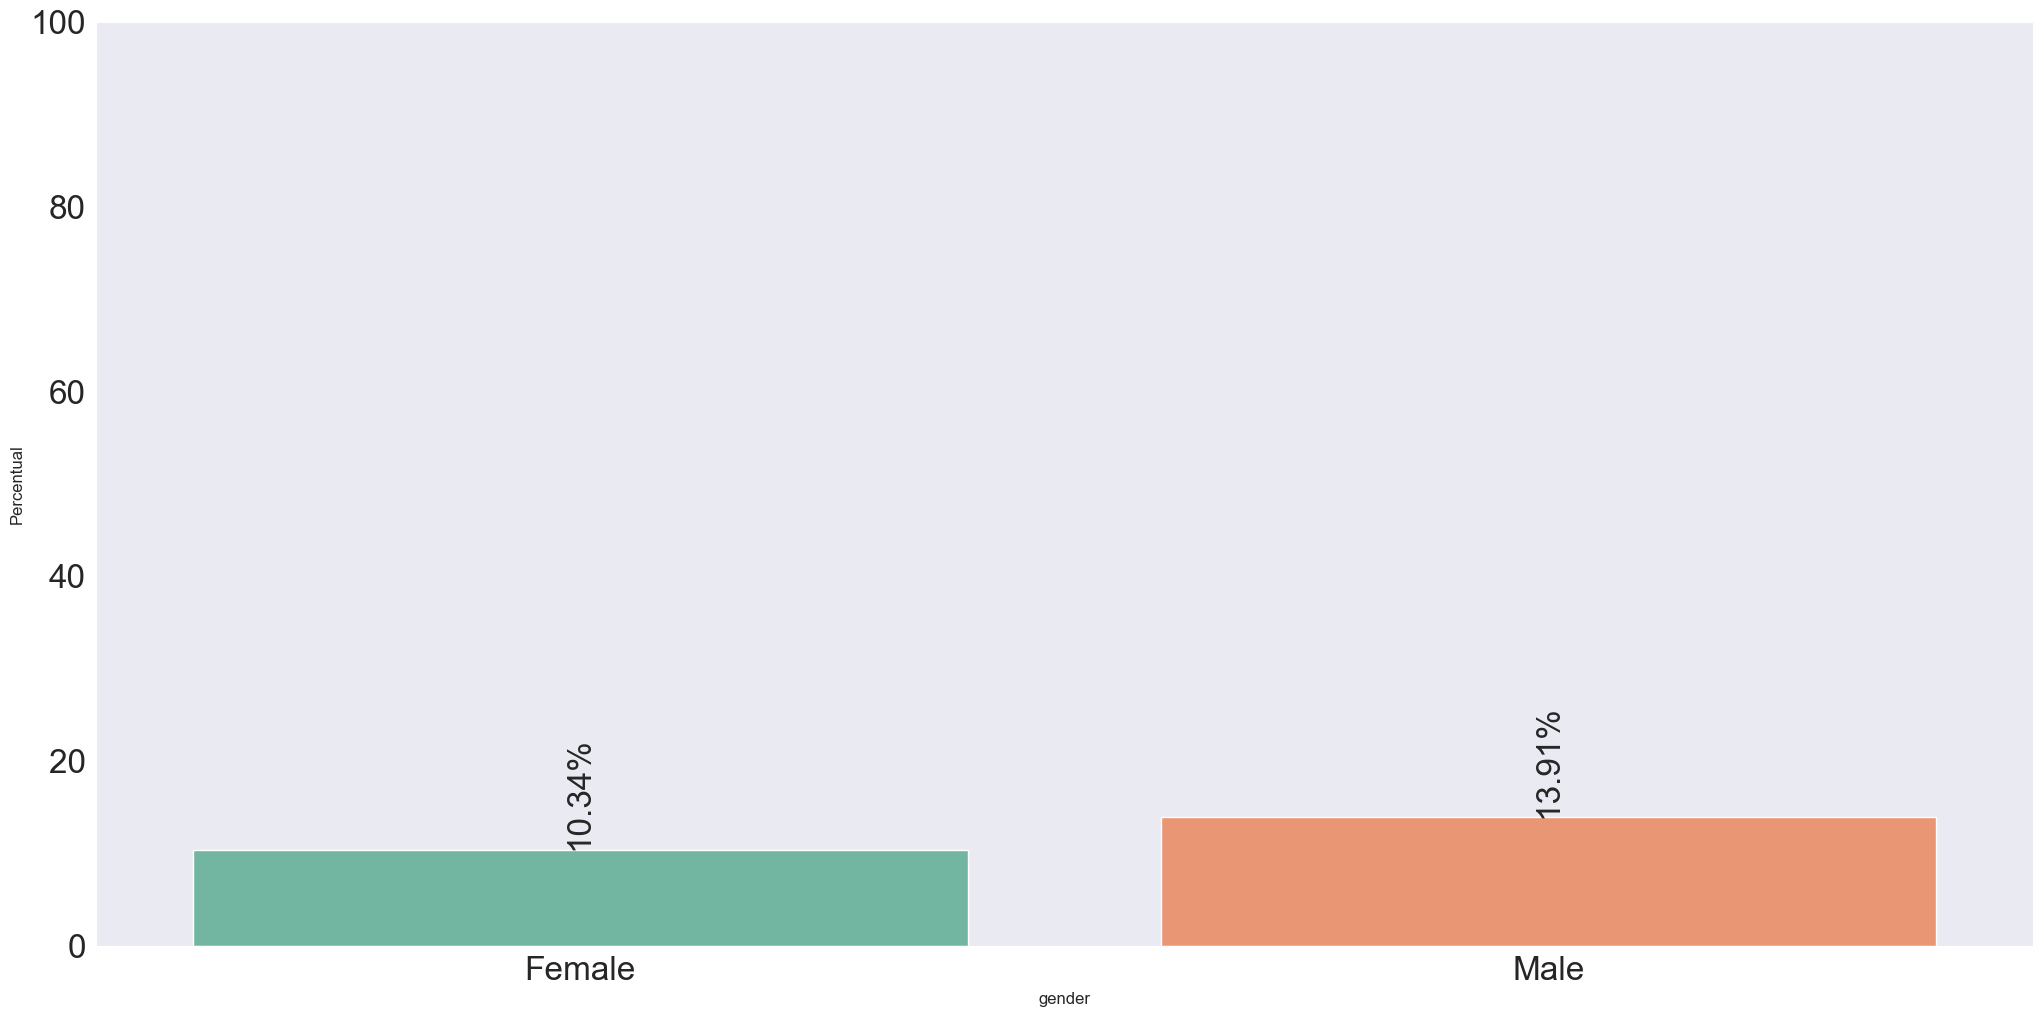

In [335]:
conversion_plots(df4, 'gender')

In [329]:
df4[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()

gender  response     id
0  Female         0  41364
1  Female         1   4768
2    Male         0  46295
3    Male         1   7477

### 4.2.2. Age

- Faixa etária de 32 a 53 anos: Apresenta um interesse maior na aquisição do seguro de carro
- Faixa etária abaixo de 30 anos: Concentra o grupo com menor interesse na aquisição do seguro de carro

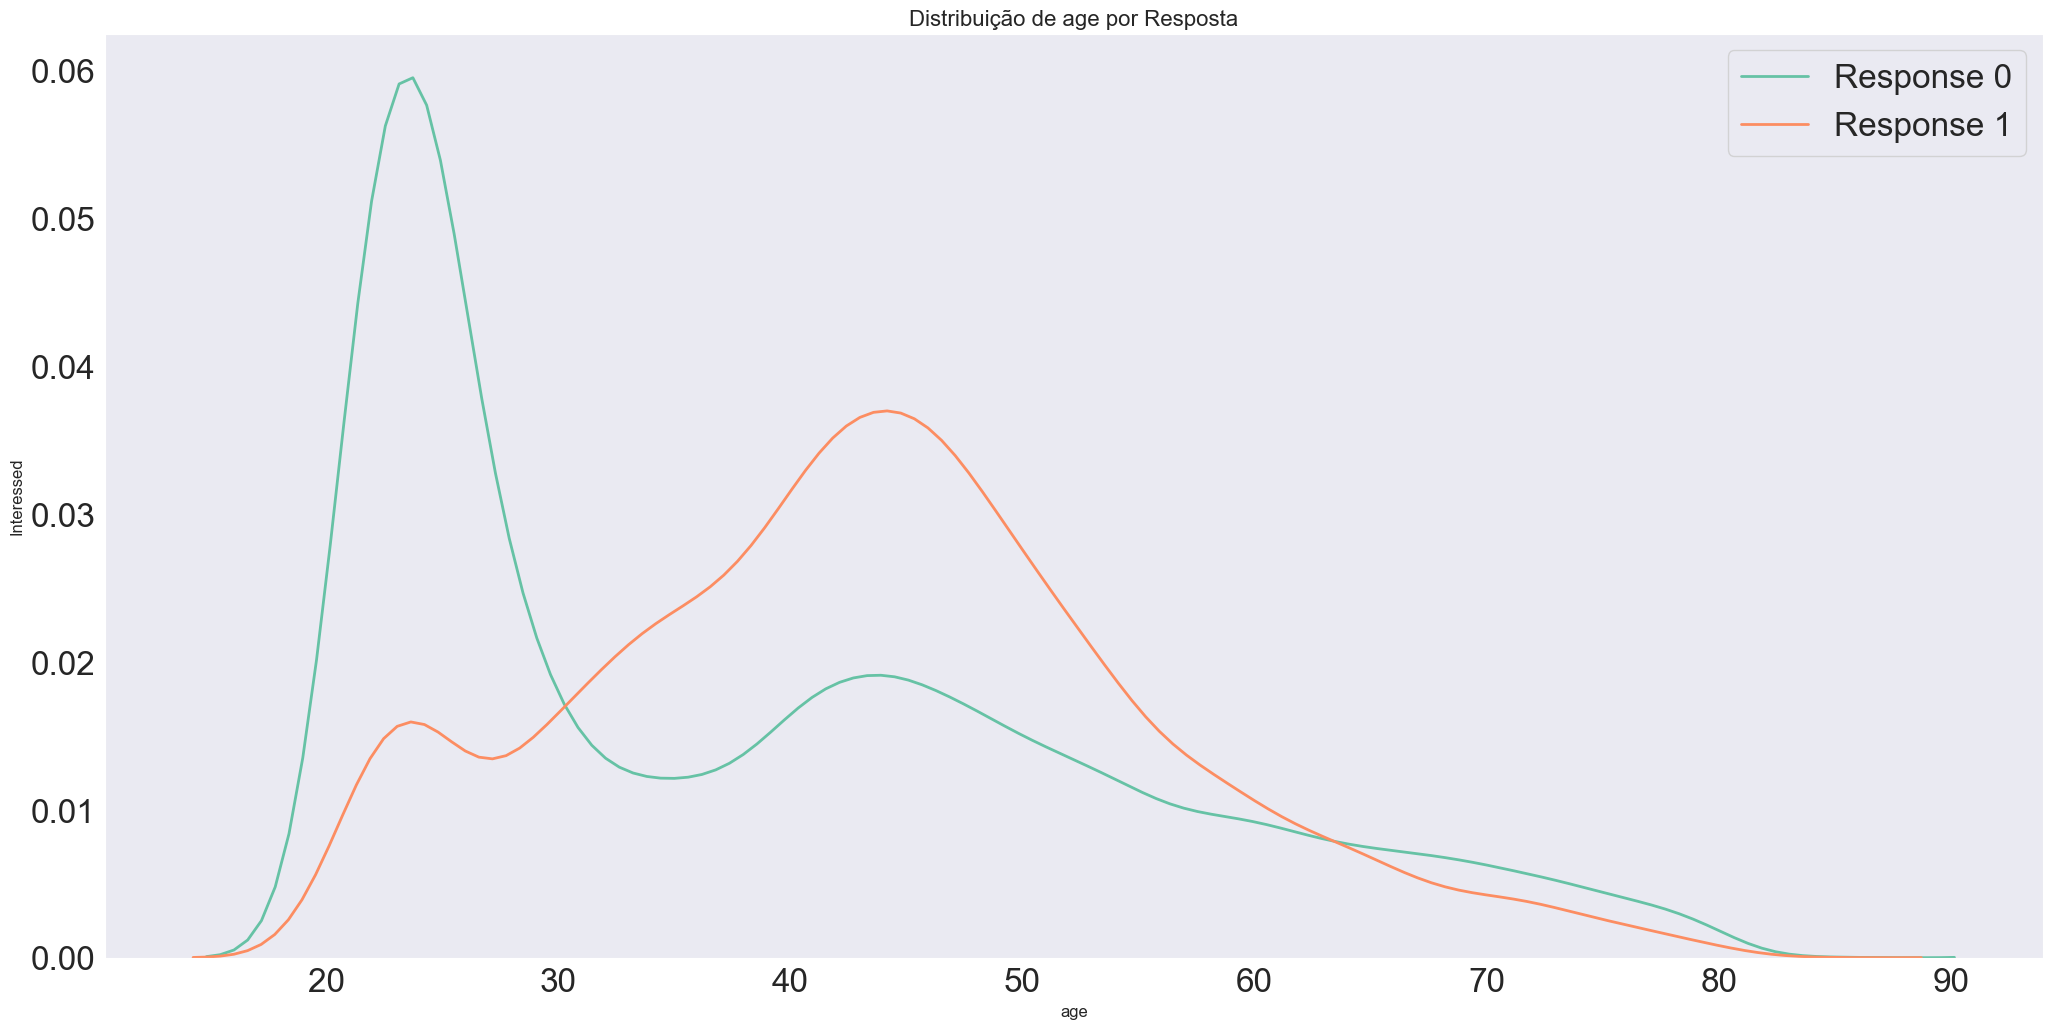

In [330]:
line_plot(df4, 'age')

### 4.2.3. Region Code

<Figure size 1200x600 with 0 Axes>

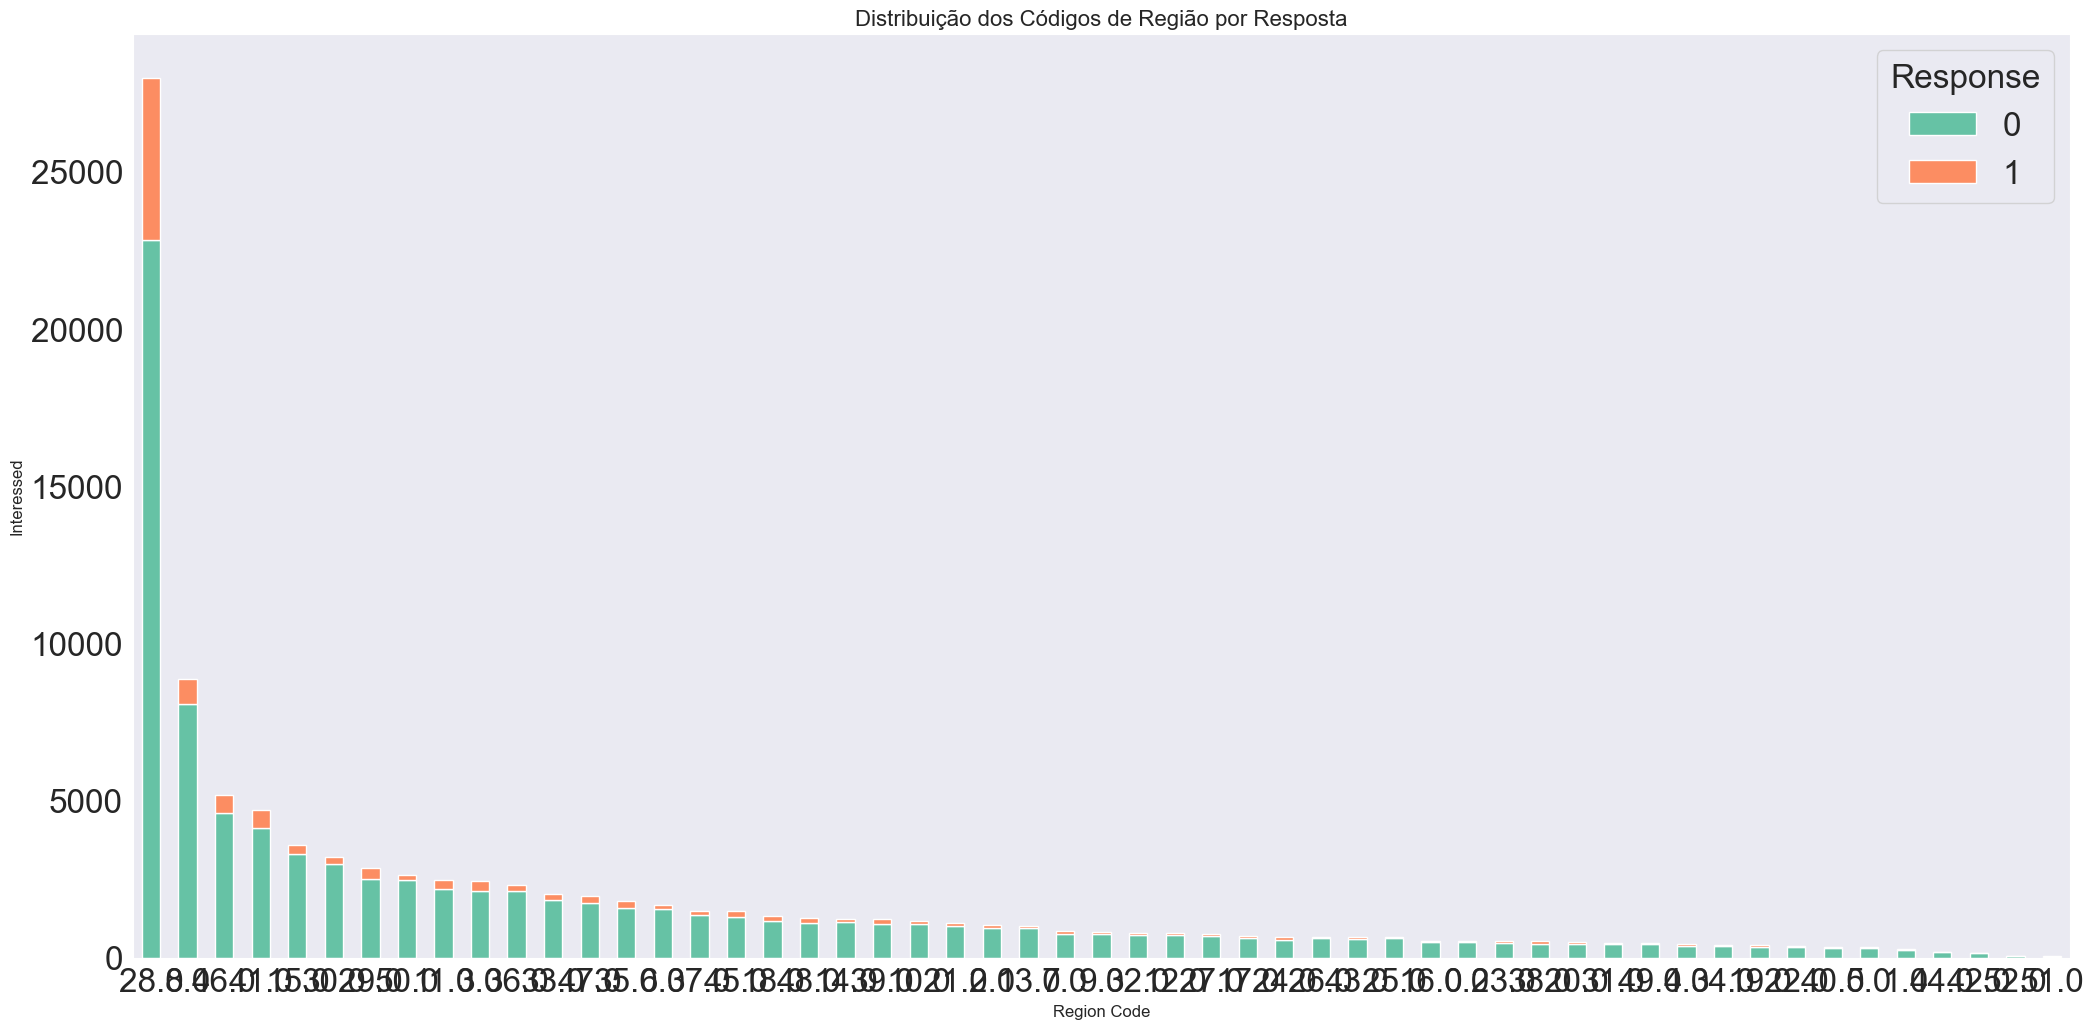

In [336]:
# Agrupar os dados por código de região e resposta e contar a frequência
region_response_counts = df4.groupby(['region_code', 'response']).size().unstack().fillna(0)

# Ordenar os códigos de região por ordem decrescente de total
region_response_counts['Total'] = region_response_counts.sum(axis=1)
region_response_counts = region_response_counts.sort_values('Total', ascending=False).drop('Total', axis=1)

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
region_response_counts.plot(kind='bar', stacked=True)

plt.xlabel('Region Code')
plt.ylabel('Interessed')
plt.title('Distribuição dos Códigos de Região por Resposta')

plt.legend(title='Response', loc='upper right')

plt.xticks(rotation=0)  # Rotação dos rótulos do eixo x, se necessário

plt.show()

### 4.2.4. Policy Sales Channel

- Os 3 principais canais de venda de apólices respondem por 79,57% dos clientes captados

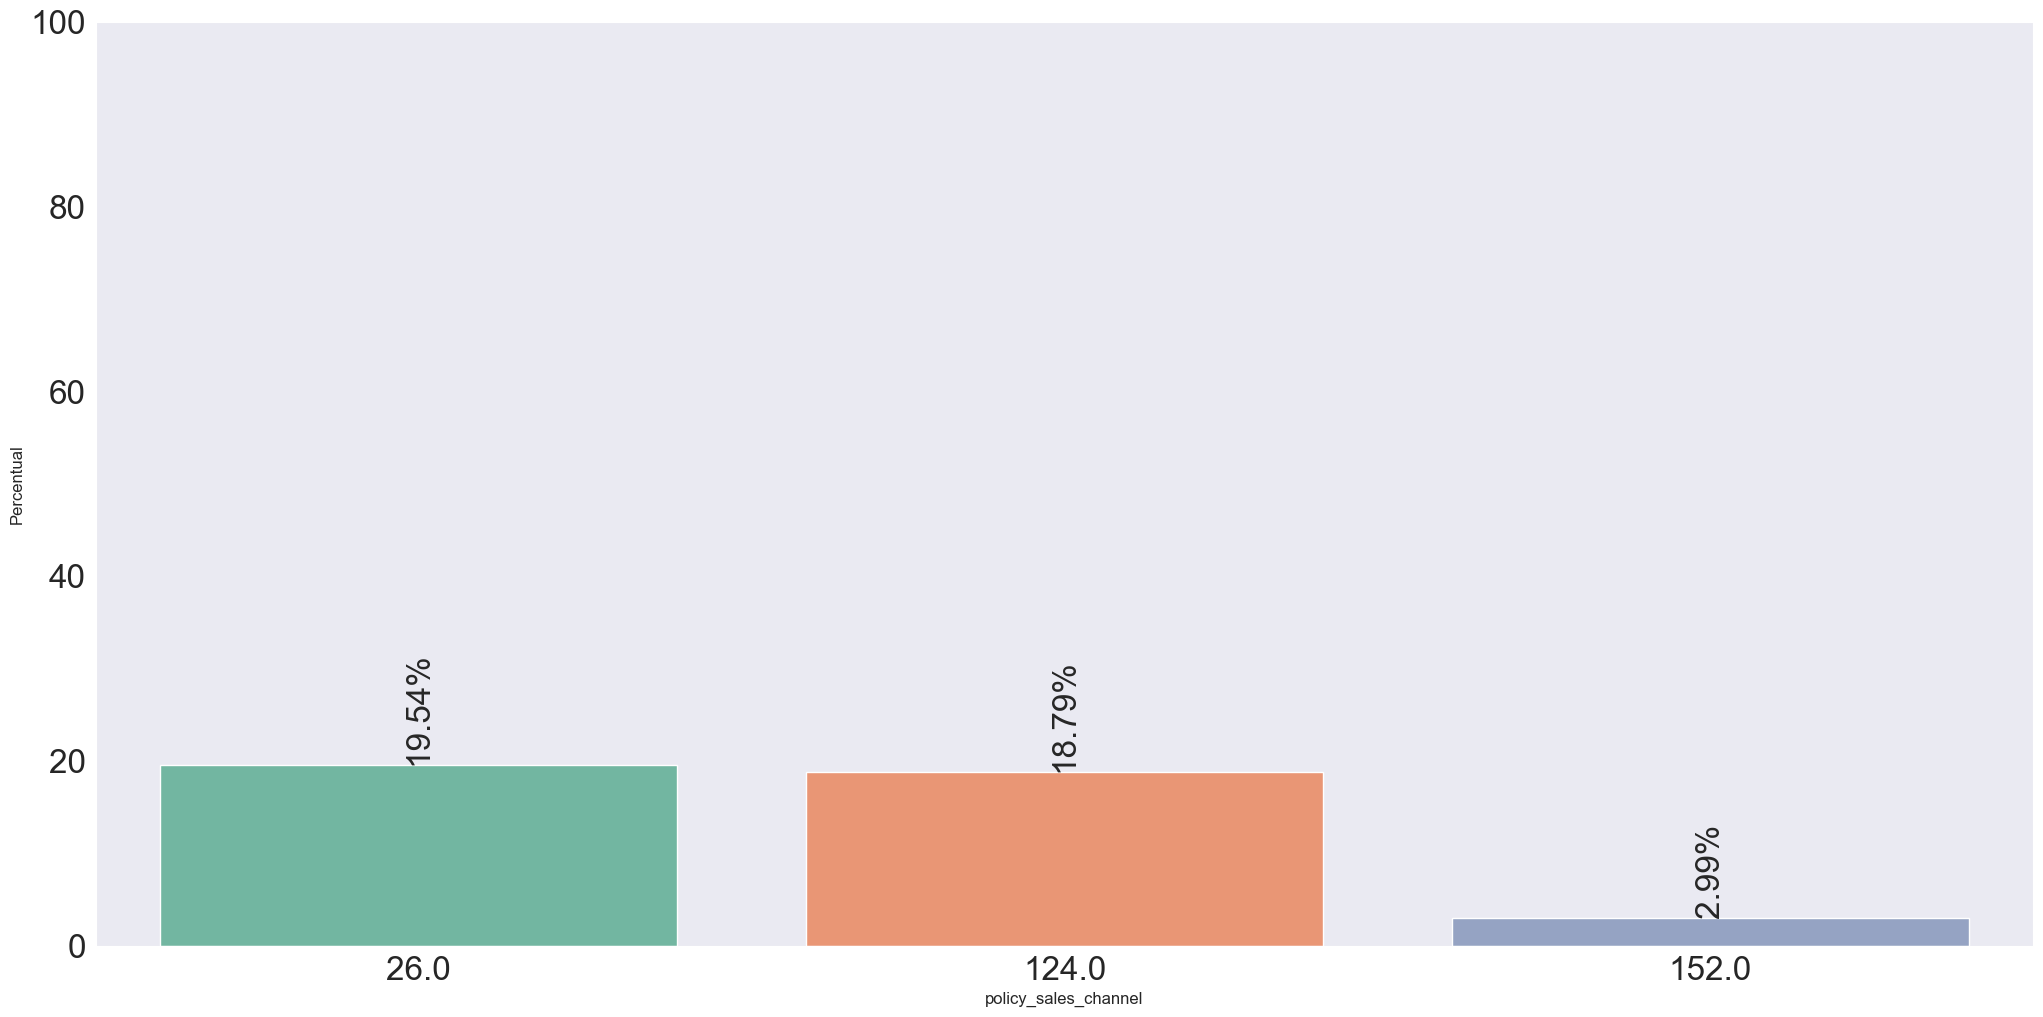

In [337]:
top3 = df4.policy_sales_channel.value_counts().sort_values(ascending=False).head(3).index

df_top3 = df4[df4.policy_sales_channel.isin(top3)]
conversion_plots(df_top3, 'policy_sales_channel')

In [ ]:
# Calculate the percentage of customers attracted by the top 3 channels
total_customers = df4.shape[0]
top3_customers = df_top3.shape[0]
percentage = (top3_customers / total_customers) * 100

print(f"The top 3 policy sales channels account for {percentage:.2f}% of the attracted customers.")


The top 3 policy sales channels account for 79.57% of the attracted customers.


### 4.2.5. Driving License

- Entre os interessados, 4% são clientes sem carta de condução, enquanto que 12% são clientes com carta de condução

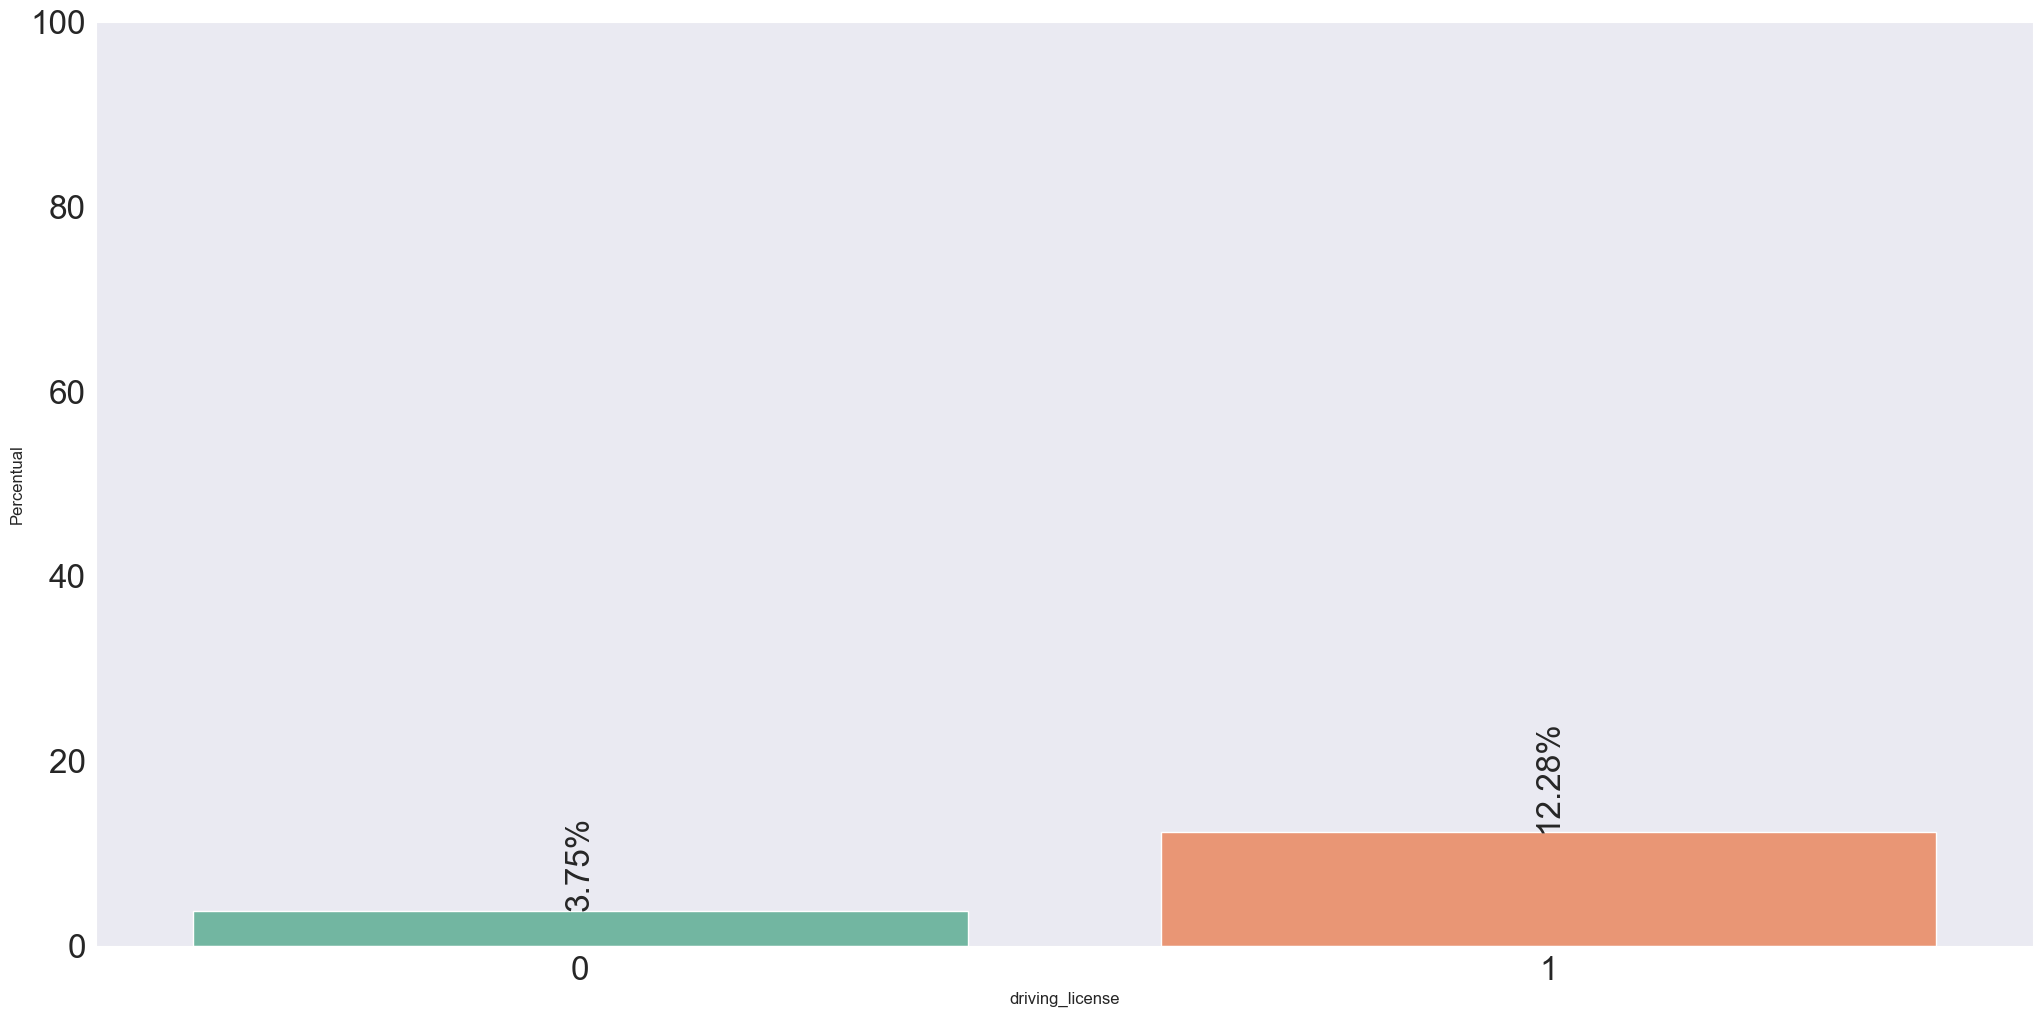

In [338]:
conversion_plots(df4, 'driving_license')

### 4.2.6. Vehicle Age

- Carros com mais de 2 anos apresentam uma taxa de conversão mais alta em comparação aos demais

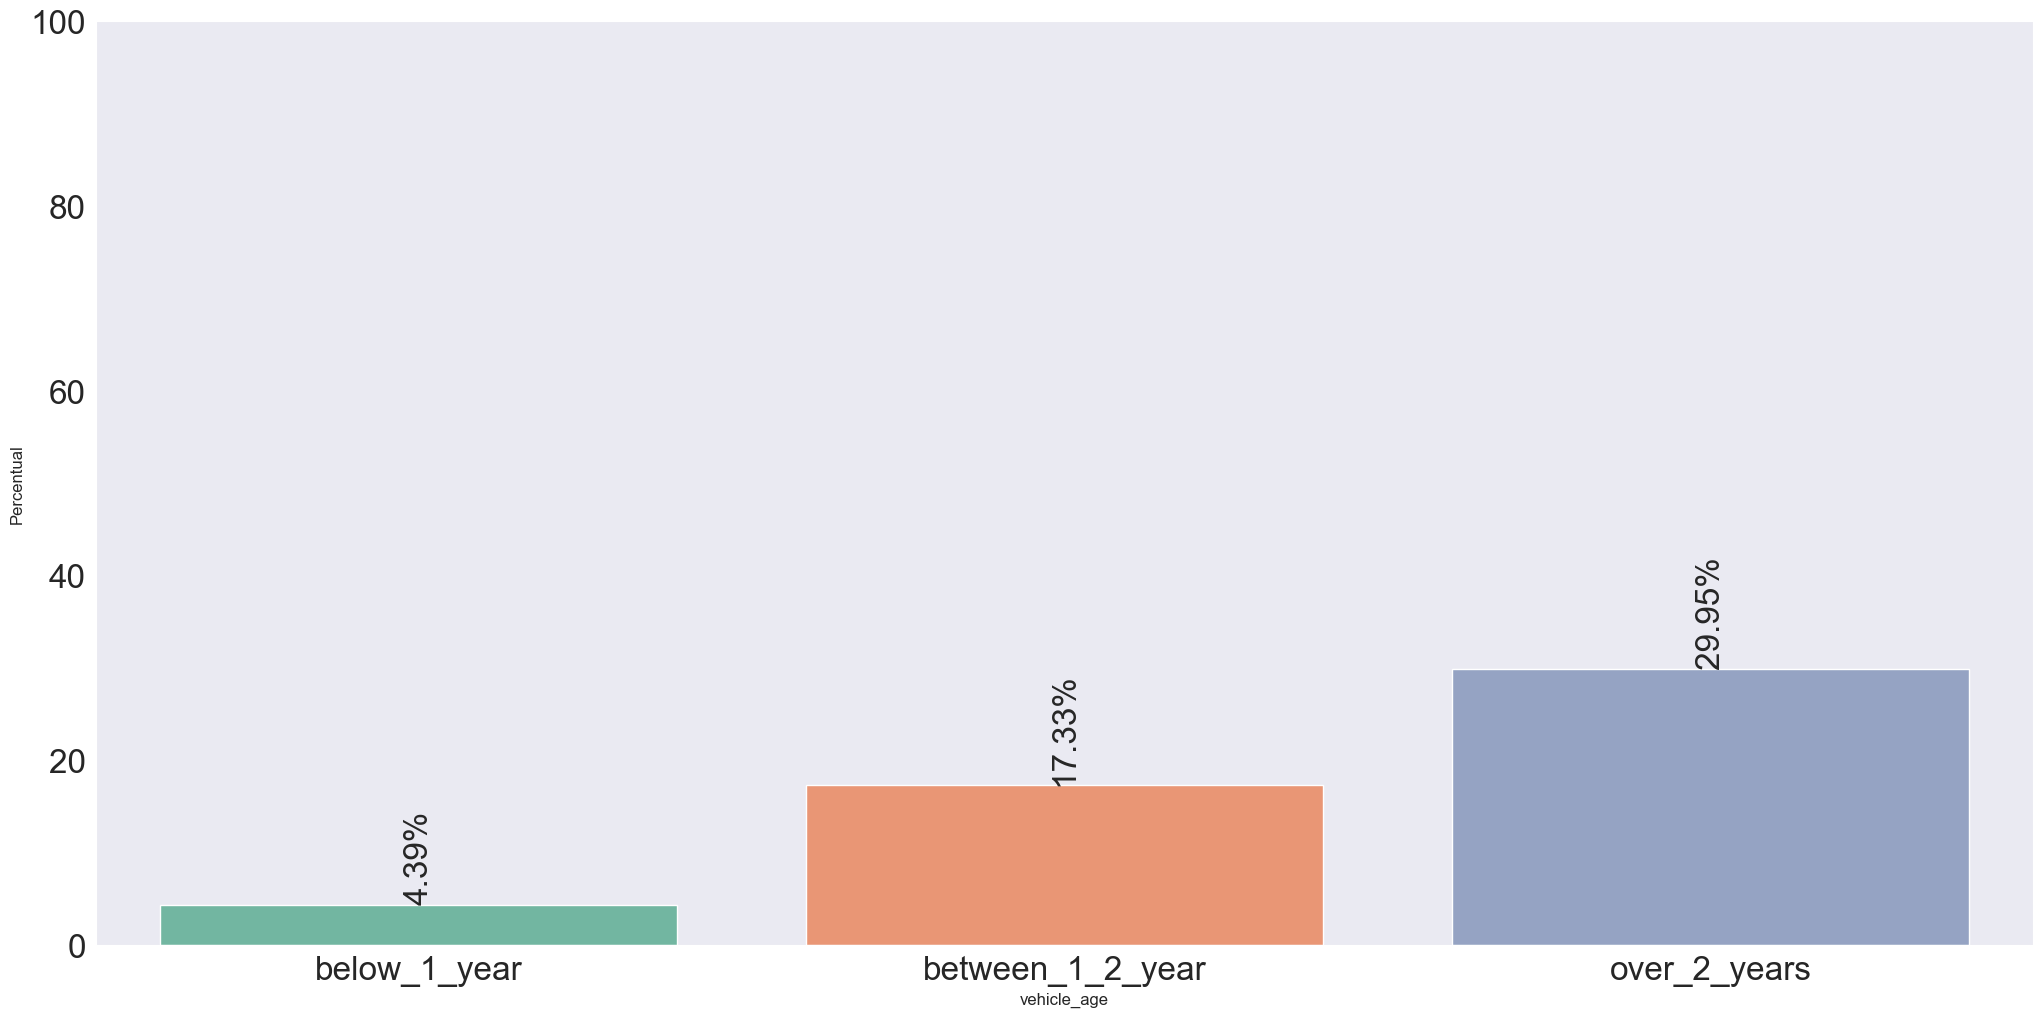

In [339]:
conversion_plots(df4, 'vehicle_age')

### 4.2.7. Vehicle Damage

-  A experiência anterior de acidentes pode influenciar a percepção dos indivíduos sobre a importância e a necessidade de obter um seguro de carro

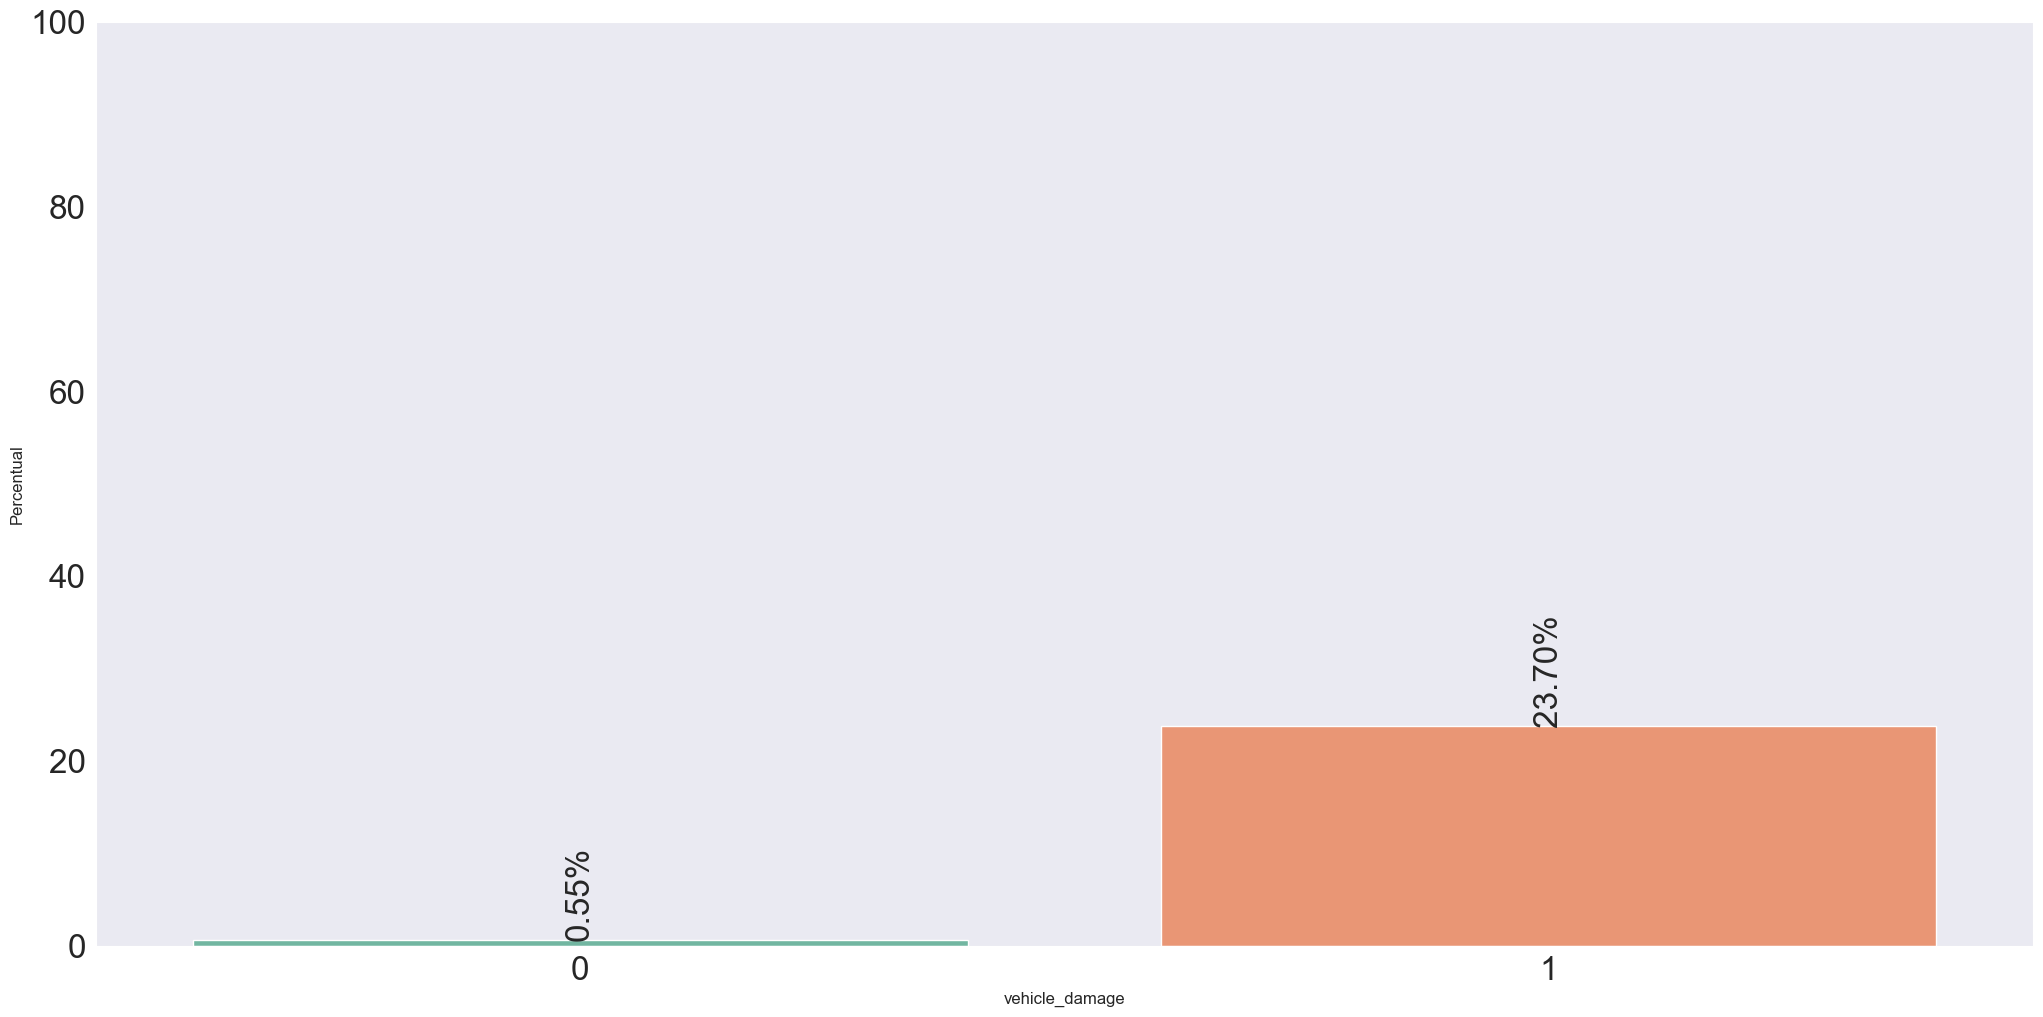

In [340]:
conversion_plots(df4, 'vehicle_damage')

### 4.2.8. Previously Insured

- A posse prévia de um seguro de carro pode influenciar a percepção dos indivíduos sobre a necessidade de obter cobertura adicional ou de buscar alternativas no mercado

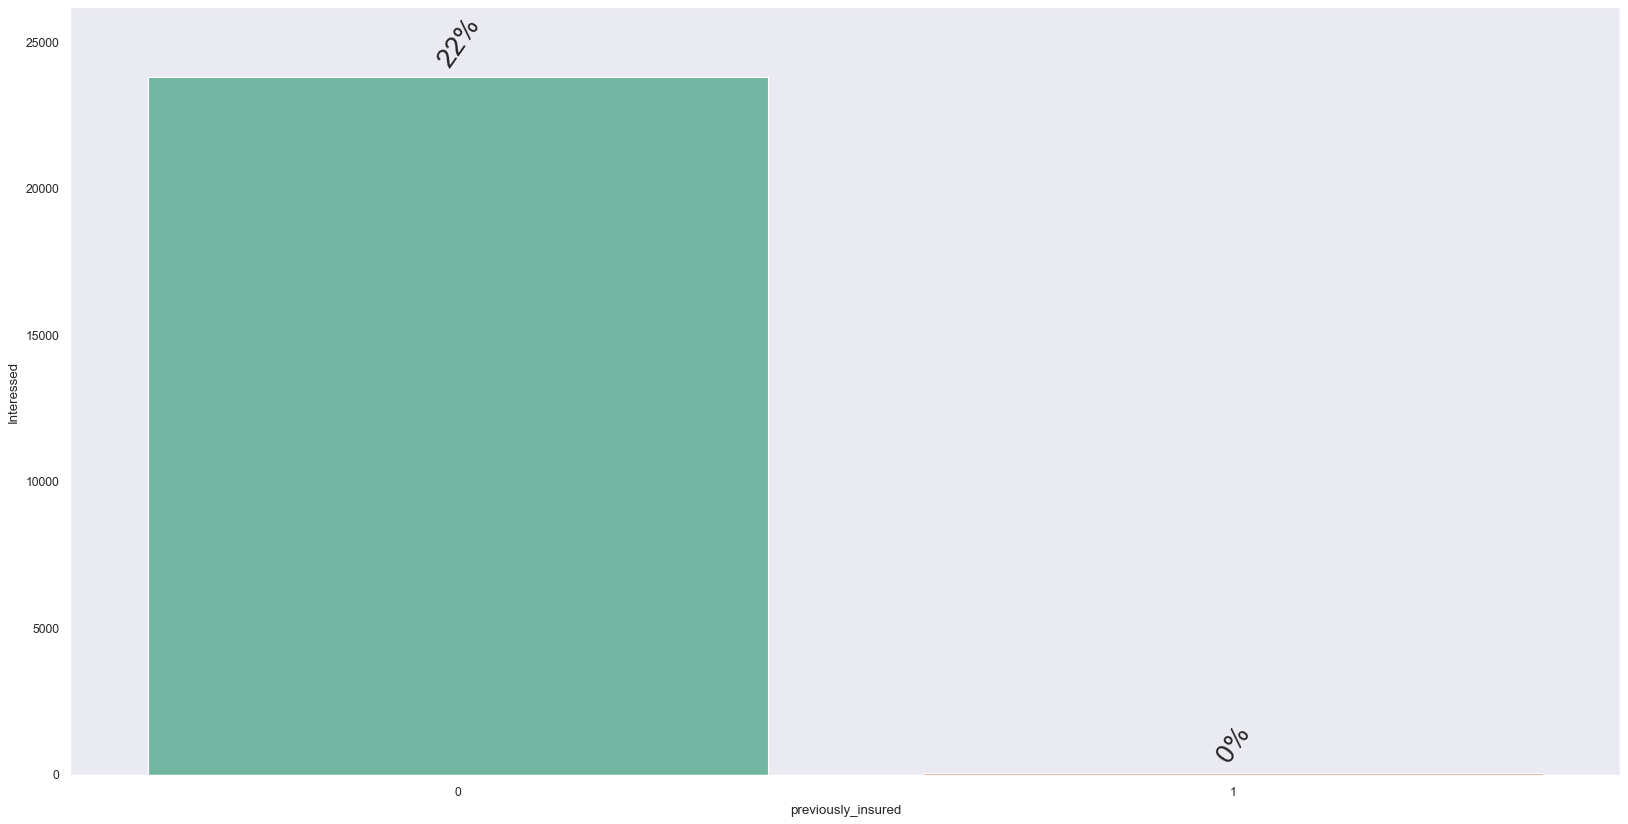

In [ ]:
convertion_plots(df4, 'previously_insured')

### 4.2.9. Annual Premium

<AxesSubplot: xlabel='response', ylabel='annual_premium'>

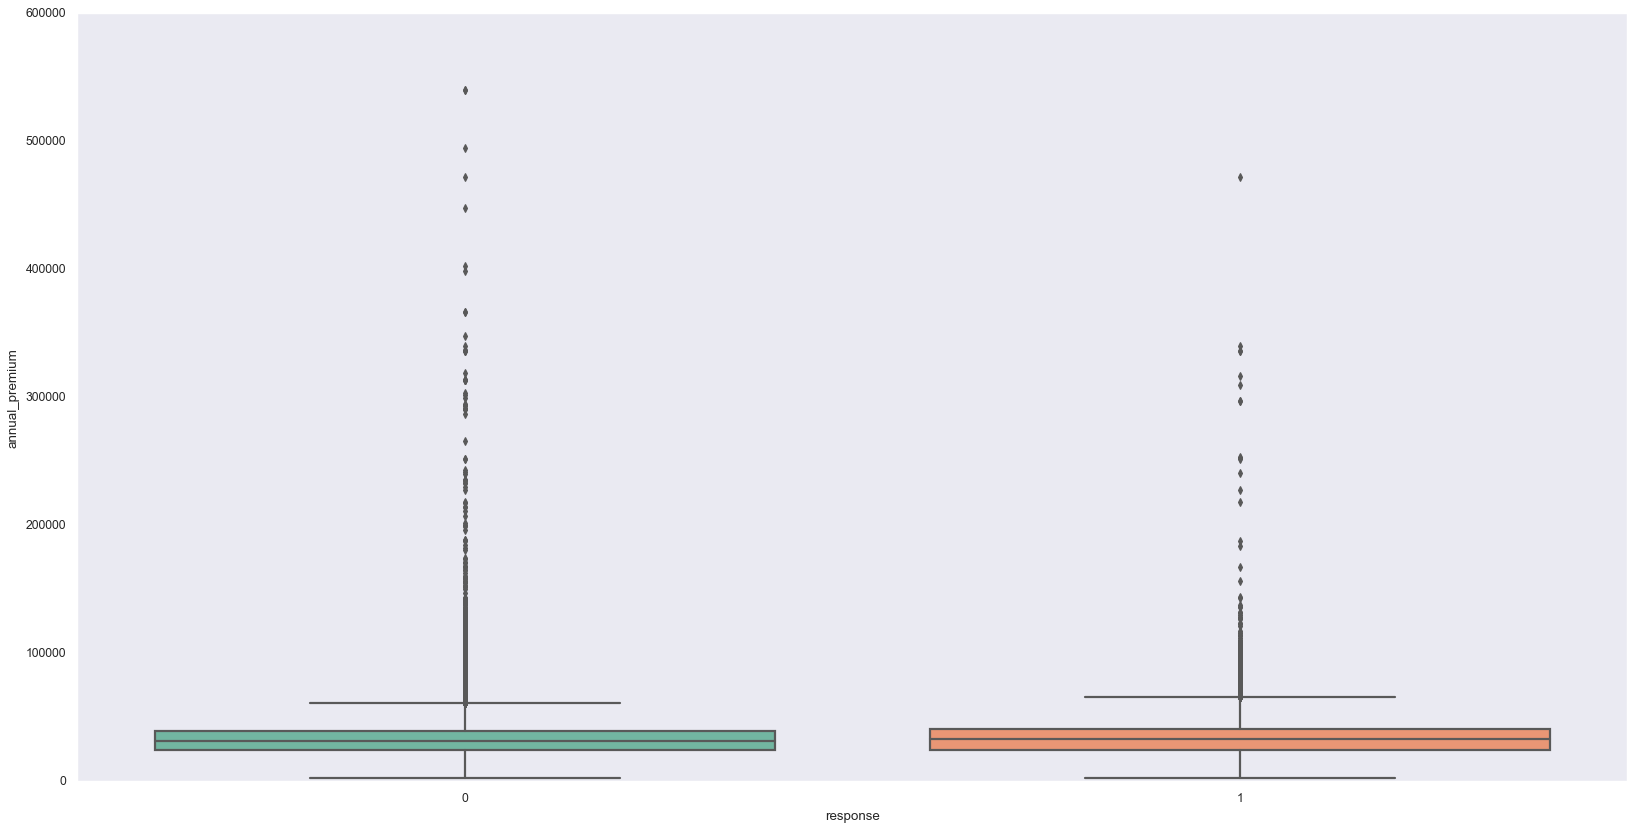

In [ ]:
sns.boxplot(x='response', y='annual_premium', data=df4)

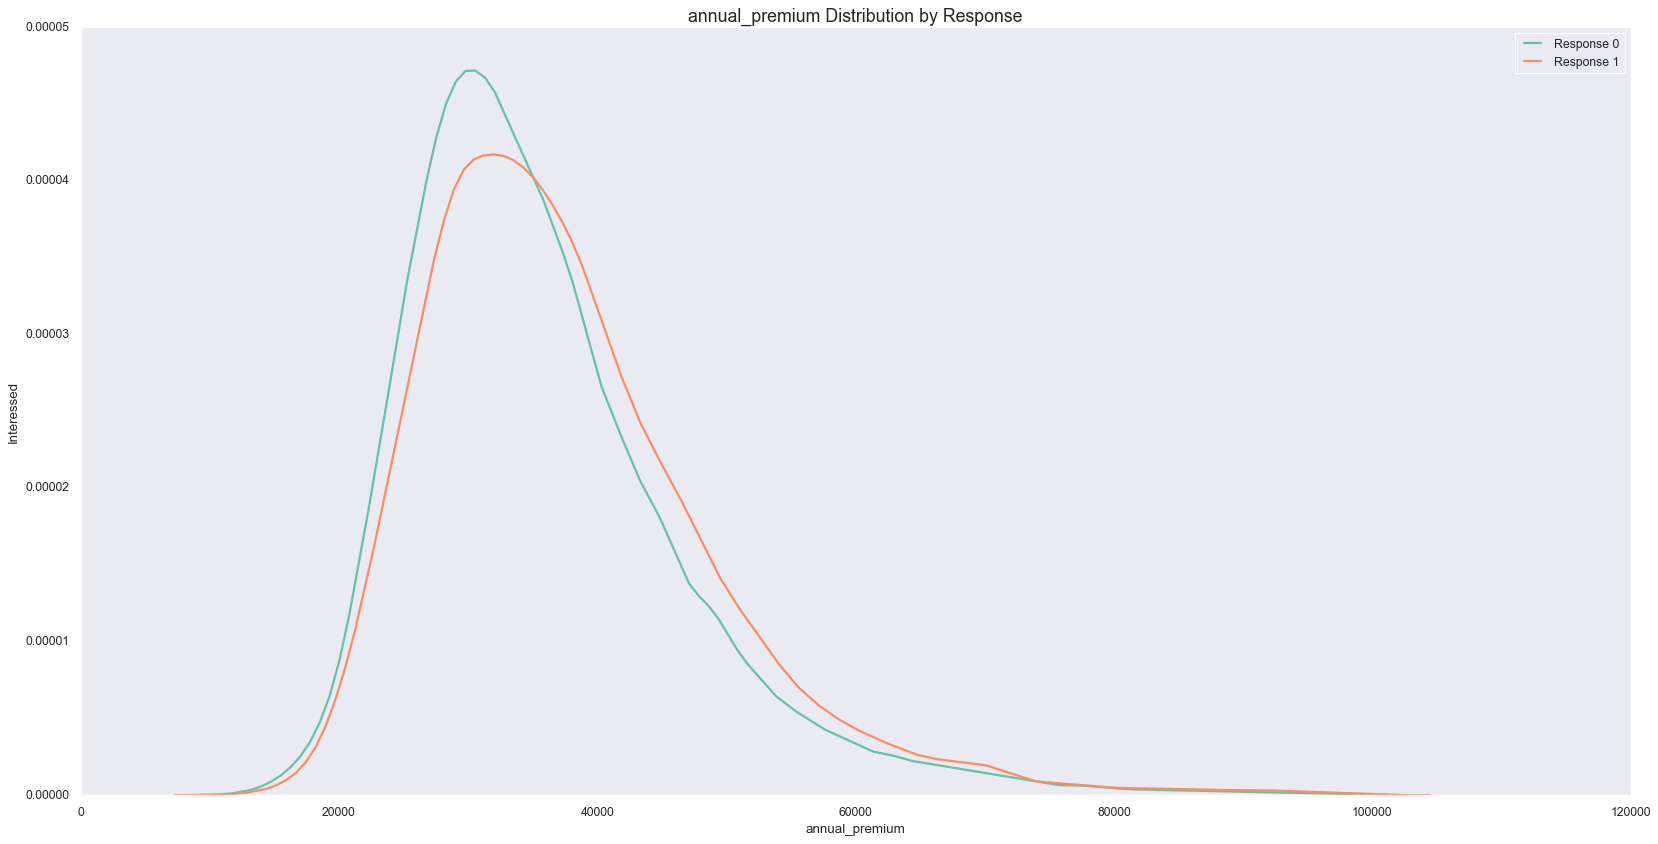

In [ ]:
line_plot(df4, 'annual_premium')

### 4.2.10. Vintage

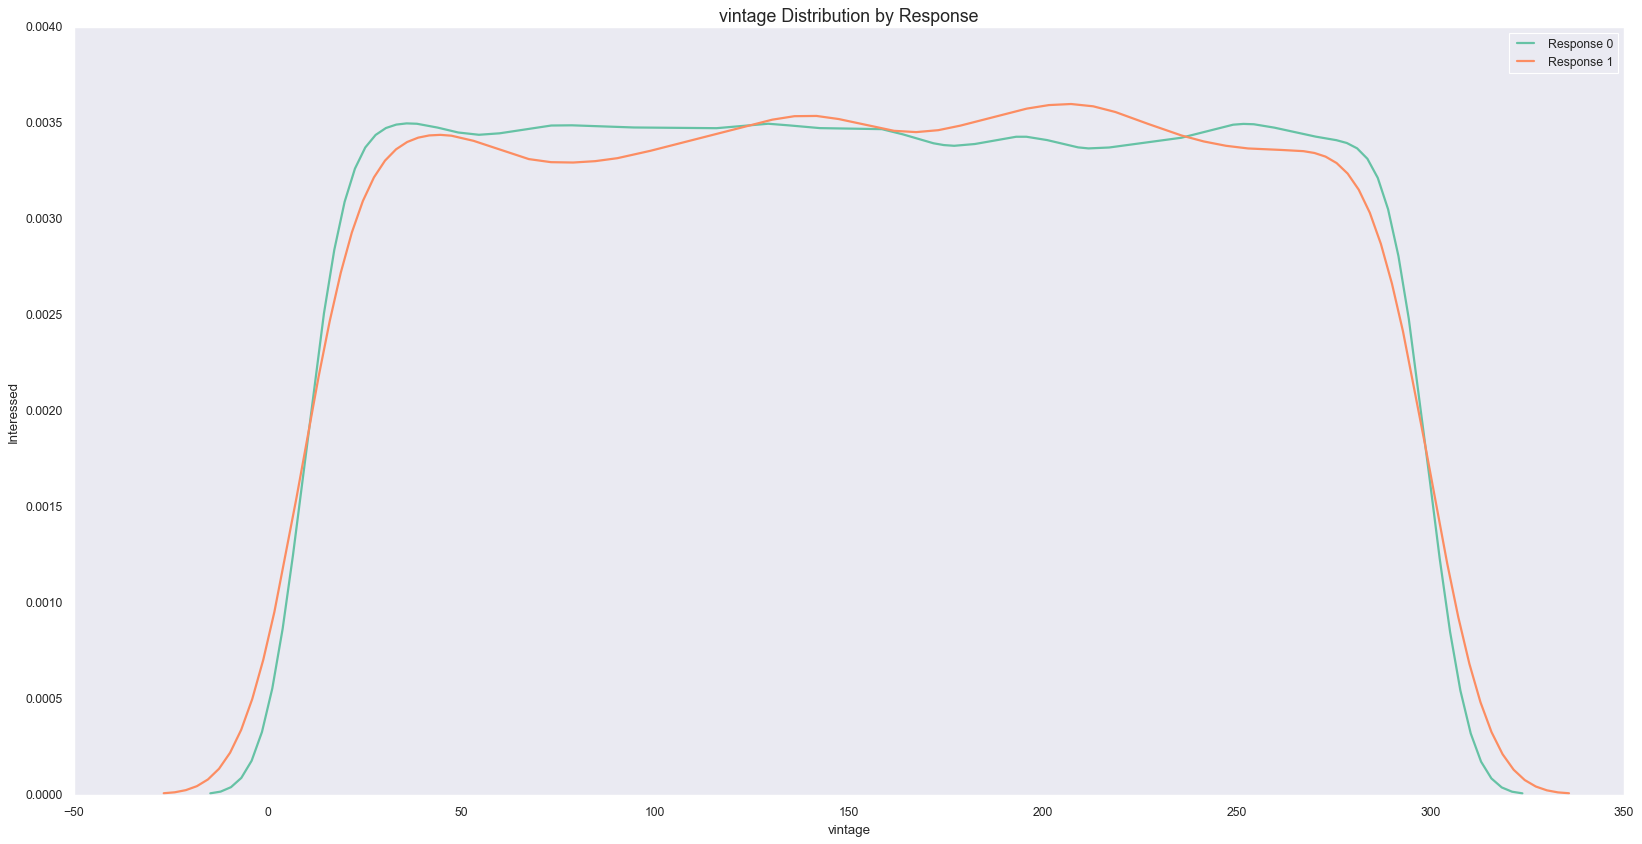

In [ ]:
line_plot(df4, 'vintage')

## 4.3. Multivariable Analysis

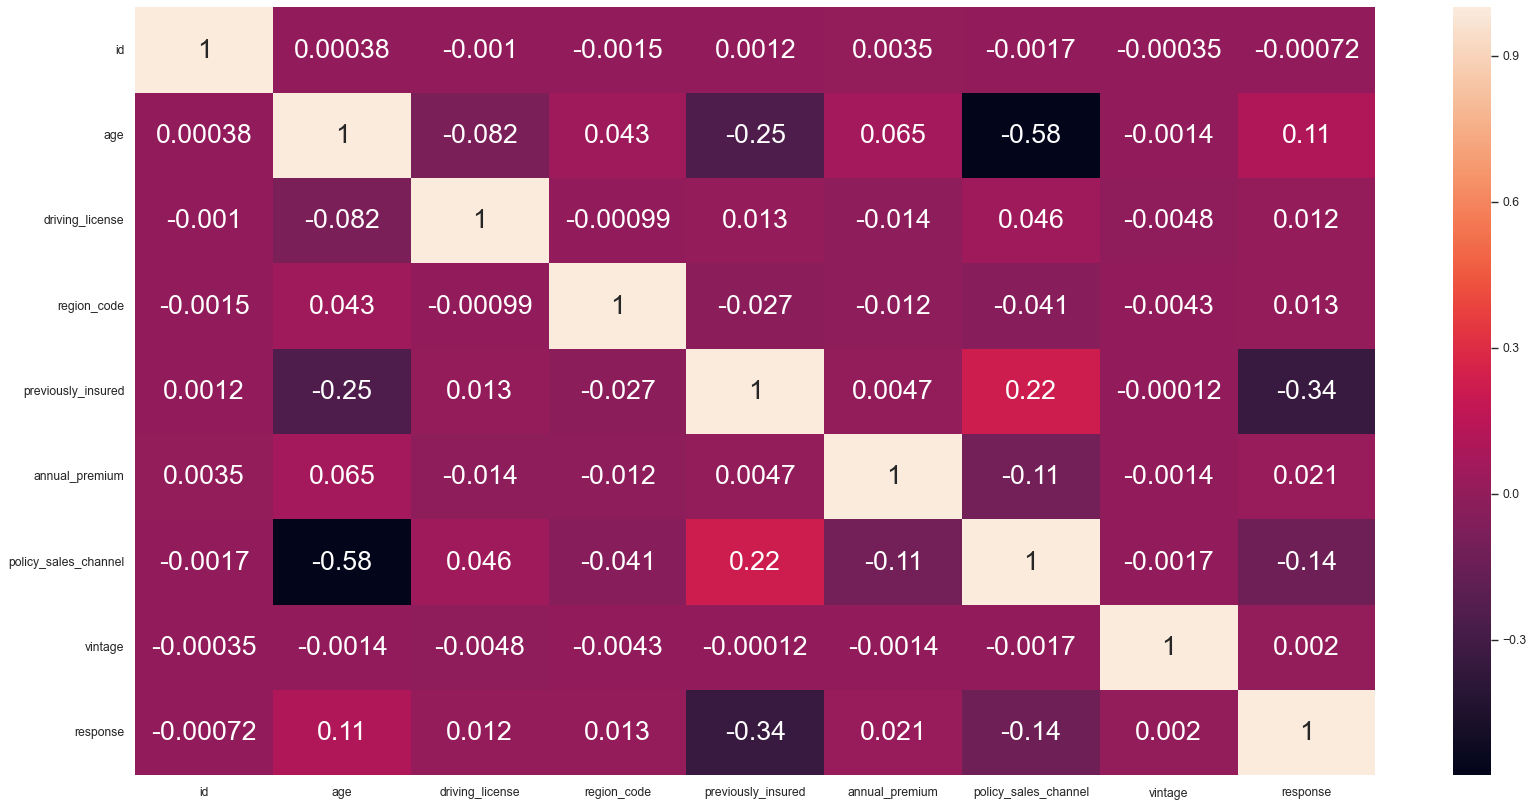

In [ ]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True);

## 4.4. Hypotheses


1. Clientes com menos de 30 anos têm uma probabilidade menor de se interessar por um seguro de carro.

2. Mulheres têm maior probabilidade de adquirir um seguro de veículo do que homens.

3. Clientes que não possuem licença para dirigir apresentam menor interesse em adquirir um seguro de veículo.

4. Clientes que não possuem outro seguro de carro têm maior probabilidade de adquirir o seguro de veículo.

5. Clientes que pagam um prêmio mais alto têm maior probabilidade de adquirir um seguro de veículo.

6. Clientes com mais tempo de posse do seguro saúde têm maior probabilidade de se interessar por um seguro de veículo.

7. Os cinco canais de venda mais utilizados são responsáveis por atrair aproximadamente 20% dos clientes interessados em adquirir um seguro de carro.

8. Clientes com veículos mais novos apresentam maior probabilidade de ter um seguro de veículo.

### 4.4.1. Clientes com menos de 30 anos têm uma probabilidade menor de se interessar por um seguro de carro.

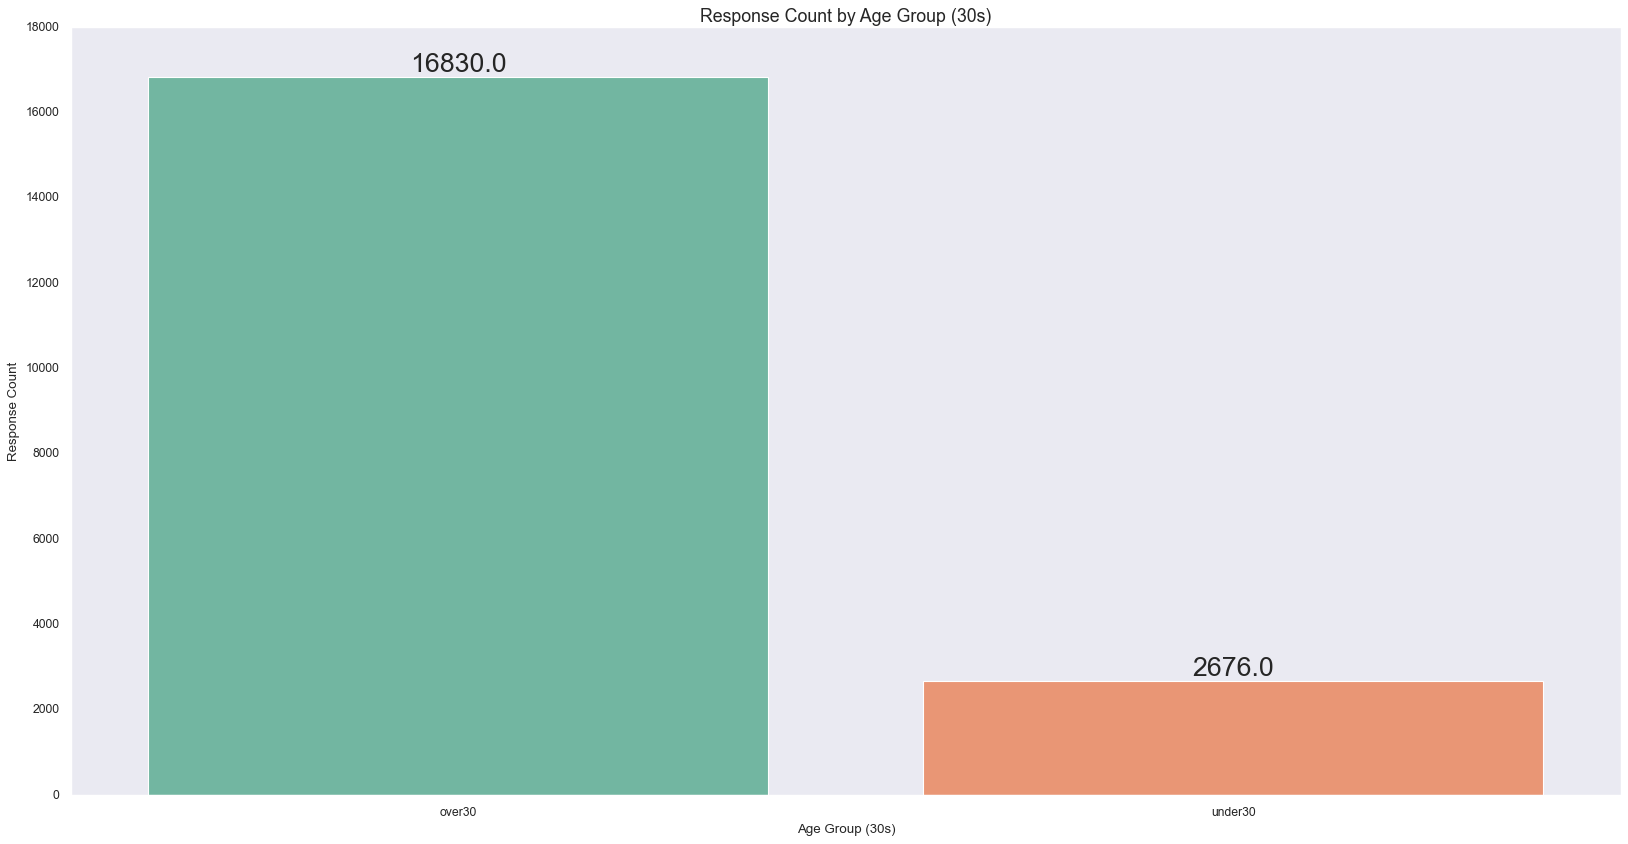

In [ ]:
aux1 = df4[['age30', 'response']].groupby('age30').sum().reset_index().sort_values('response', ascending=False)

fig, ax = plt.subplots()
sns.barplot(data=aux1, x='age30', y='response', ax=ax)

for p in ax.patches:
    h = p.get_height()
    ax.annotate(f'{h}', (p.get_x() + p.get_width() / 2, h), ha='center', va='bottom')

plt.xlabel('Age Group (30s)')
plt.ylabel('Response Count')
plt.title('Response Count by Age Group (30s)')
plt.show()


### 4.2.2. Mulheres têm maior probabilidade de adquirir um seguro de veículo do que homens.

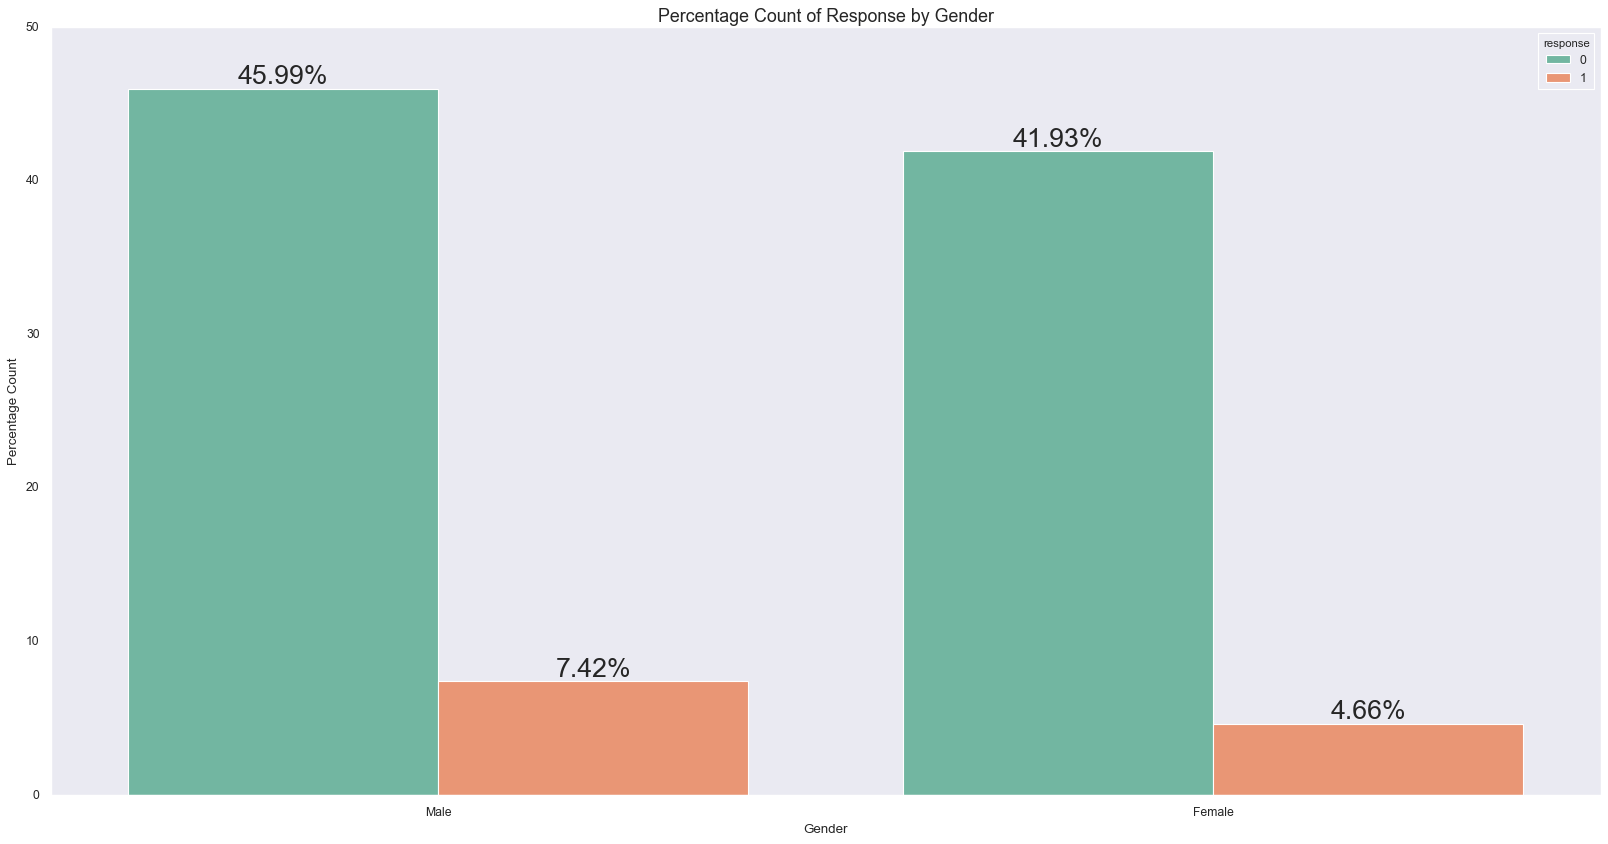

In [ ]:
aux = df4[['gender', 'response']].value_counts().reset_index()
aux['%count'] = (aux[0] / len(df4) * 100).round(2)

ax = sns.barplot(data=aux, x='gender', y='%count', hue='response')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.xlabel('Gender')
plt.ylabel('Percentage Count')
plt.title('Percentage Count of Response by Gender')
plt.show()

# 5.0. Data Preparation

In [ ]:
# Separação dos dados em variáveis preditoras (X) e variável alvo (y)
X = df4.drop('response', axis=1)
y = df4['response'].copy()

# Divisão dos dados em conjunto de treino e conjunto de validação
x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

# Criação do DataFrame df5, que é a concatenação das variáveis preditoras e alvo do conjunto de treino
df5 = pd.concat([x_train, y_train], axis=1)


## 5.1. Standardization 

In [ ]:
# Instanciando o StandardScaler
ss = pp.StandardScaler()

# Aplicando o StandardScaler na coluna 'annual_premium' e salvando o modelo treinado
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb' ))


## 5.2. Rescaling

In [ ]:
# Inicializando dois objetos MinMaxScaler para normalização das colunas 'age' e 'vintage'.
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Aplicando o MinMaxScaler na coluna 'age' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# Aplicando o MinMaxScaler na coluna 'vintage' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ))

## 5.3. Transformation

### 5.3.1. Encoding

In [ ]:
# gender - One Hot Encoding / Target Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'gender'
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'region_code'
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
# One Hot Encoding da coluna 'vehicle_age'
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
# Frequency Encoding da coluna 'policy_sales_channel'
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

C:\Users\raquel\AppData\Local\Temp\ipykernel_18248\1991794763.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )


## 5.4. Validation Preparation

In [ ]:
# gender: aplica a codificação alvo (target encoding) na coluna 'gender'
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age: aplica a transformação MinMaxScaler na coluna 'age'
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code: aplica a codificação alvo (target encoding) na coluna 'region_code'
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age: cria variáveis dummy para a coluna 'vehicle_age'
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium: aplica a transformação StandardScaler na coluna 'annual_premium'
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel: aplica a Frequency Encoding na coluna 'policy_sales_channel'
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage: aplica a transformação MinMaxScaler na coluna 'vintage'
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\raquel\AppData\Local\Temp\ipykernel_18248\2258272651.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )


# 6.0. Feature Selection    

## 6.1. Boruta Algorithm

In [ ]:
# Define os dados de treinamento
x_train_n = df5.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define o modelo ExtraTreesClassifier
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define o BorutaPy, que seleciona as features mais relevantes do modelo
boruta = bt.BorutaPy(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [ ]:
# Cria uma lista de booleanos, com True para as features selecionadas pelo Boruta
cols_selected = boruta.support_.tolist()

# Seleciona apenas as colunas correspondentes às melhores features
# a partir do dataset original
x_train_fs = df5.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features não selecionadas pelo Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

print(f'Cols selected to boruta: {cols_selected_boruta}')
print(f'Cols NOT selected to boruta: {cols_not_selected_boruta}')

Cols selected to boruta: ['age']
Cols NOT selected to boruta: ['annual_premium', 'driving_license', 'gender', 'policy_sales_channel', 'previously_insured', 'region_code', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years', 'vehicle_damage', 'vintage']


## 6.2. Feature Importance

In [ ]:
# Definindo o modelo de classificação com o algoritmo ExtraTreesClassifier
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Preparando os dados de treino: separando as colunas 'id' e 'response'
# os dados de entrada são todos os atributos do dataframe, exceto 'id' e 'response'
x_train_n = df5.drop(['id', 'response'], axis=1)

# Preparando os dados de treino: definindo os dados de saída (variável alvo)
# os dados de saída são obtidos da coluna 'response' do dataframe original
y_train_n = y_train.values

# Treinando o modelo com os dados de treino
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
8                        vintage    0.259903
6                 annual_premium    0.229986
1                            age    0.177829
3                    region_code    0.114331
5                 vehicle_damage    0.068165
7           policy_sales_channel    0.064826
4             previously_insured    0.054981
9       vehicle_age_below_1_year    0.014522
0                         gender    0.006456
10  vehicle_age_between_1_2_year    0.005967
11      vehicle_age_over_2_years    0.002482
2                driving_license    0.000551


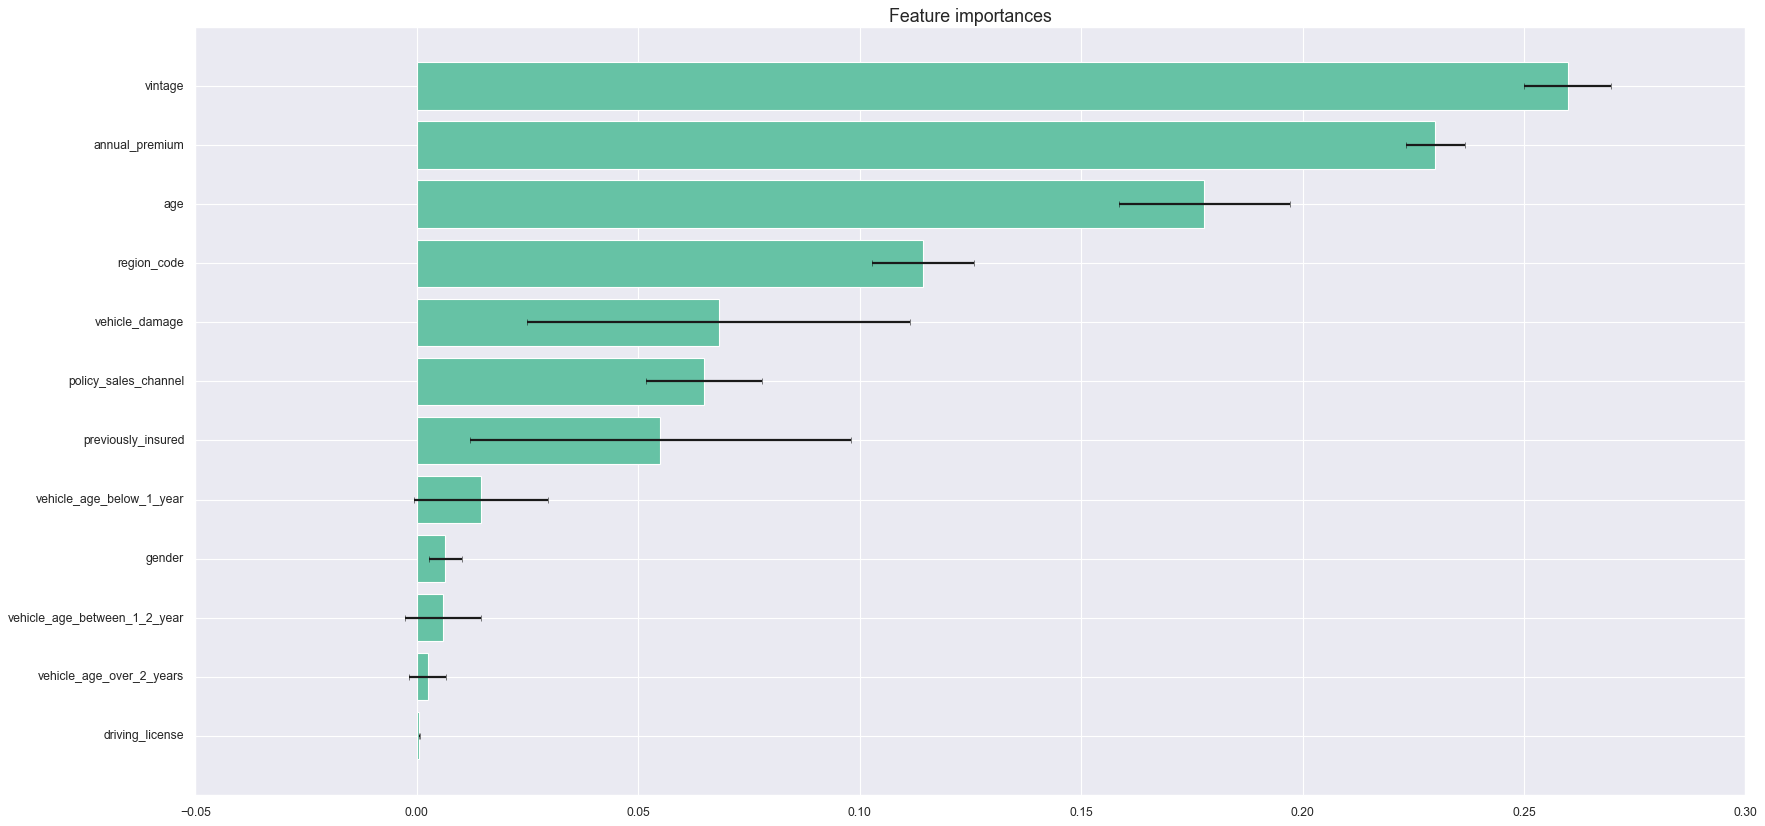

In [ ]:
# Importância de cada feature
importances = forest.feature_importances_

# Desvio padrão das importâncias para cada feature
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Ordena as importâncias em ordem decrescente
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame({'feature': x_train_n.columns, 'importance': importances})
df = df.sort_values('importance', ascending=False)
print(df)

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train_n.shape[1]), importances[indices], xerr=std[indices], align="center")  # plot das importâncias
plt.yticks(range(x_train_n.shape[1]), df['feature'])  # rótulos das features
plt.ylim([-1, x_train_n.shape[1]])
plt.gca().invert_yaxis() # inverte a ordem das barras
plt.show()

# 7.0. Machine Learning Modelling

In [ ]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [ ]:
# Selecionando as colunas de acordo com a importância
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN Classifier

In [ ]:
# Definição do modelo KNN (k-nearest neighbors)
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# Treinamento do modelo com os dados de treino
knn_model.fit(x_train, y_train)

# Realização da predição com o modelo treinado nos dados de validação
yhat_knn = knn_model.predict_proba(x_val)


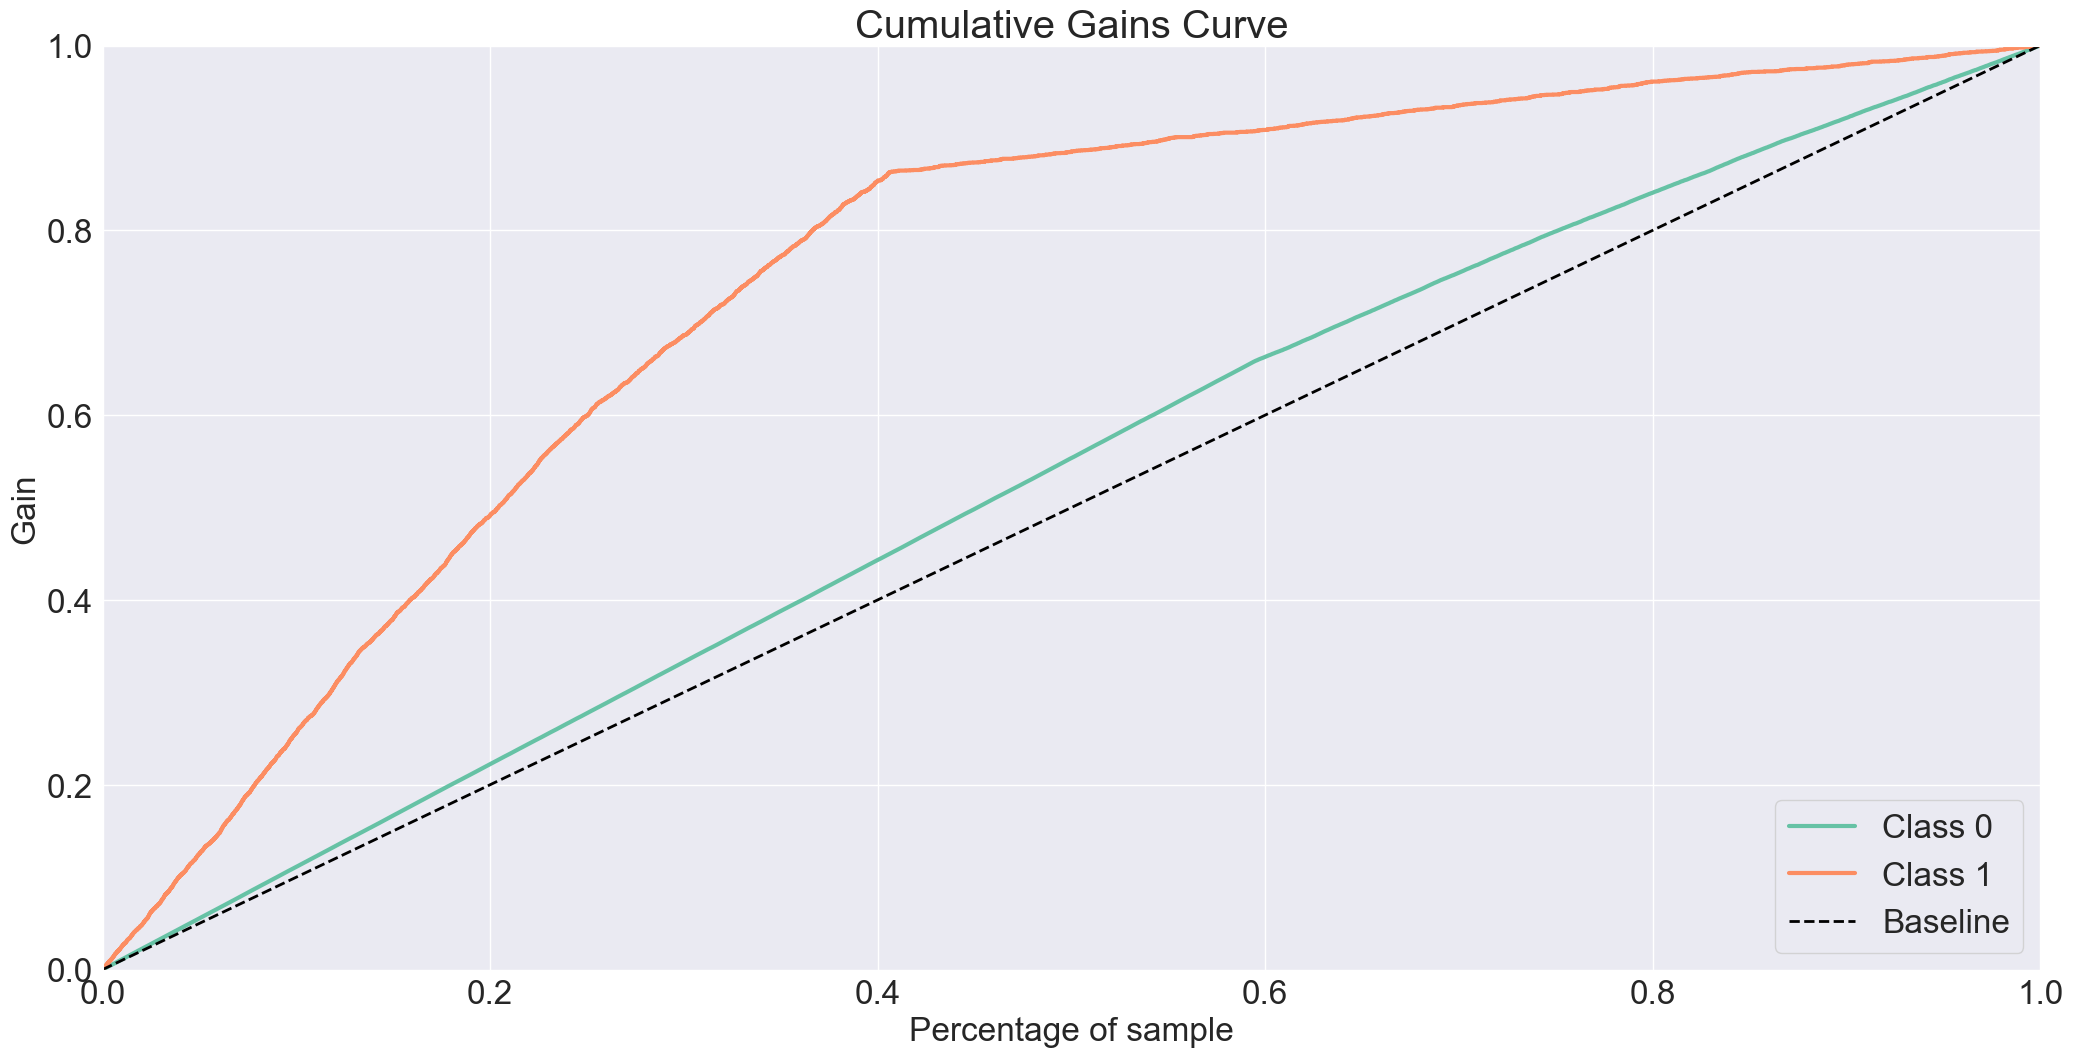

In [ ]:
# Accumulative Gain
# Mostra a proporção acumulada de amostras positivas à medida que a amostra é classificada em ordem decrescente de probabilidade
# Permite avaliar a eficácia do modelo em encontrar a maior proporção possível de amostras positivas no topo da lista classificada
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

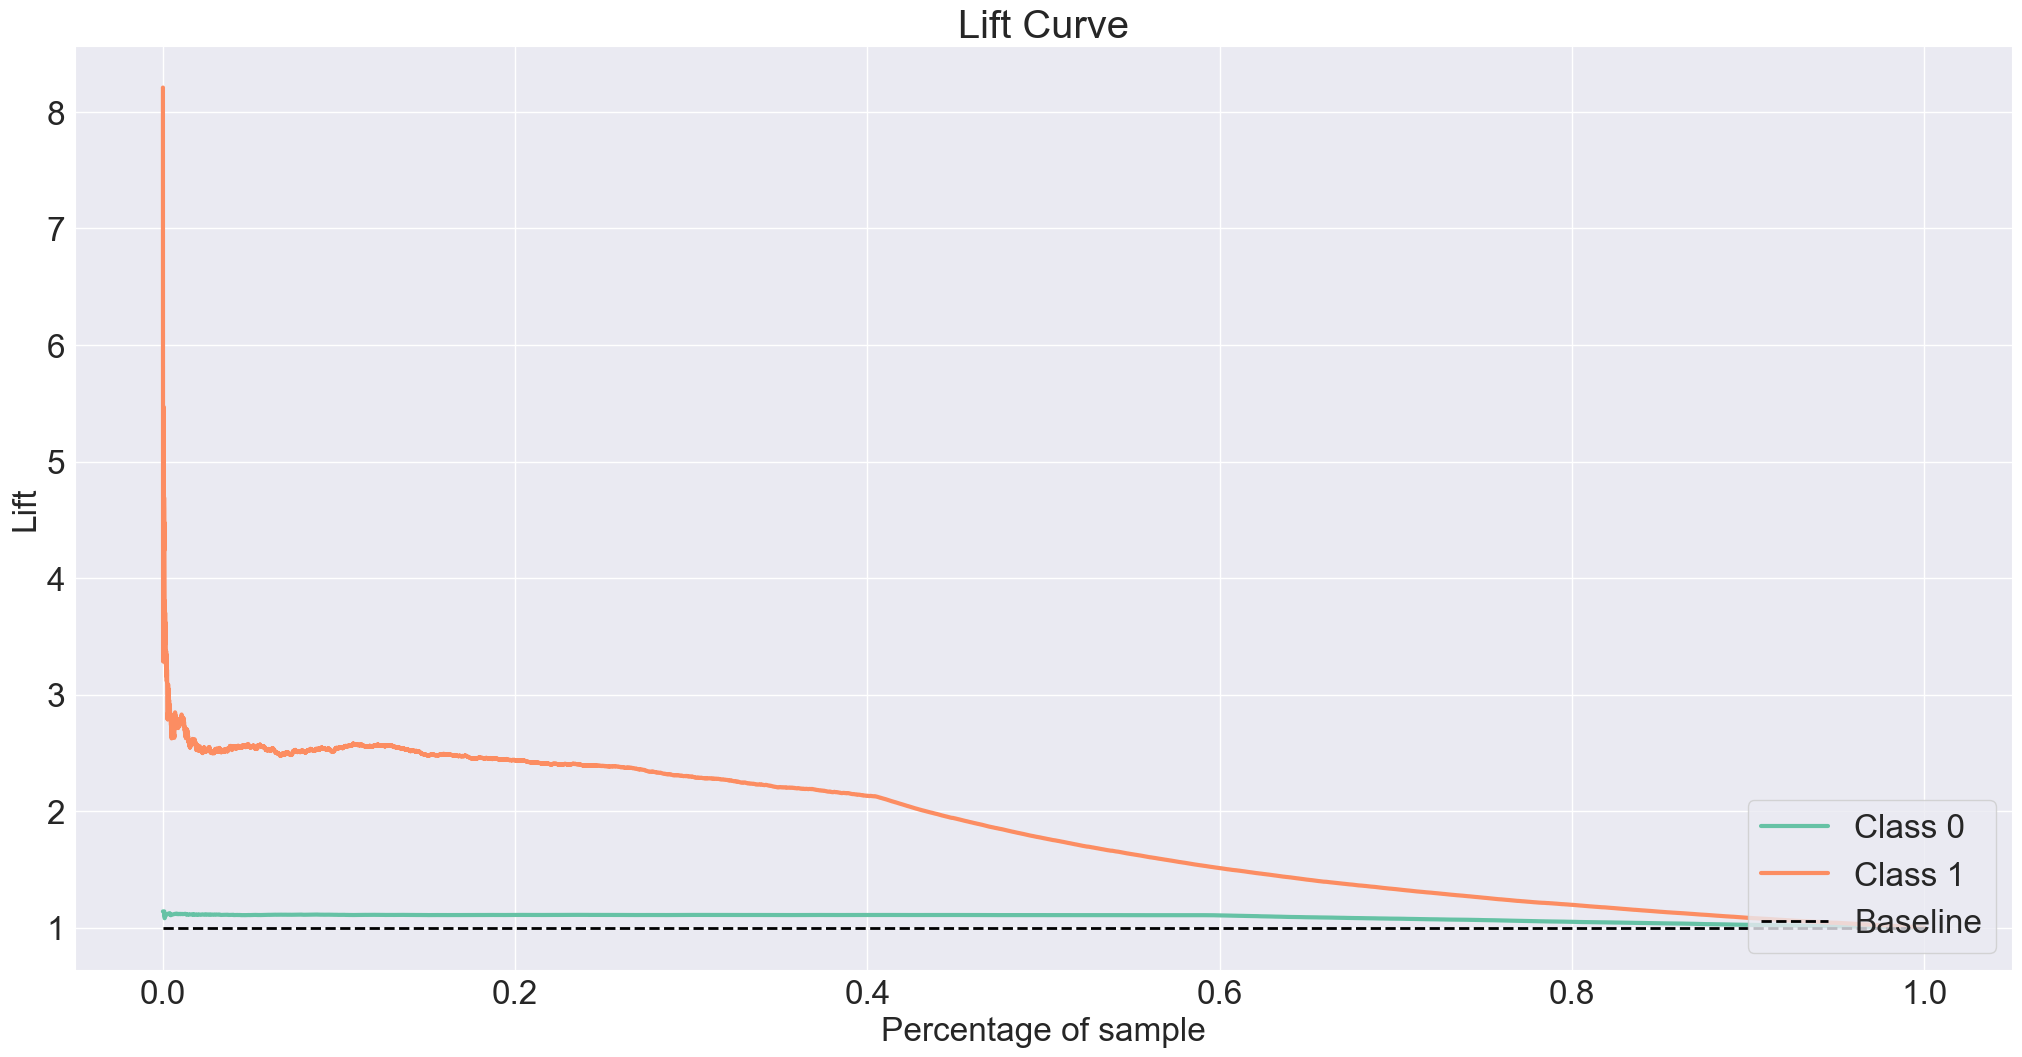

In [ ]:
# Lift Curve
# Mostra a proporção de amostras positivas em relação à proporção total de amostras classificadas. 
# Esse gráfico é útil para comparar a performance do modelo com um modelo aleatório.
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.2. Logistic Regression

In [ ]:
# Definição do modelo Logistic Regression
lr_model = lm.LogisticRegression(random_state=42) 

# Treinamento do modelo
lr_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_lr = lr_model.predict_proba(x_val)


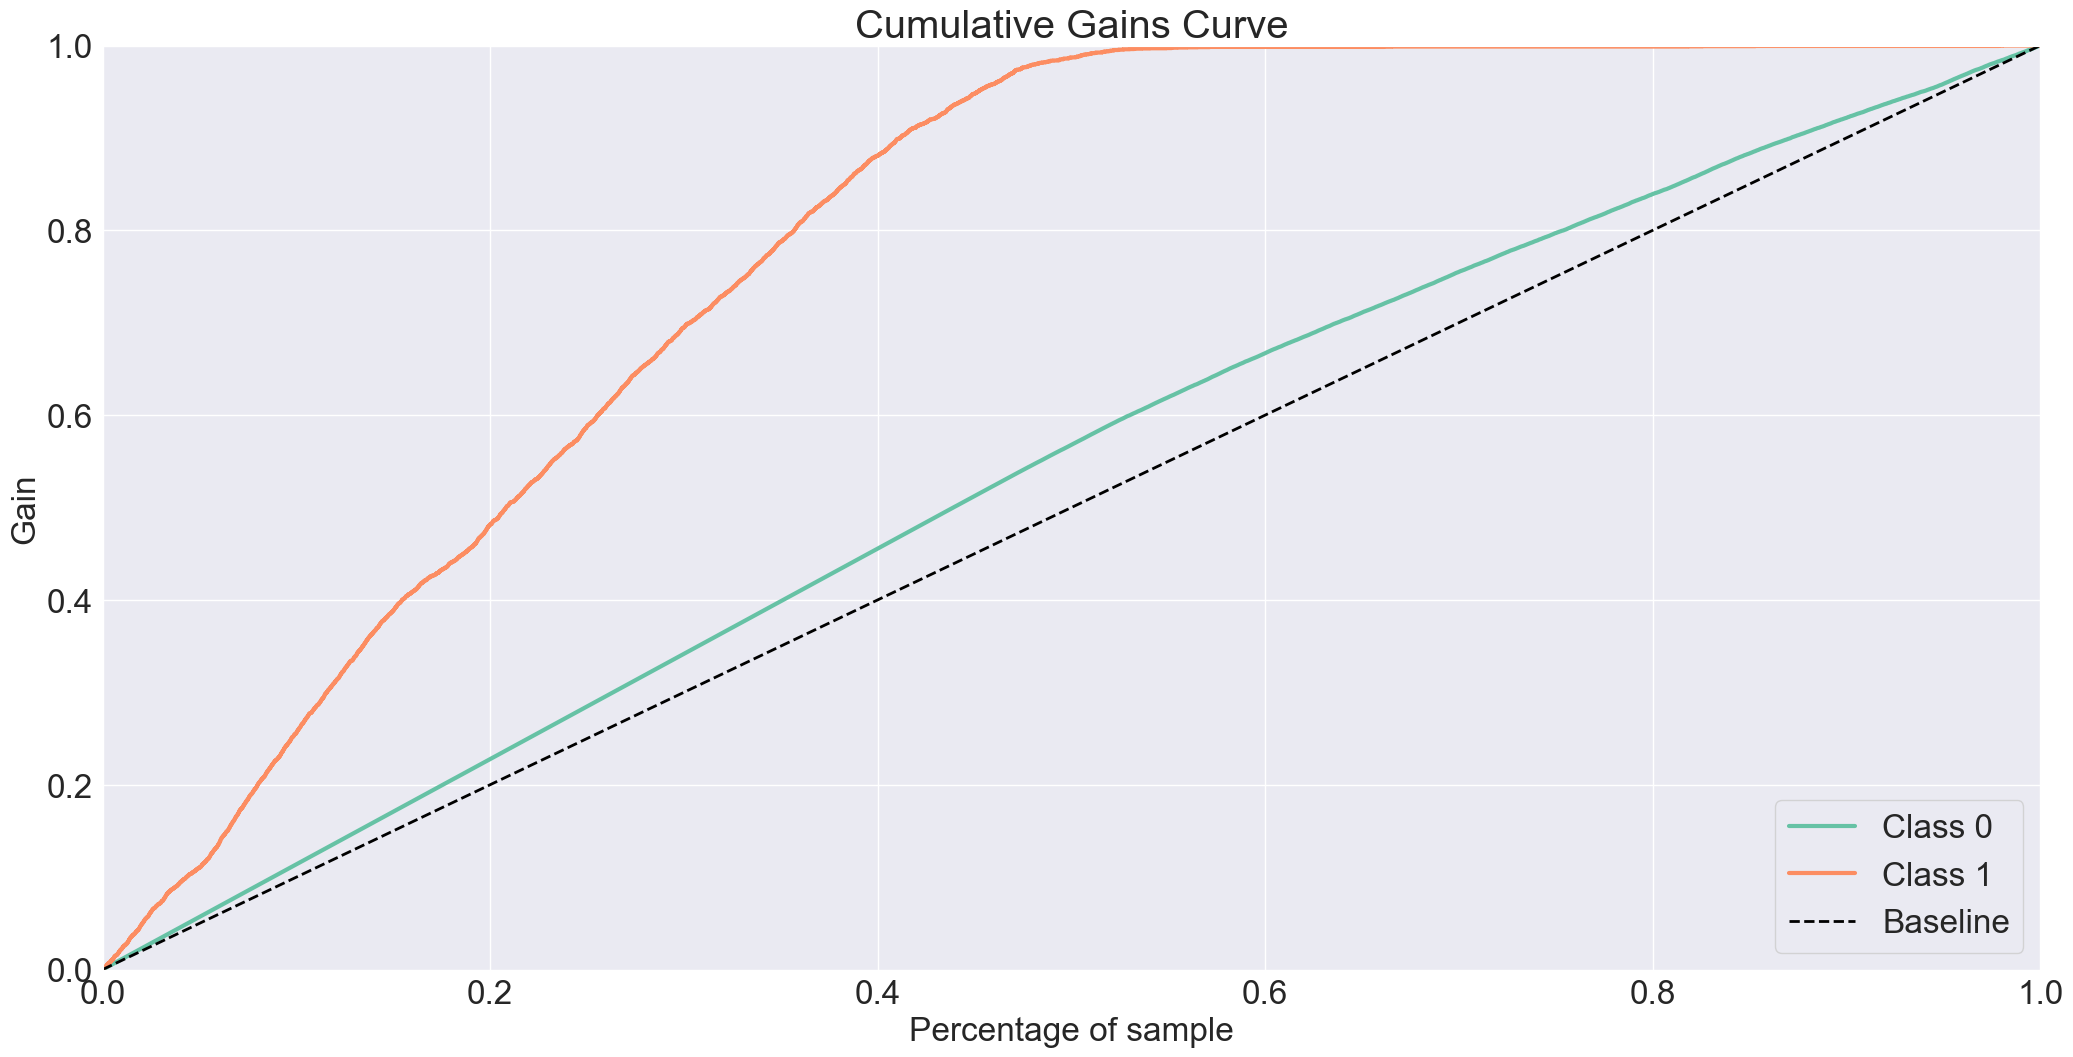

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

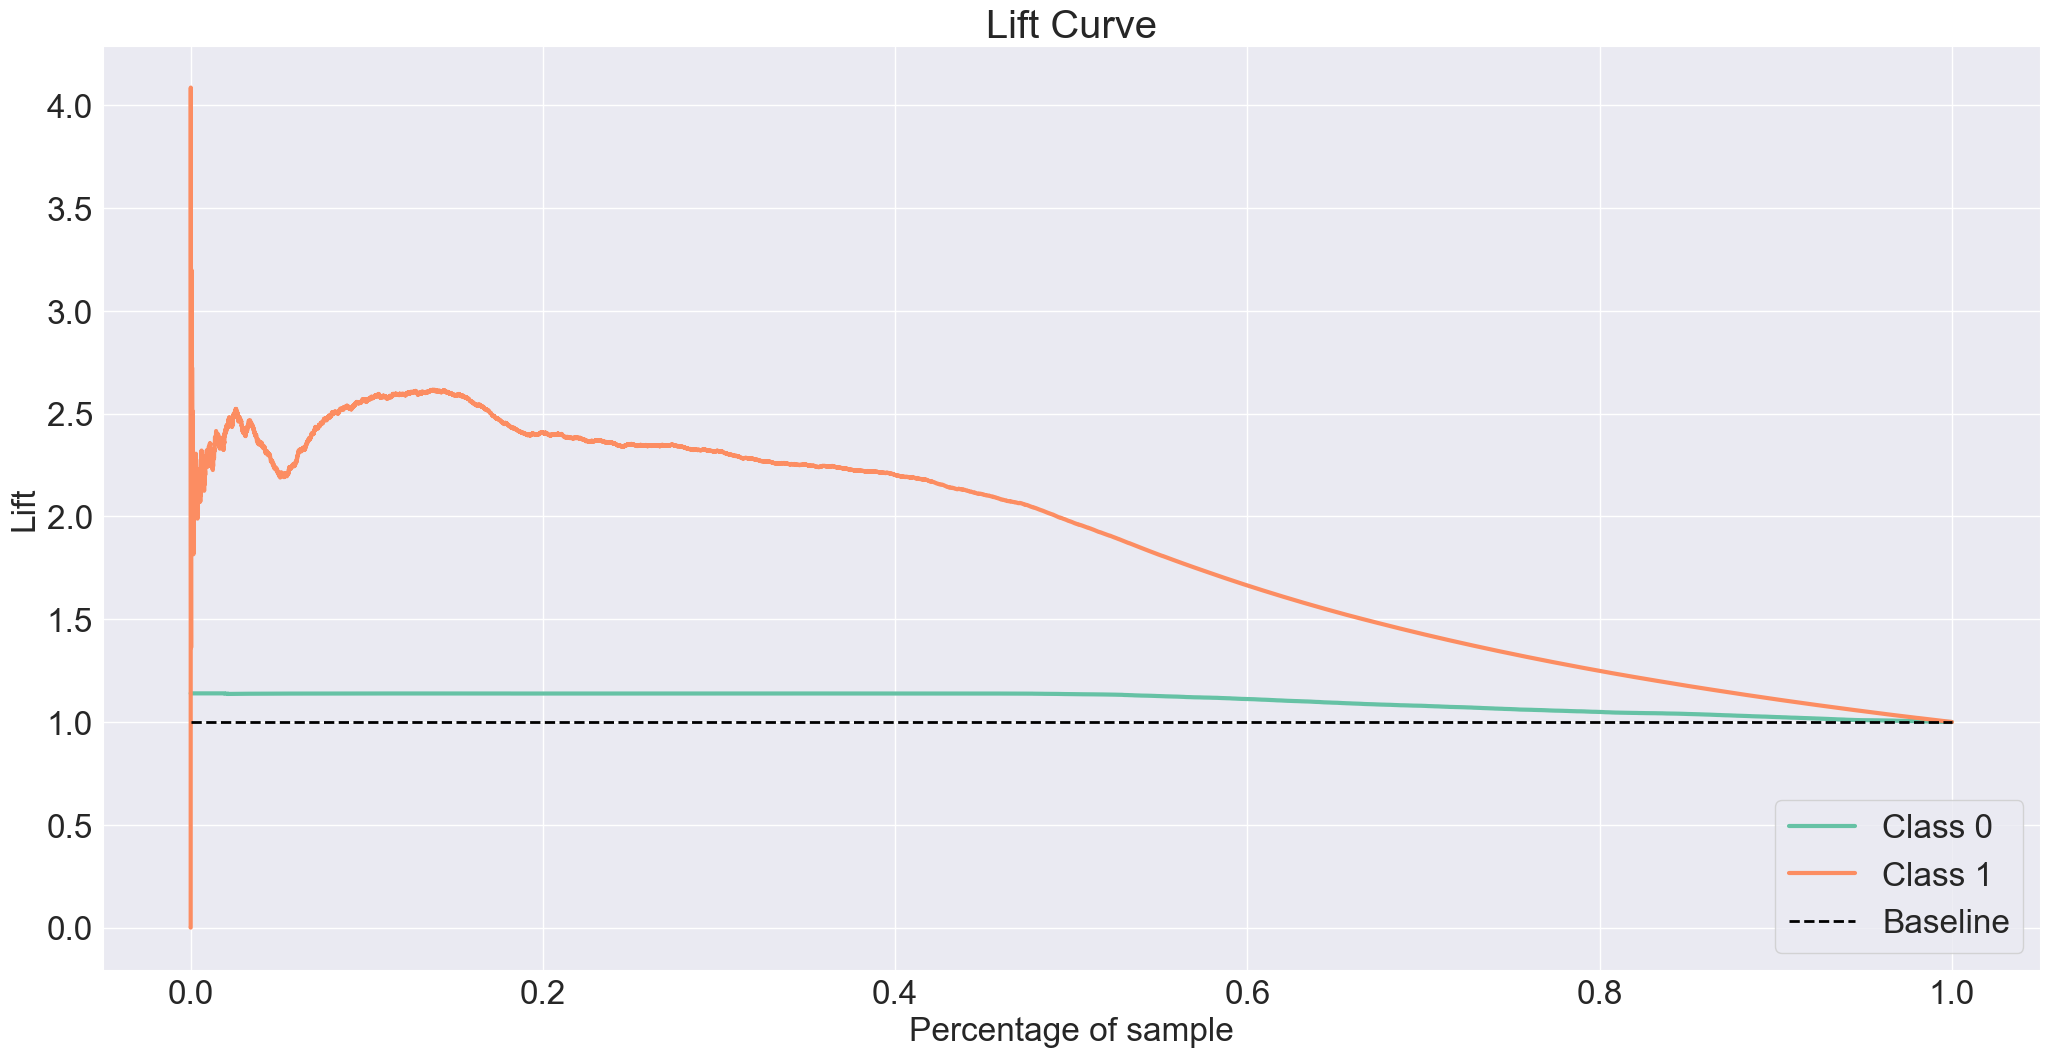

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.3. Extra Trees Classifier

In [ ]:
# Definição do modelo Extra Trees Classifier
et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
et_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_et = et_model.predict_proba(x_val)


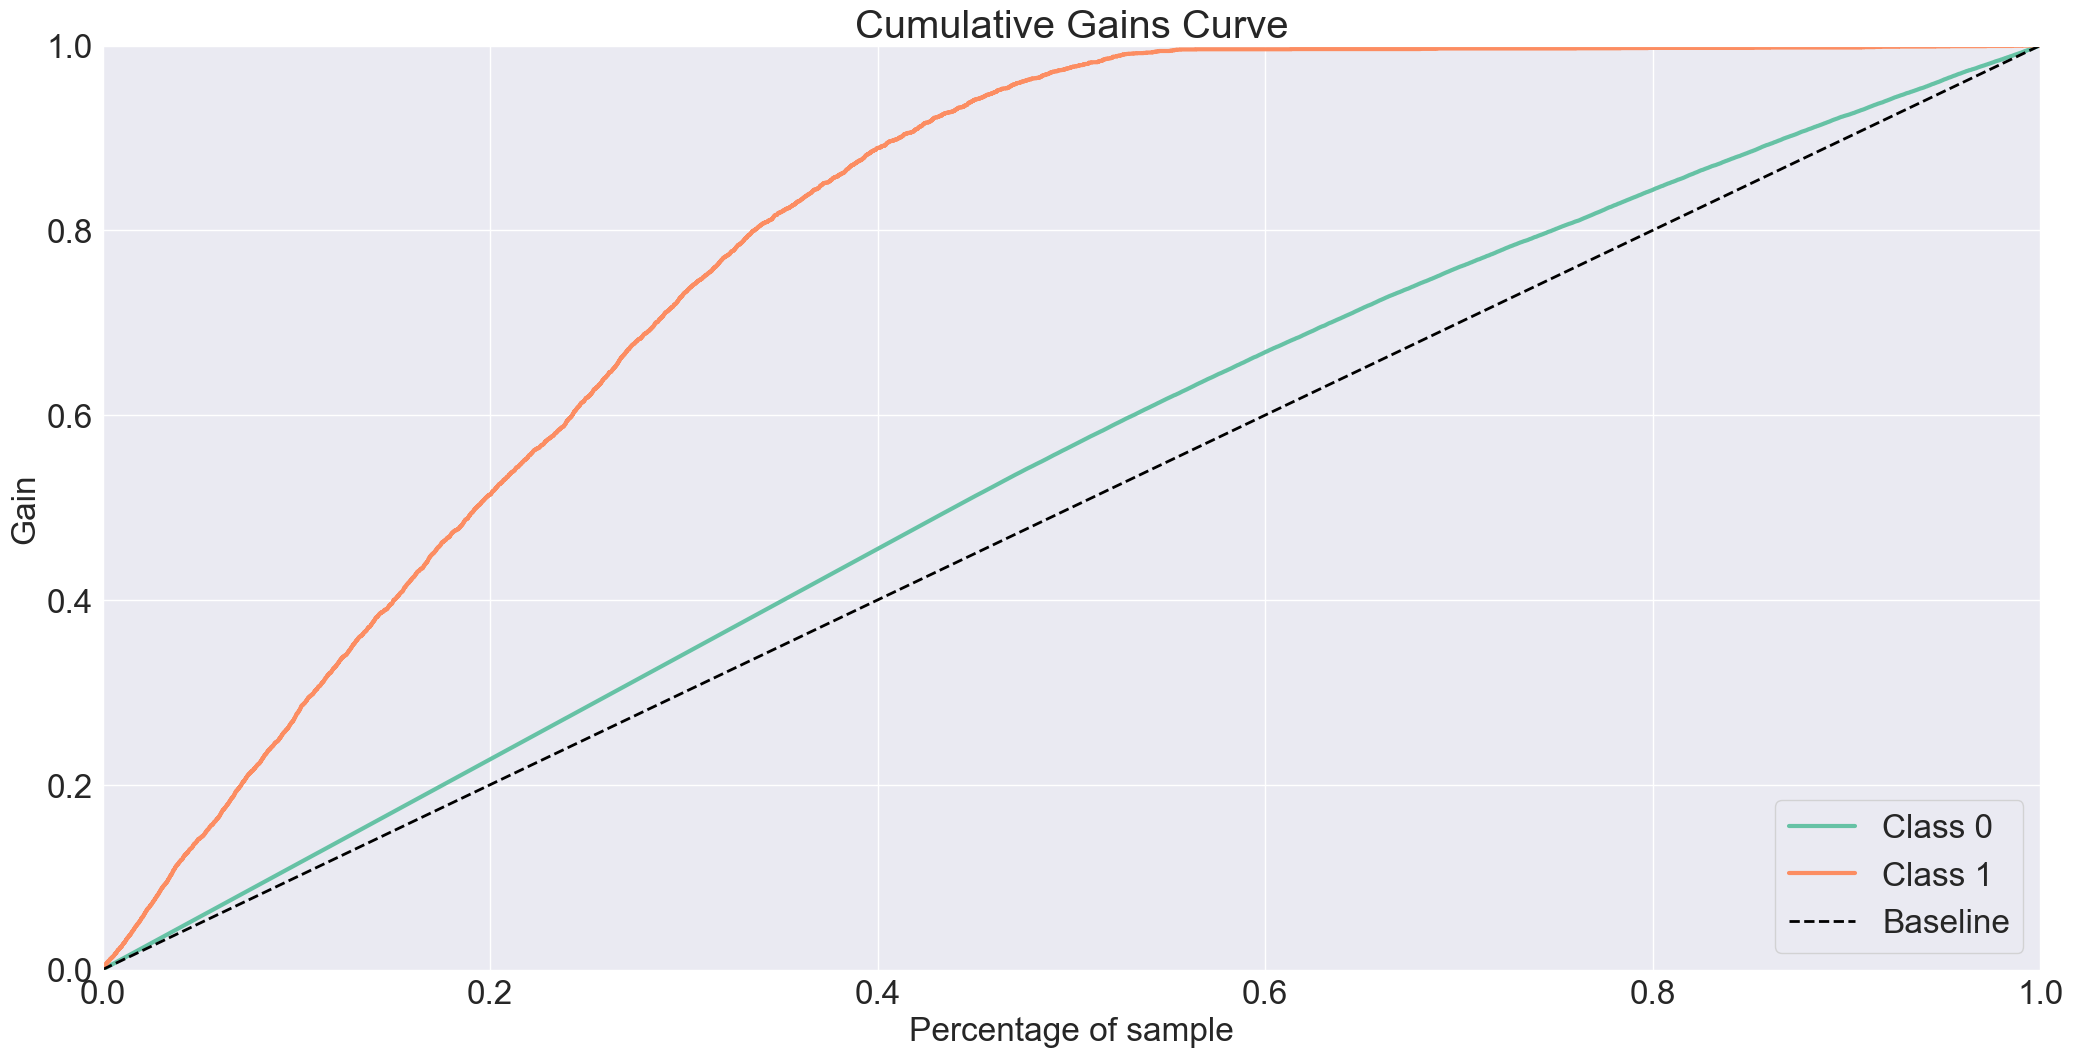

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

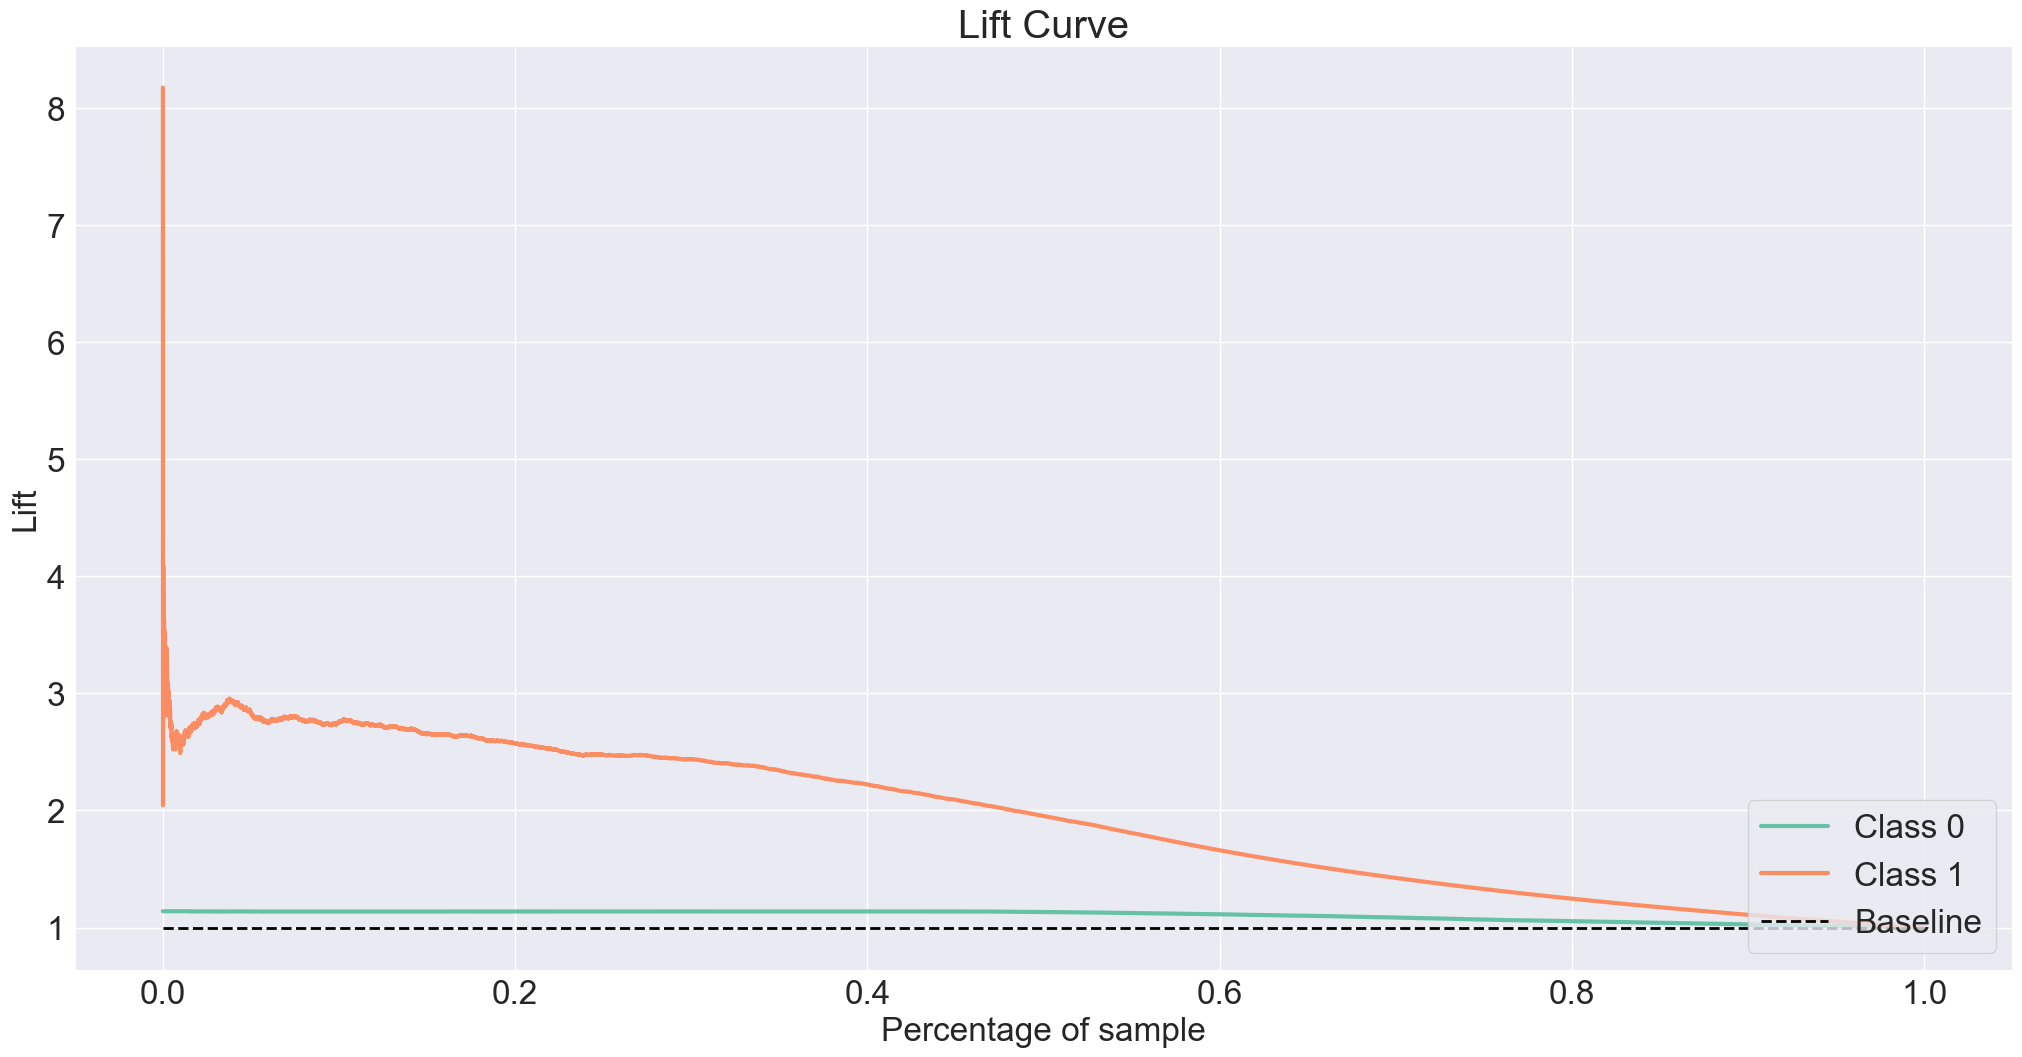

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [ ]:
# Definição do modelo Random Forest
rf_model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
rf_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_rf = rf_model.predict_proba(x_val)

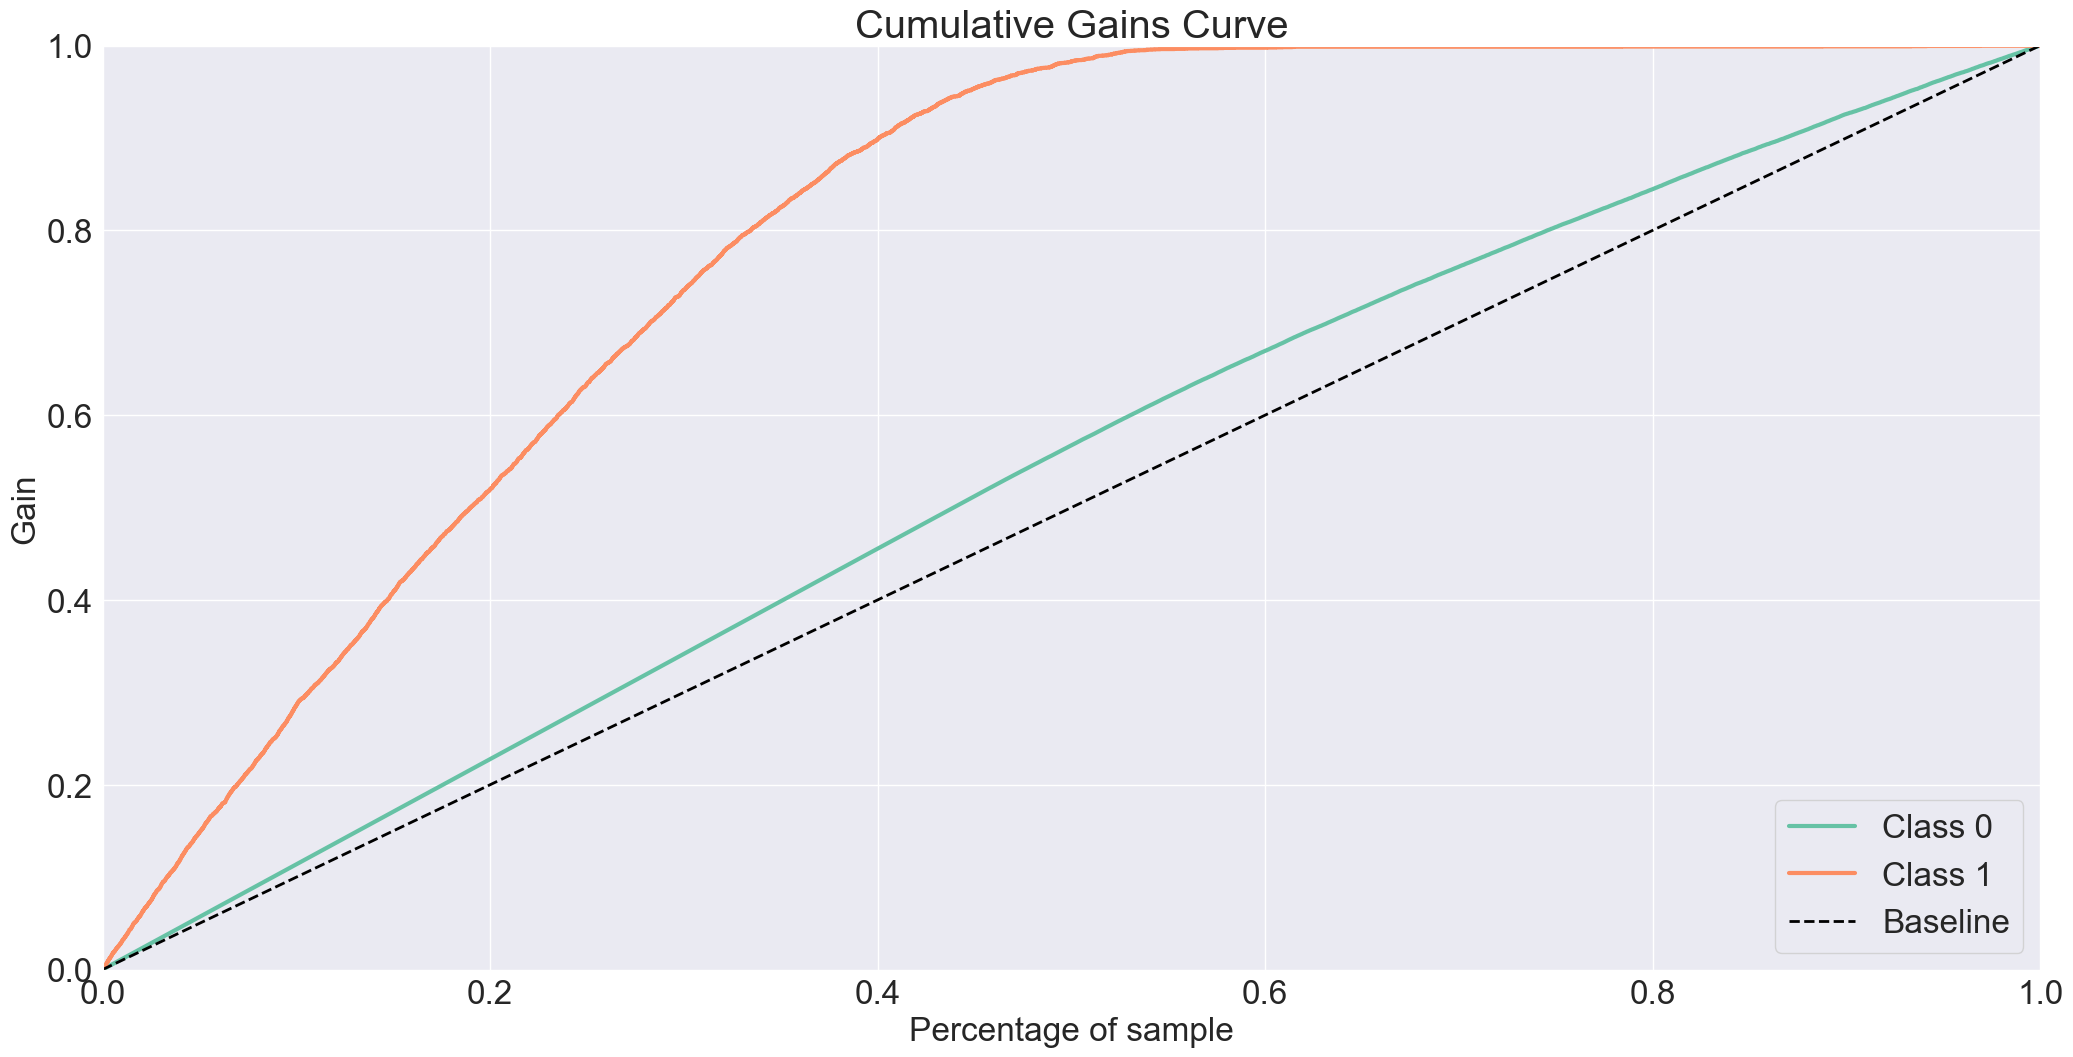

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

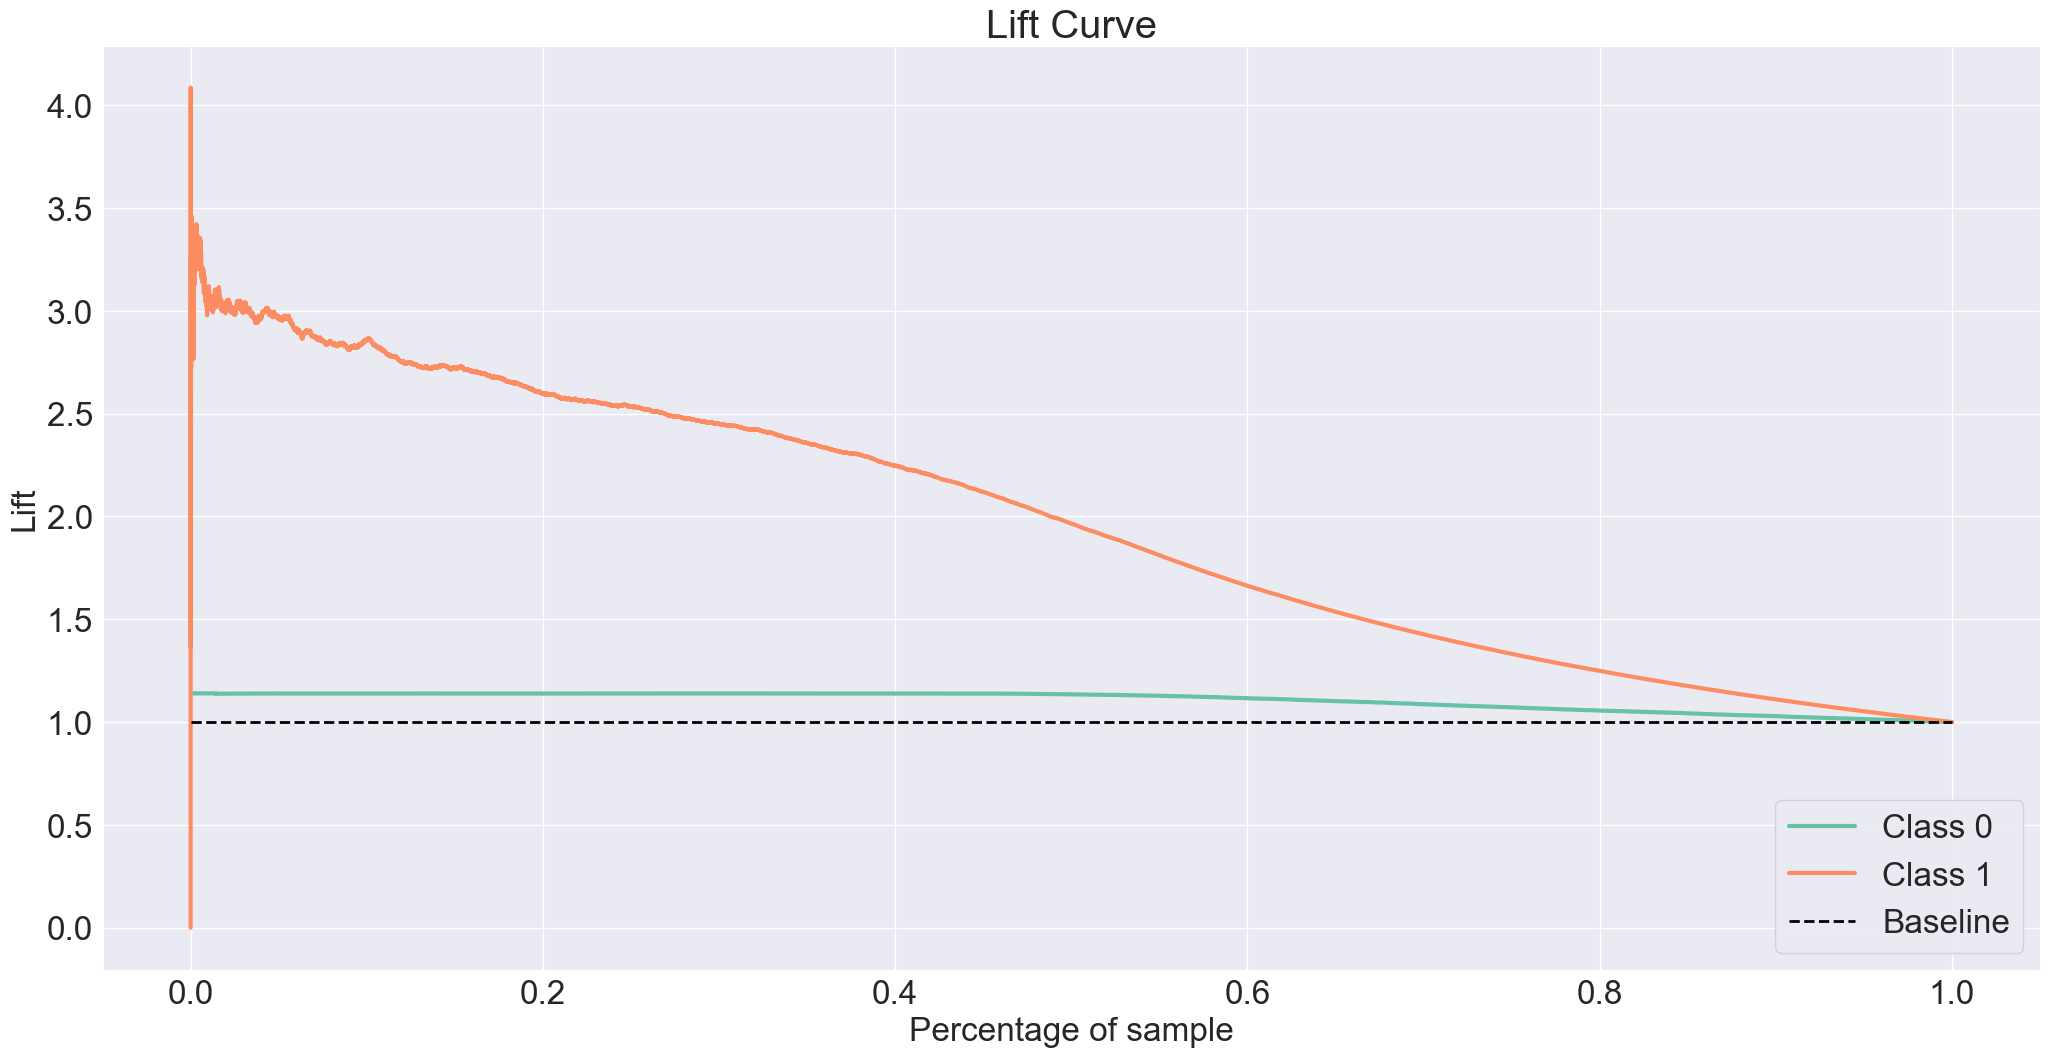

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

## 7.5. XGBoost

In [ ]:
# Definição do modelo XGBoost
xgb_model = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
xgb_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_xgb = xgb_model.predict_proba(x_val)

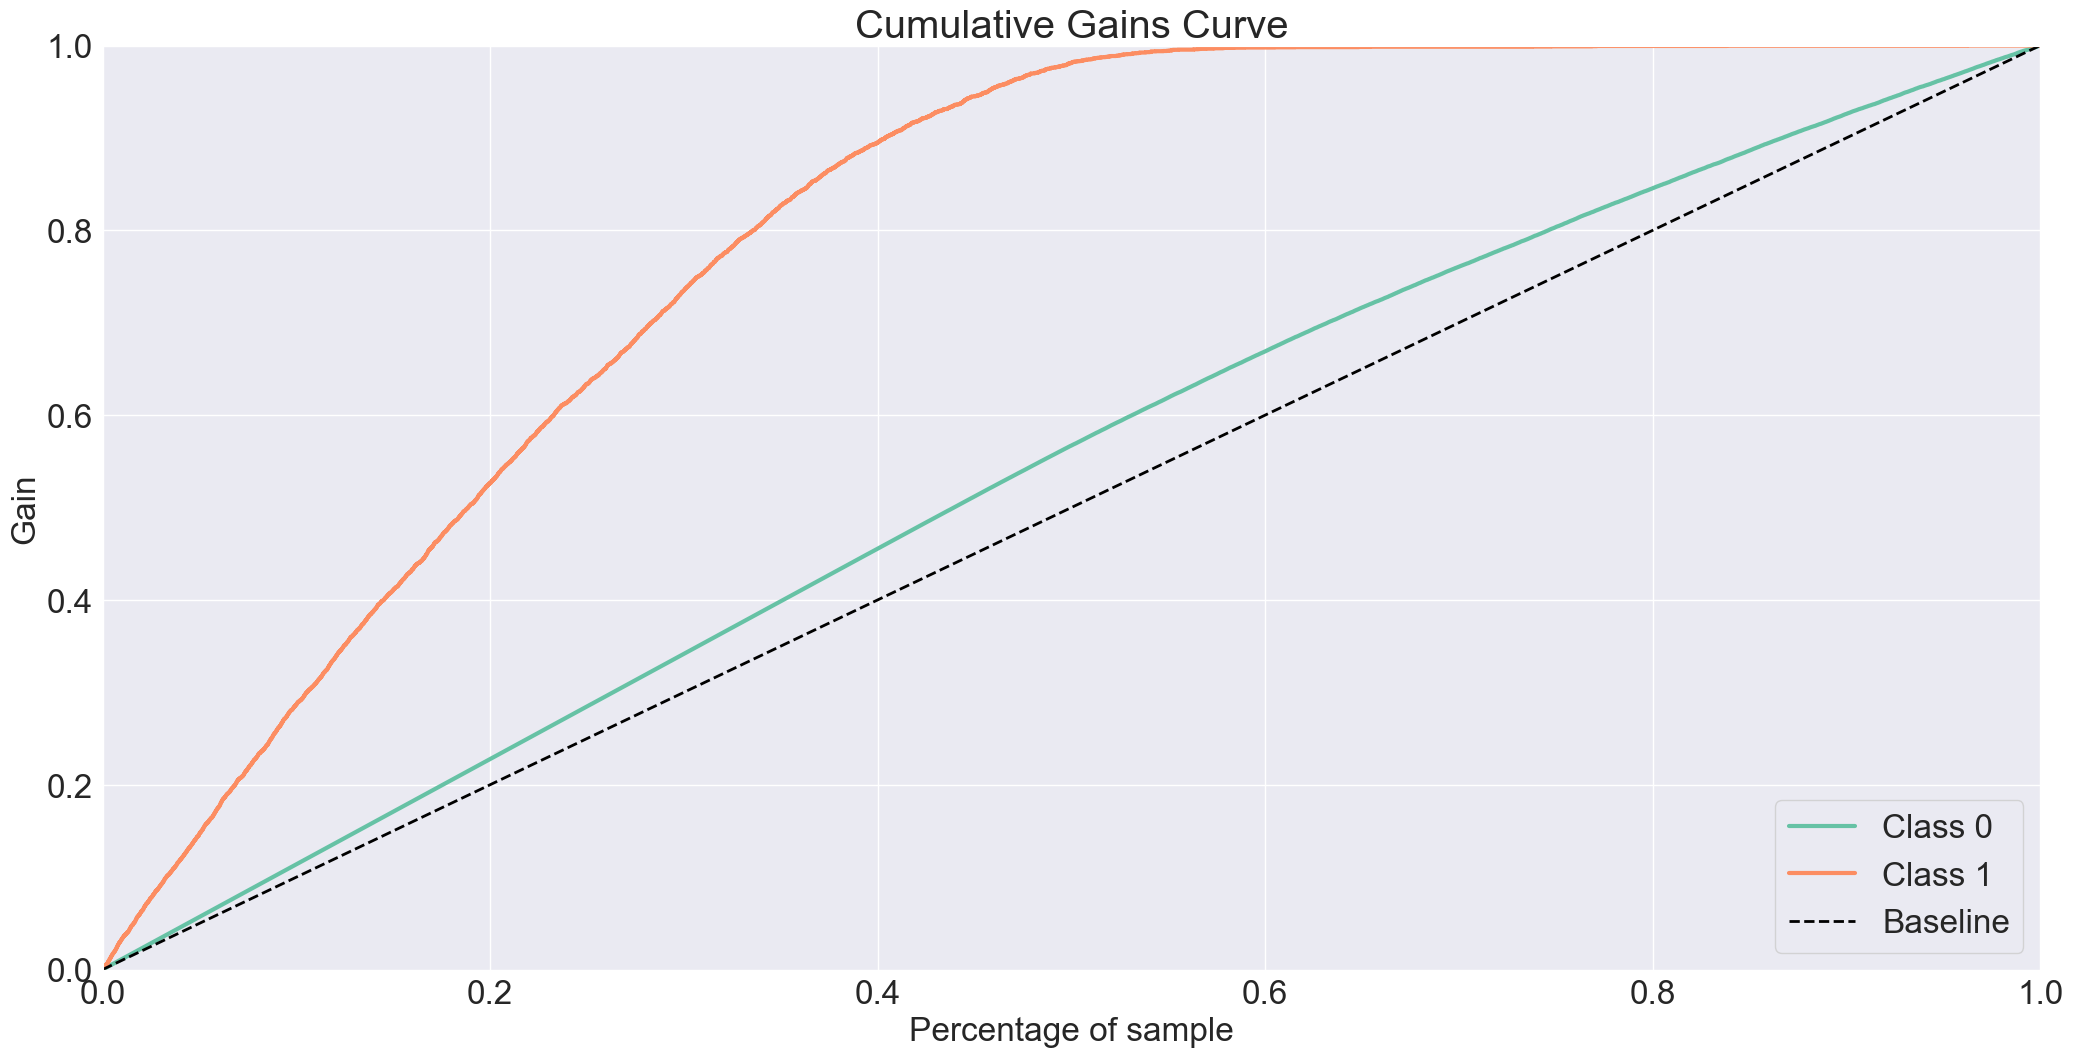

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

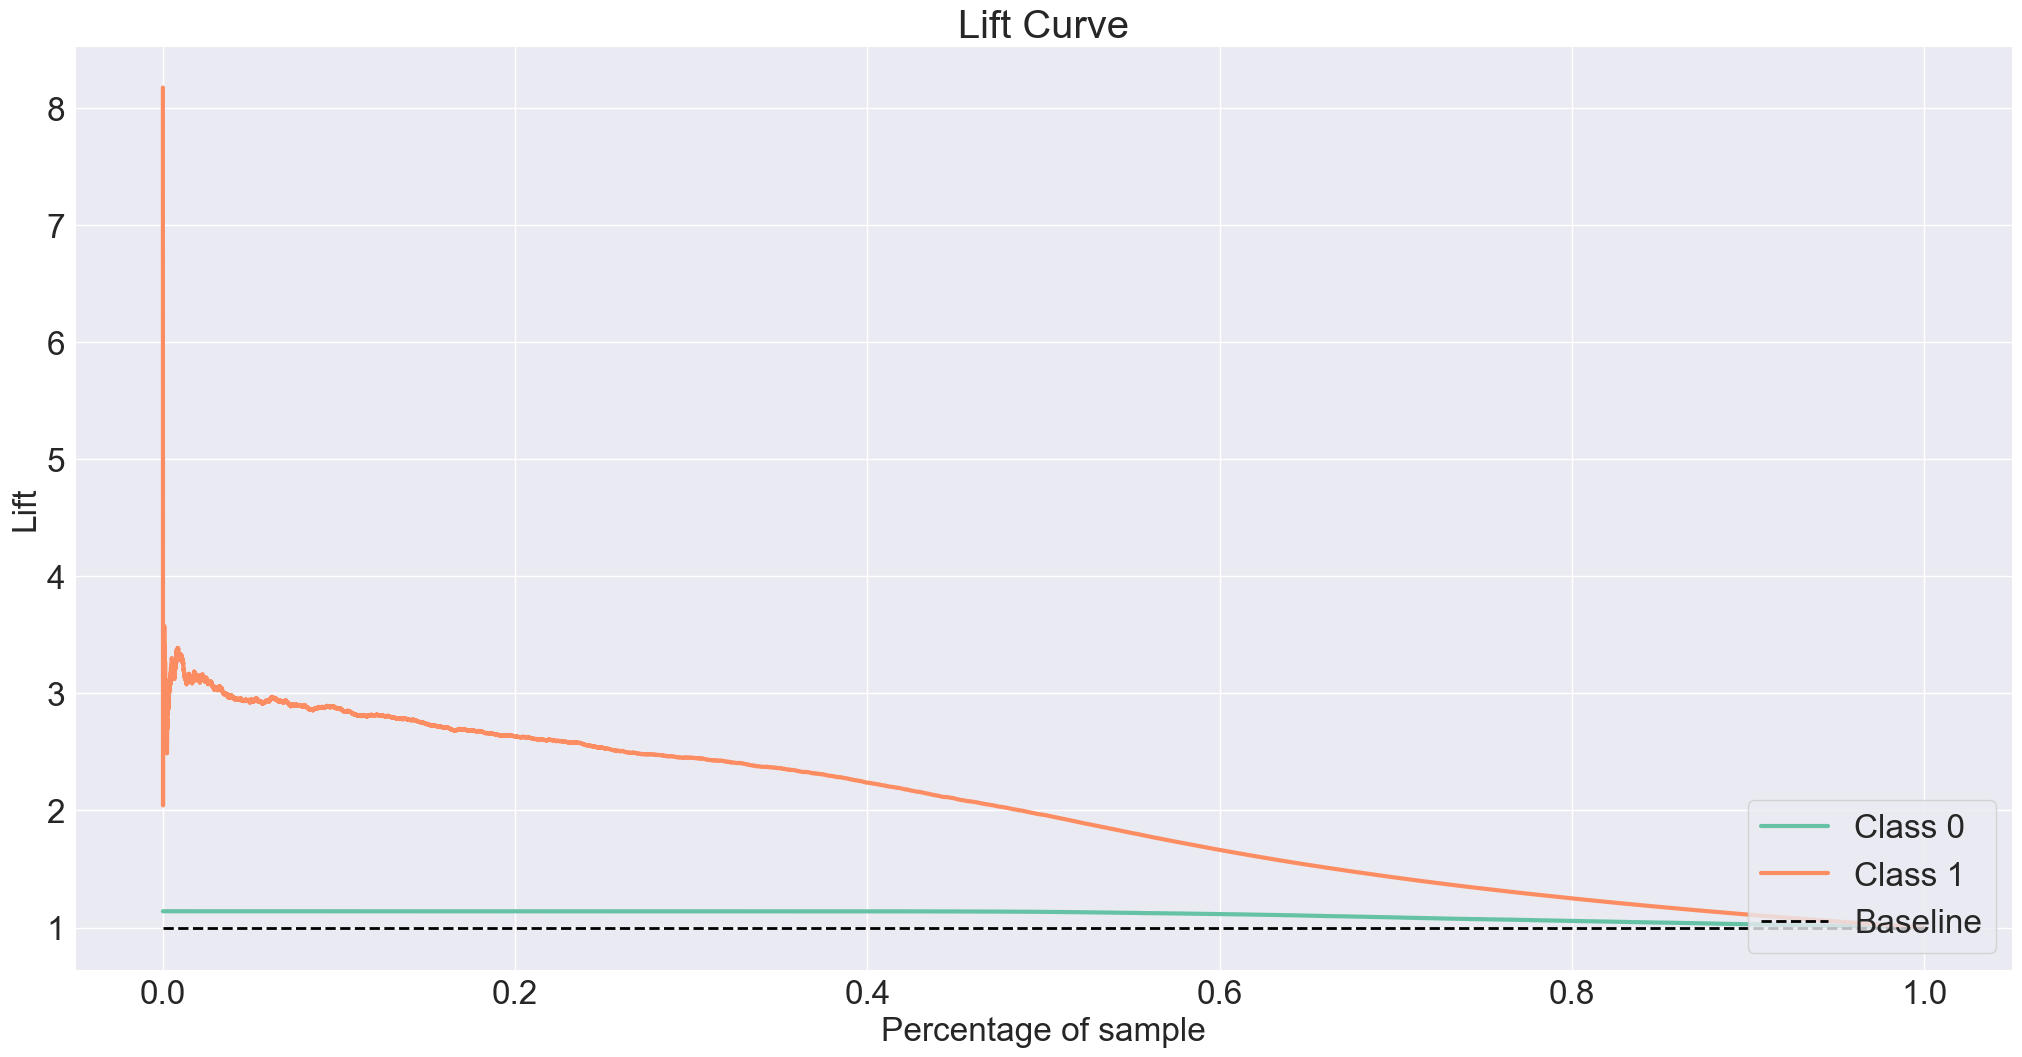

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb);

## 7.6. LGBM

In [ ]:
# Definição do modelo lgbm
lgbm_model = LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
lgbm_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_lgbm= lgbm_model.predict_proba(x_val)

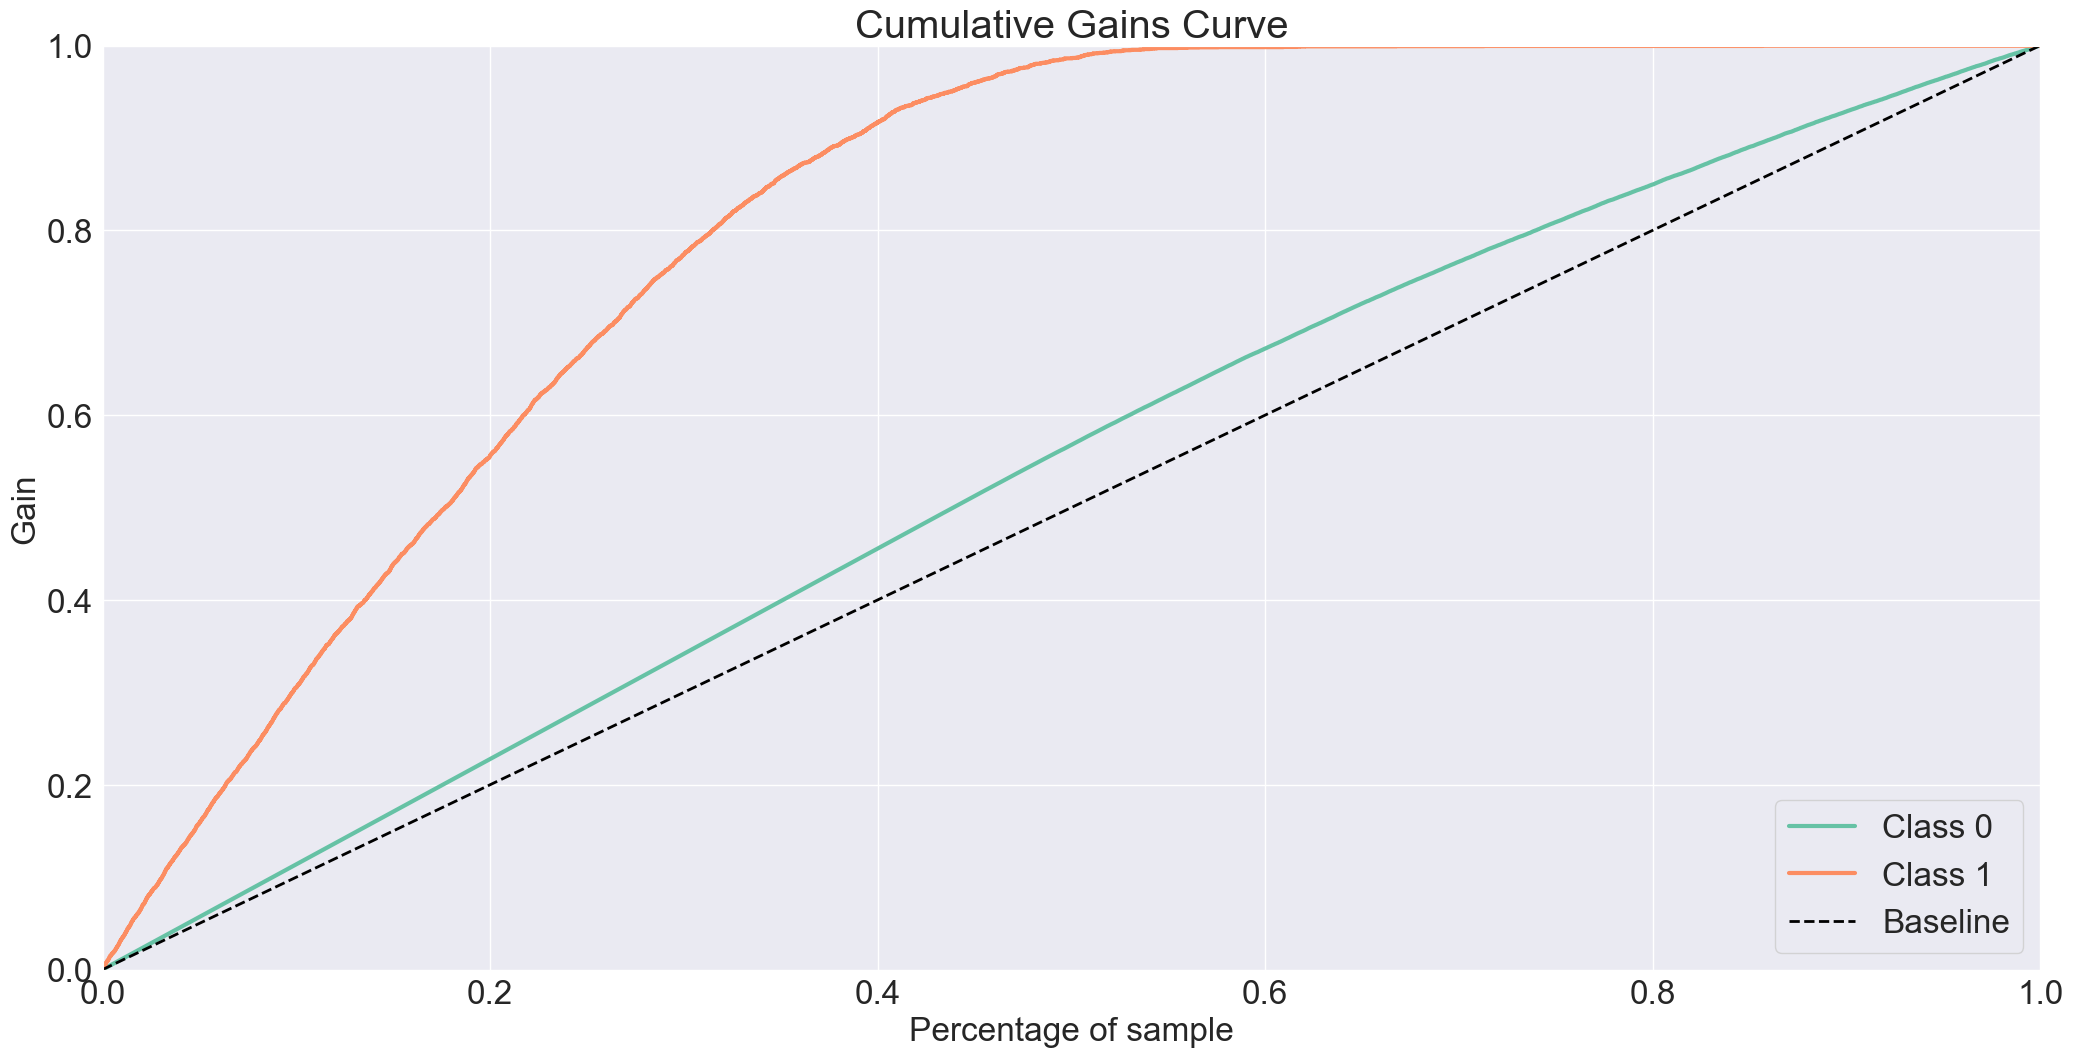

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

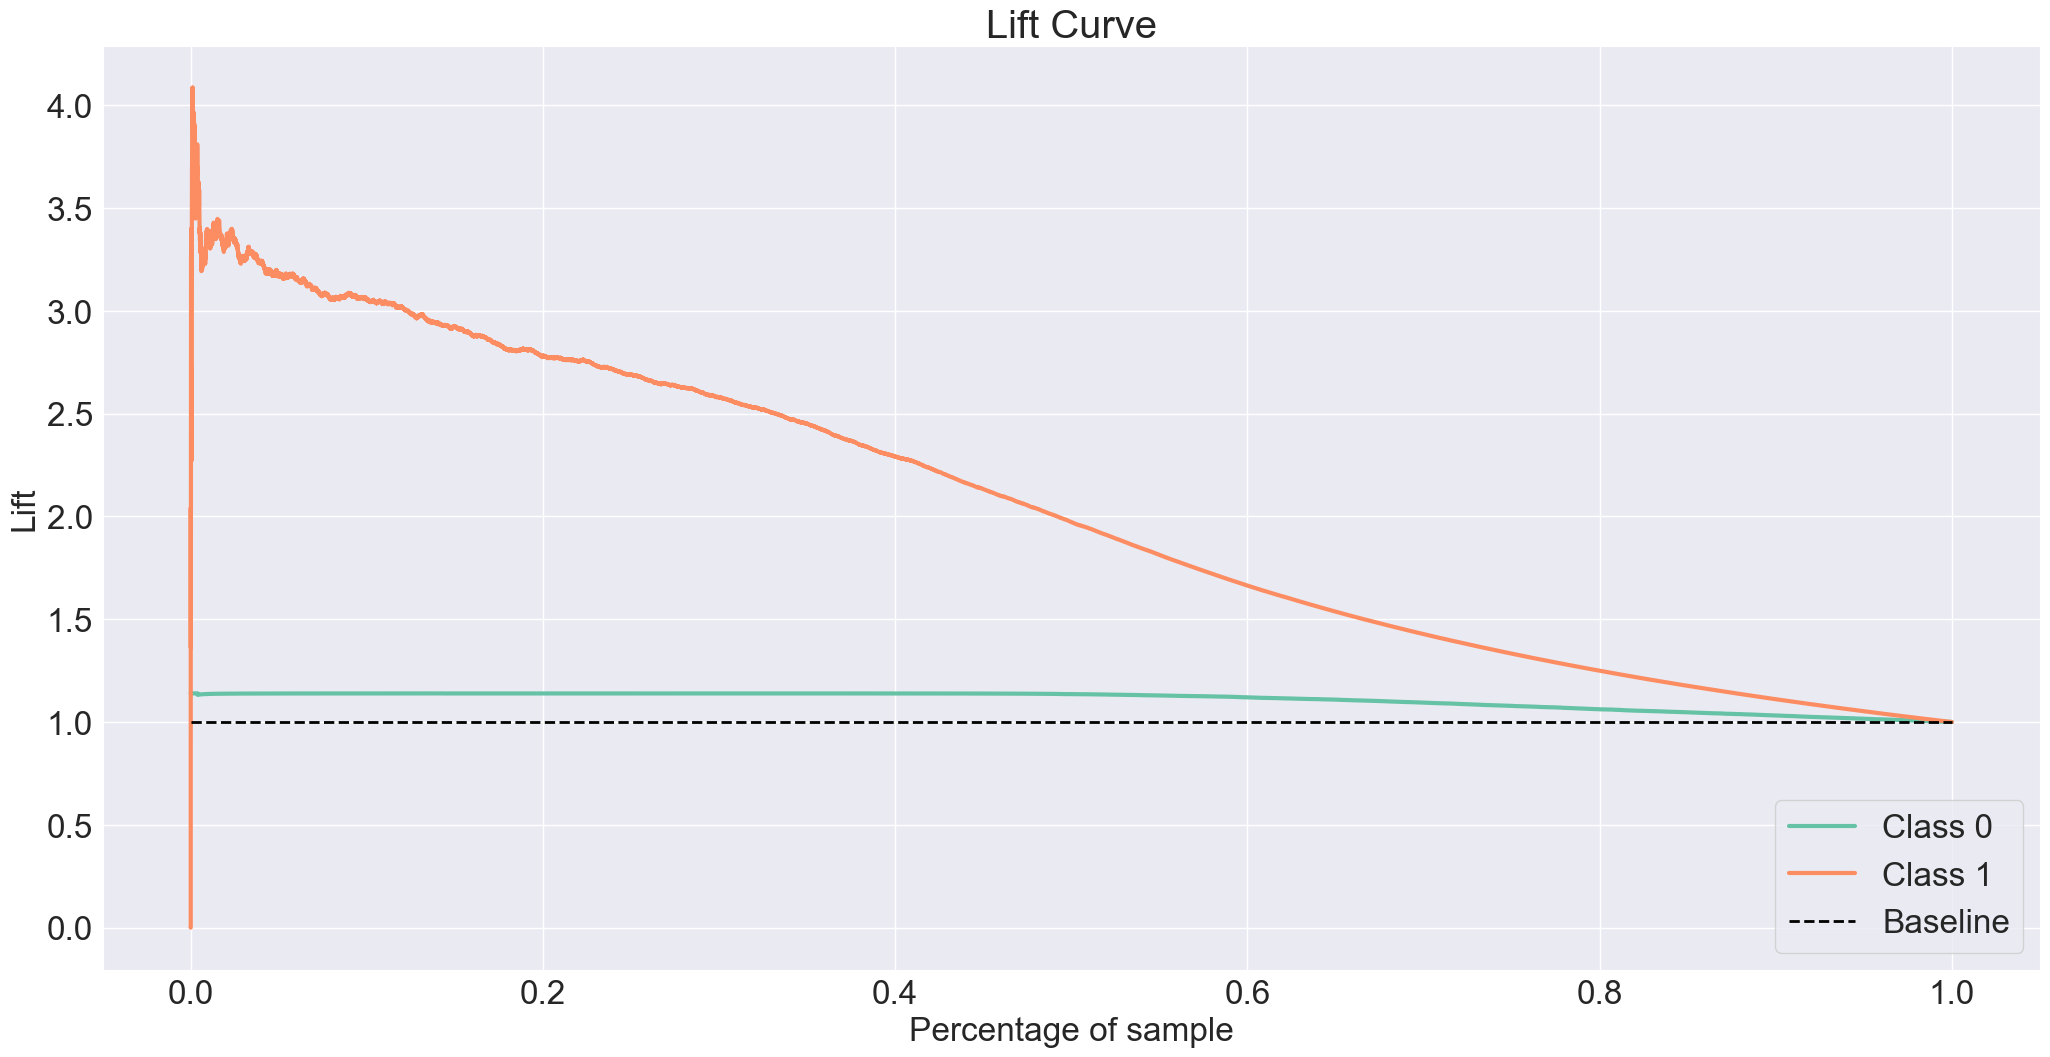

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm);

## 7.7. CatBoost

In [ ]:
# Definição do modelo CatBoost
cat_model = CatBoostClassifier(verbose=False, random_seed=42)

# Treinamento do modelo
cat_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_cat = cat_model.predict_proba(x_val) 

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

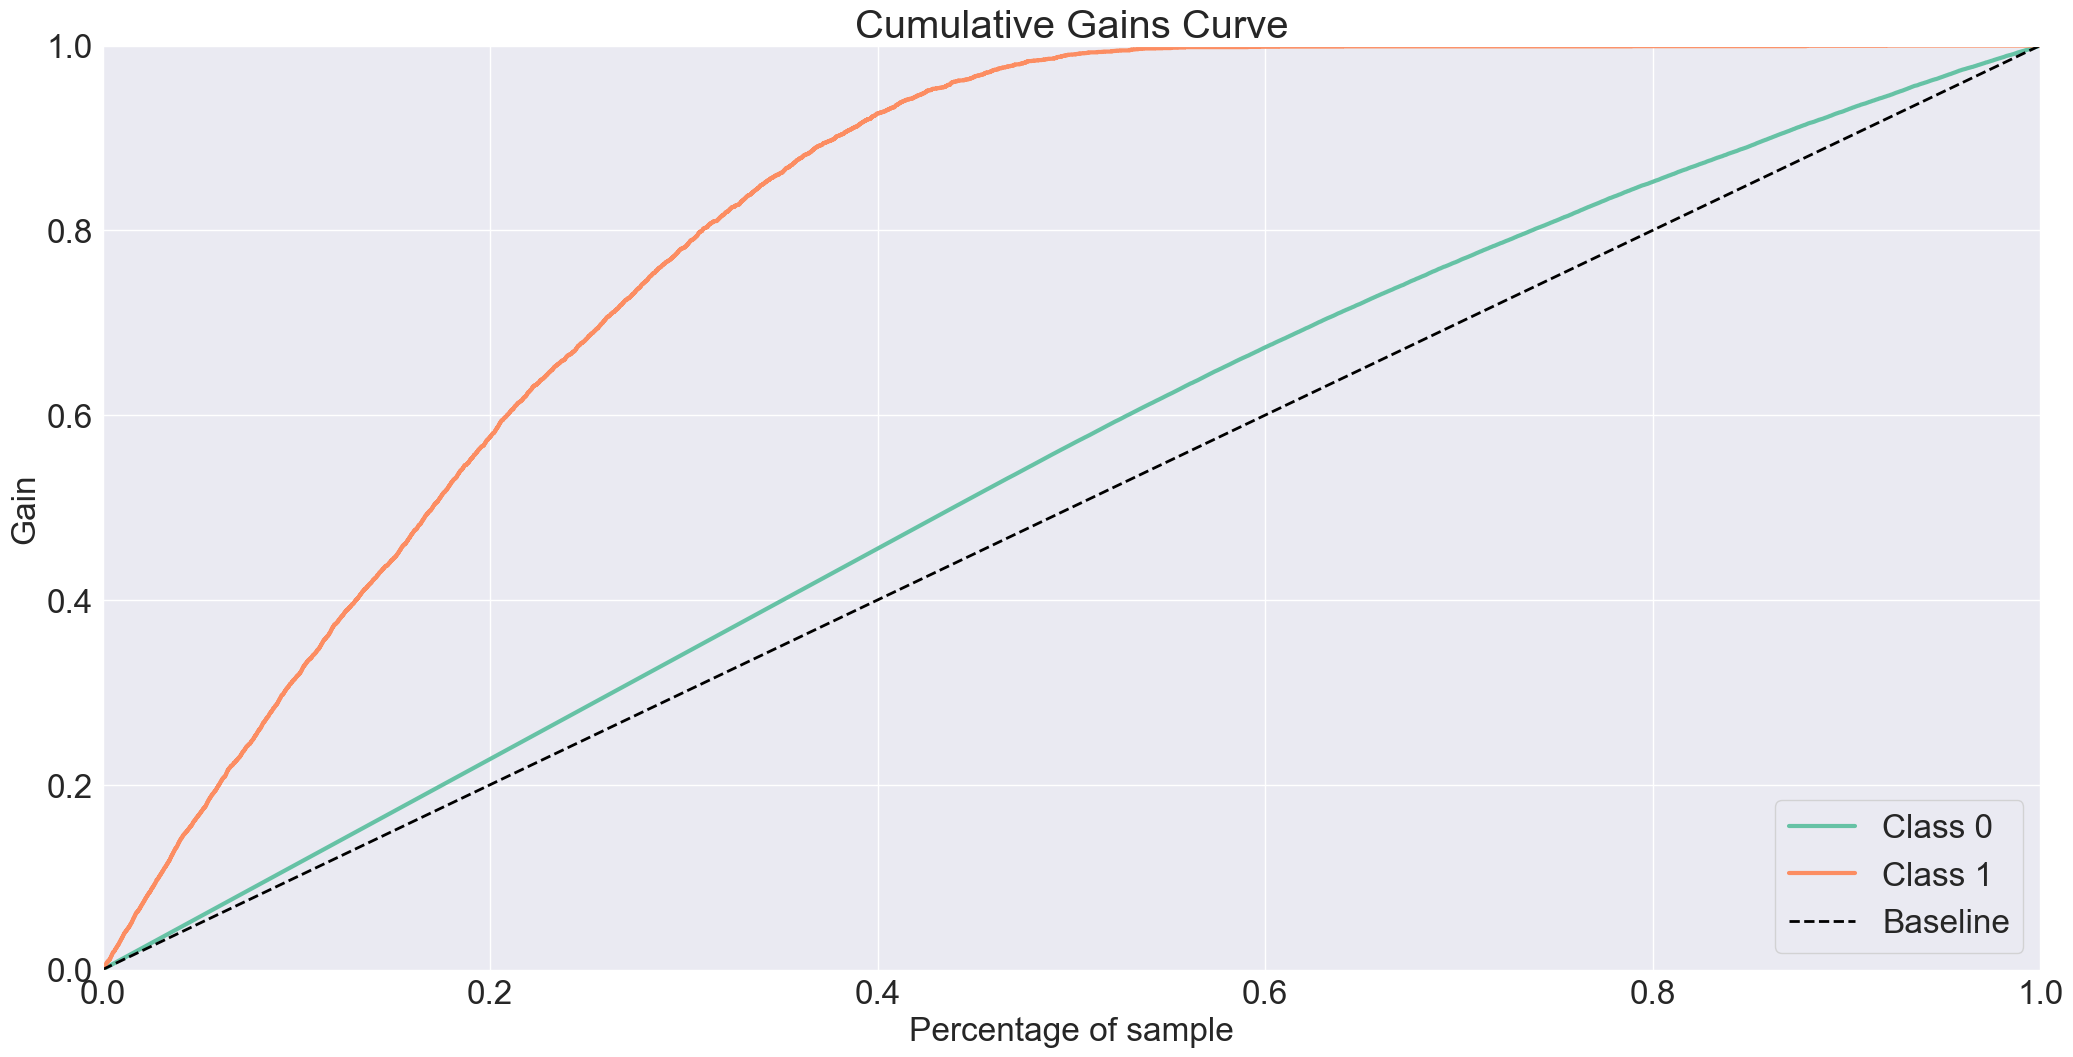

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_cat)

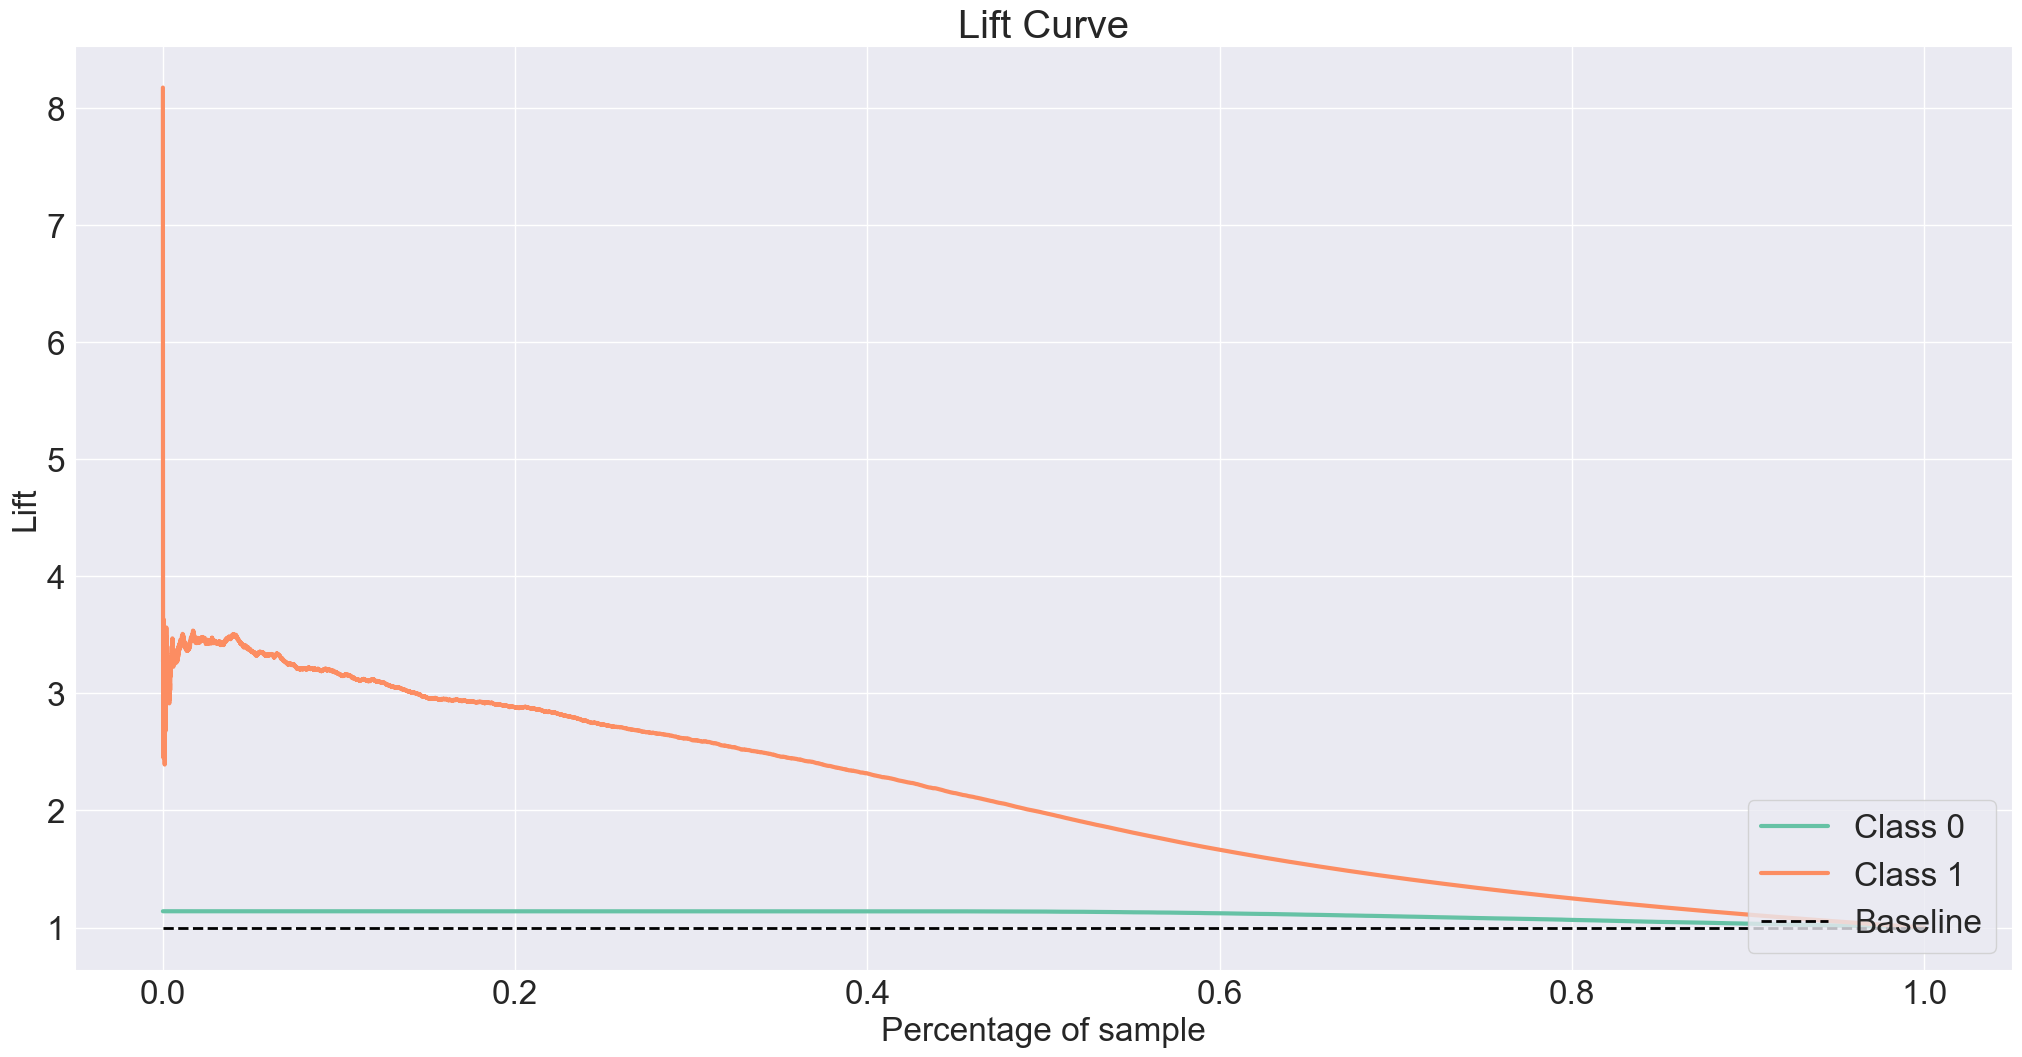

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_cat);

## 7.8. Compare Model's Performance

### 7.8.1. Single Perfomance

In [ ]:
models = [knn_model, lr_model, et_model, rf_model, xgb_model, lgbm_model, cat_model]

In [ ]:
# Calcula as métricas de desempenho para cada modelo
metrics_results = calculate_metrics(models, x_train, y_train, x_val, y_val)

# Cria um DataFrame com os resultados das métricas
df_metrics_results = pd.DataFrame(metrics_results)

df_metrics_results

#### 7.8.1.1. Accumulative Gain

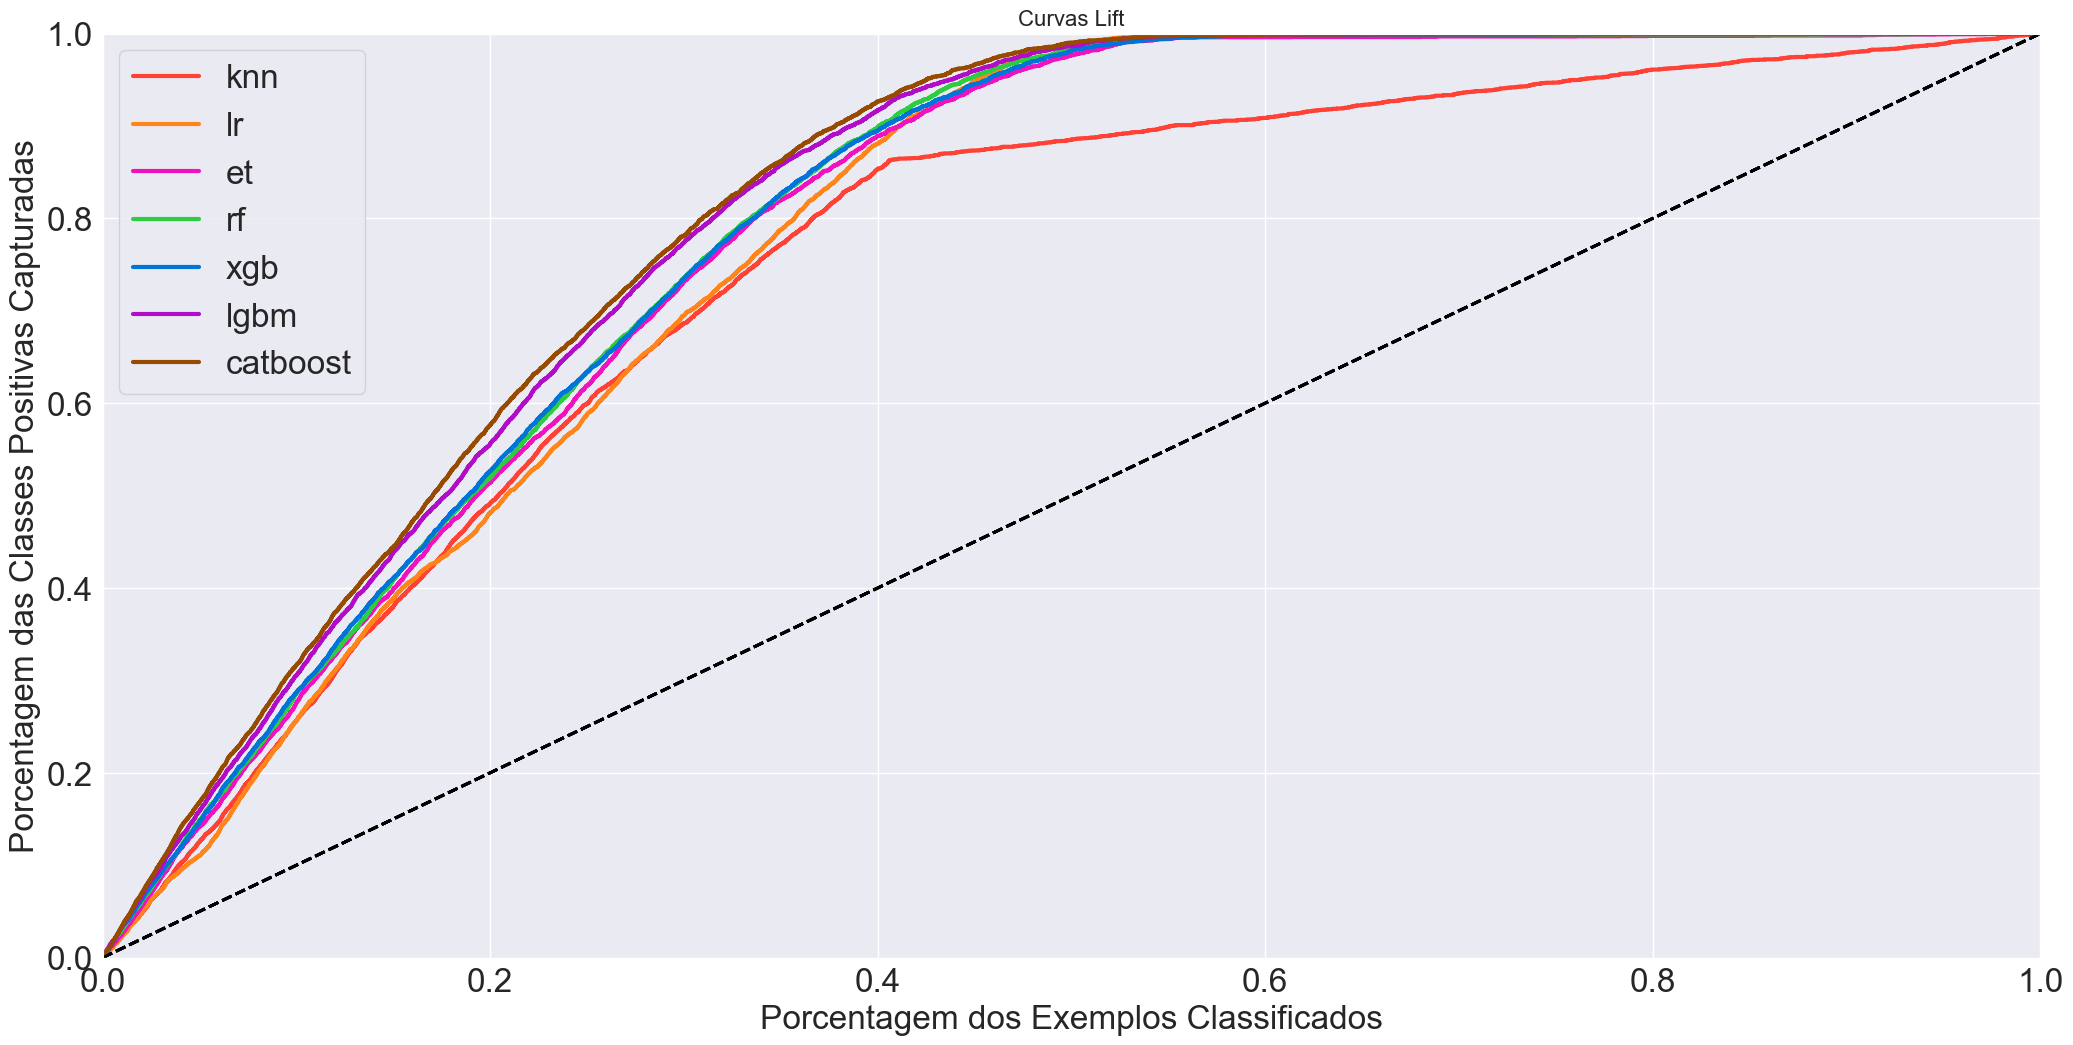

In [ ]:
# Define uma paleta de cores personalizada para os gráficos
colors = ['#FF4136', '#FF4136', '#FF851B', '#FF851B', '#F012BE', '#F012BE', '#2ECC40', '#2ECC40', '#0074D9',
          '#0074D9', '#B10DC9', '#B10DC9', '#964B00', '#964B00', '#FFDC00', '#FFDC00', '#AAAAAA', '#AAAAAA']
sns.set_palette(palette=colors)

# Lista de modelos e rótulos correspondentes
models = [yhat_knn, yhat_lr, yhat_et, yhat_rf, yhat_xgb, yhat_lgbm, yhat_cat]
model_labels = ['knn', 'lr', 'et', 'rf', 'xgb', 'lgbm', 'catboost']

# Cria uma figura e eixos
fig, ax = plt.subplots()

# Plota as curvas de ganho cumulativo para cada modelo
for i in range(len(models)):
    ax = skplt.metrics.plot_cumulative_gain(y_val, models[i], ax=ax)
    art.remove(ax.lines[i*2])  # Remove as linhas duplicadas do gráfico

# Adiciona a legenda ao gráfico
ax.legend([ax.lines[i*2] for i in range(len(models))], model_labels)

# Configurações adicionais do gráfico
plt.title('Curvas Lift')
plt.xlabel('Porcentagem dos Exemplos Classificados')
plt.ylabel('Porcentagem das Classes Positivas Capturadas')
plt.grid(True)


plt.show()


#### 7.8.1.2. Lift Curve

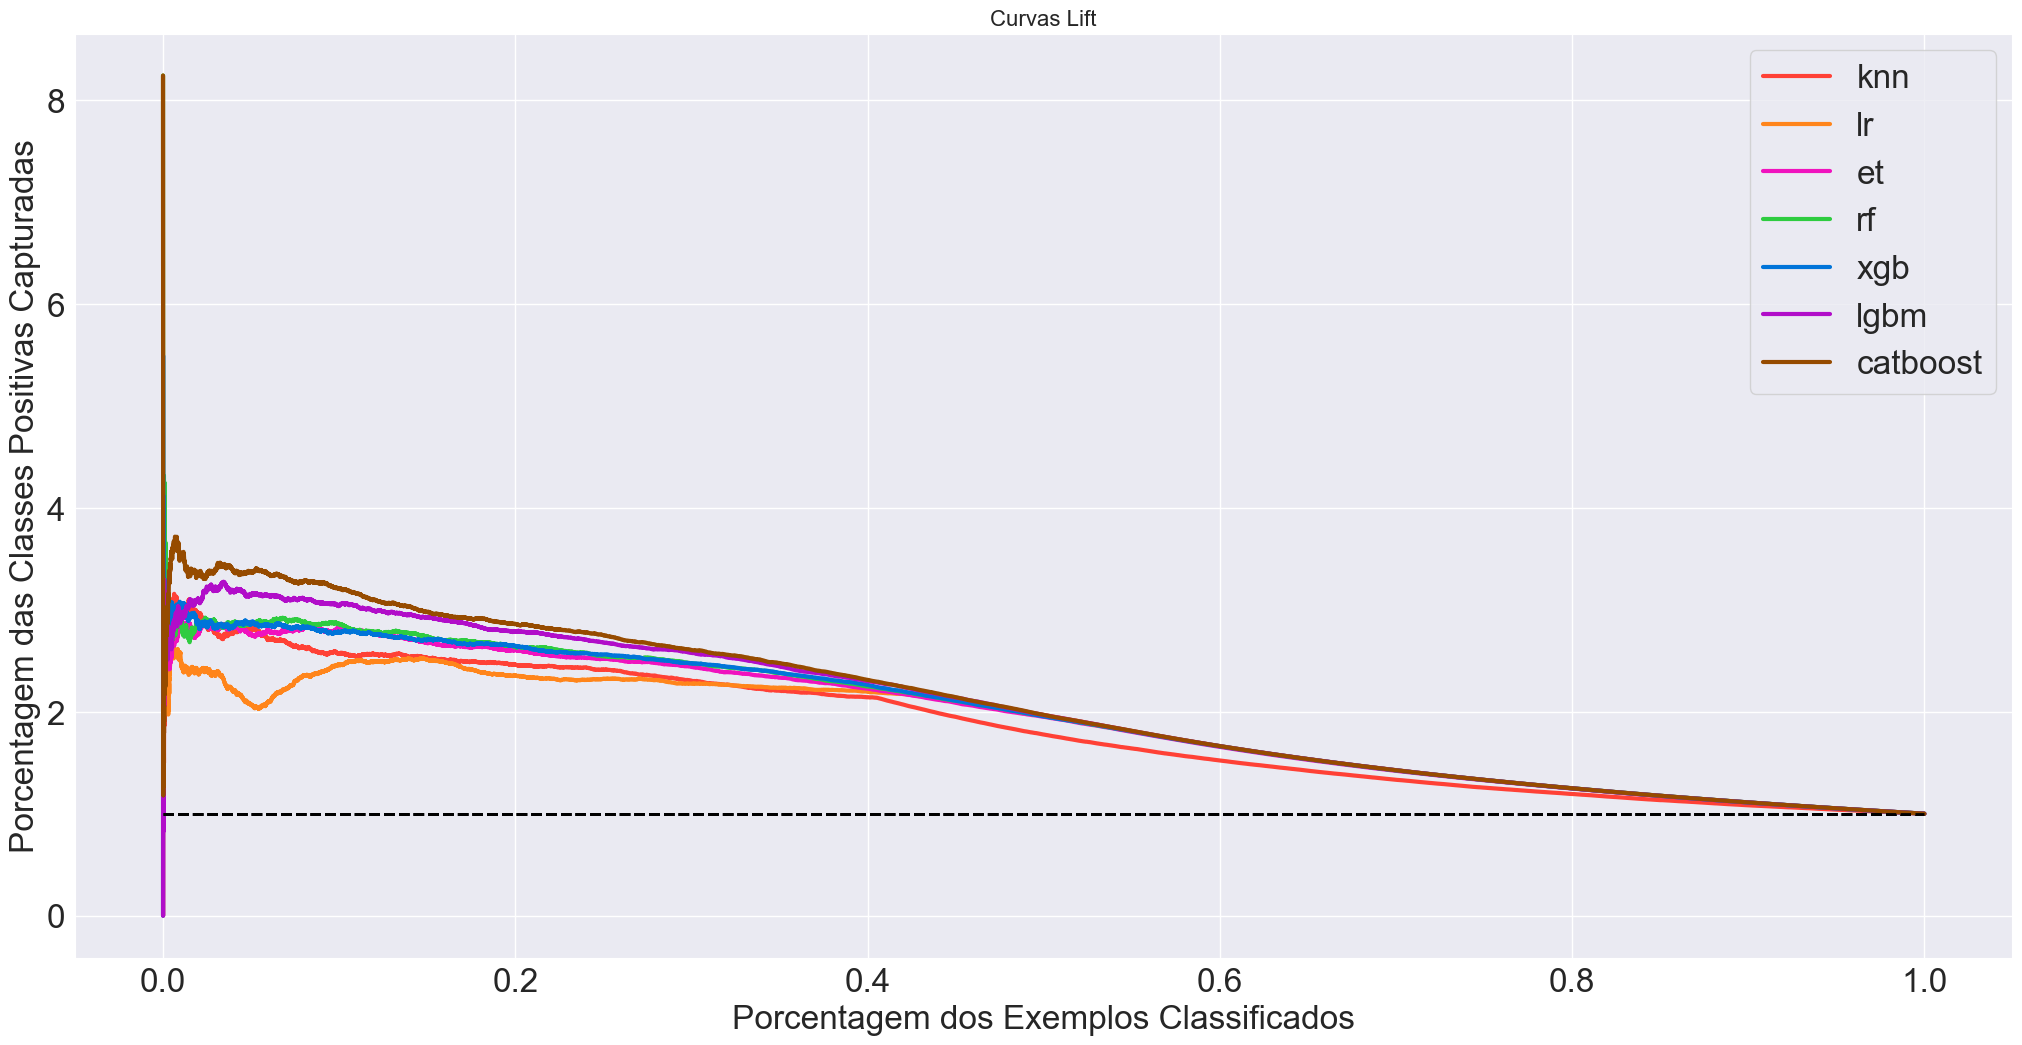

In [ ]:
# Define uma paleta de cores personalizada para os gráficos
colors = ['#FF4136', '#FF4136', '#FF851B', '#FF851B', '#F012BE', '#F012BE', '#2ECC40', '#2ECC40', '#0074D9',
          '#0074D9', '#B10DC9', '#B10DC9', '#964B00', '#964B00', '#FFDC00', '#FFDC00', '#AAAAAA', '#AAAAAA']
sns.set_palette(palette=colors)

# Lista de modelos e rótulos correspondentes
models = [yhat_knn, yhat_lr, yhat_et, yhat_rf, yhat_xgb, yhat_lgbm, yhat_cat]
model_labels = ['knn', 'lr', 'et', 'rf', 'xgb', 'lgbm', 'catboost']

# Cria uma figura e eixos
fig, ax = plt.subplots()

# Plota as curvas de lift para cada modelo
for i in range(len(models)):
    ax = skplt.metrics.plot_lift_curve(y_val, models[i], ax=ax)
    art.remove(ax.lines[i*2])  # Remove as linhas duplicadas do gráfico

# Adiciona a legenda ao gráfico
ax.legend([ax.lines[i*2] for i in range(len(models))], model_labels)

# Configurações adicionais do gráfico
plt.title('Curvas Lift')
plt.xlabel('Porcentagem dos Exemplos Classificados')
plt.ylabel('Porcentagem das Classes Positivas Capturadas')
plt.grid(True)

plt.show()


### 7.8.2. Cross Validation

In [ ]:
models = [knn_model, lr_model, et_model, rf_model, xgb_model, lgbm_model, cat_model]


In [ ]:
# Realiza a validação cruzada para os modelos e armazena os resultados
cv_results = perform_cross_validation(models, x_train, y_train)

# Cria um DataFrame com os resultados da validação cruzada
df_cv_results = pd.DataFrame(cv_results)

df_cv_results

c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\

Model  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-Score Mean  F1-Score Std
0    KNeighborsClassifier        0.304159       0.014907     0.106171    0.007559       0.157345      0.009930
1      LogisticRegression        0.000000       0.000000     0.000000    0.000000       0.000000      0.000000
2    ExtraTreesClassifier        0.297280       0.010550     0.099877    0.004714       0.149514      0.006591
3  RandomForestClassifier        0.310953       0.015454     0.074459    0.004007       0.120136      0.006257
4           XGBClassifier        0.316898       0.011130     0.123989    0.005970       0.178217      0.007742
5          LGBMClassifier        0.329250       0.031565     0.045362    0.003581       0.079717      0.006332
6      CatBoostClassifier        0.362171       0.015673     0.011524    0.002122       0.022322      0.003989

# 8.0. Hyperparameter Finetuning

## 8.1. Bayesian Search CV

In [ ]:
# Define os hiperparâmetros a serem otimizados
param_space = {
    'learning_rate': (0.01, 0.1),
    'depth': (3, 10),
    'iterations': (100, 1000),
    'l2_leaf_reg': (1, 10),
    'random_strength': (0.1, 1)
}

# Cria um modelo CatBoostClassifier
model_cat = CatBoostClassifier(eval_metric='F1', random_state=42, verbose=False)

# Define a estratégia de validação cruzada
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cria o objeto BayesSearchCV com o modelo, espaço de parâmetros e estratégia de validação cruzada
bayes_cv = BayesSearchCV(
    model_cat,
    param_space,
    n_iter=10,  # Número de iterações de busca
    cv=cv,
    scoring='f1_macro',  # Métrica de avaliação
    random_state=42,
    n_jobs=-1
)

# Realiza a busca dos melhores hiperparâmetros usando o Bayesian Search
bayes_cv.fit(x_train, y_train)

# Obtém os resultados do Bayesian Search
results = pd.DataFrame(bayes_cv.cv_results_)

# Imprime os melhores hiperparâmetros e a pontuação alcançada
print("Melhores Hiperparâmetros:")
print(bayes_cv.best_params_)
print("\nMelhor Pontuação:")
print(bayes_cv.best_score_)

Melhores Hiperparâmetros:
OrderedDict([('depth', 9), ('iterations', 895), ('l2_leaf_reg', 4), ('learning_rate', 0.09561015159339965), ('random_strength', 0.8777151239184556)])

Melhor Pontuação:
0.5035328699557163


## 8.2. Random Search

In [ ]:
# Definir os parâmetros a serem pesquisados
param_grid = {
    'depth': randint(1, 10),  # Profundidade máxima da árvore
    'learning_rate': uniform(0.01, 0.1),  # Taxa de aprendizado
    'iterations': randint(100, 1000),  # Número de iterações
    'l2_leaf_reg': uniform(1, 10),  # Regularização L2
    'random_strength': uniform(0, 1)  # Força de aleatoriedade
}

# Criar o modelo CatBoostClassifier
cat_model = CatBoostClassifier()

# Realizar a Random Search
random_search = ms.RandomizedSearchCV(
    cat_model, param_distributions=param_grid, n_iter=10, scoring='f1_macro', cv=5, random_state=42
)

# Treinar o modelo com a Random Search
random_search.fit(x_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(random_search.best_params_)

# Melhor pontuação obtida
print("Melhor Pontuação:")
print(random_search.best_score_)

0:	learn: 0.5588479	total: 22.4ms	remaining: 11.9s
1:	learn: 0.4670127	total: 45.2ms	remaining: 12s
2:	learn: 0.4085485	total: 67.8ms	remaining: 12s
3:	learn: 0.3711287	total: 98.2ms	remaining: 13s
4:	learn: 0.3449325	total: 119ms	remaining: 12.6s
5:	learn: 0.3276339	total: 141ms	remaining: 12.4s
6:	learn: 0.3147029	total: 161ms	remaining: 12.2s
7:	learn: 0.3051968	total: 183ms	remaining: 12.1s
8:	learn: 0.2978491	total: 204ms	remaining: 11.9s
9:	learn: 0.2928128	total: 221ms	remaining: 11.6s
10:	learn: 0.2884684	total: 241ms	remaining: 11.5s
11:	learn: 0.2851804	total: 265ms	remaining: 11.5s
12:	learn: 0.2824029	total: 287ms	remaining: 11.5s
13:	learn: 0.2802416	total: 308ms	remaining: 11.5s
14:	learn: 0.2785560	total: 329ms	remaining: 11.4s
15:	learn: 0.2771098	total: 350ms	remaining: 11.3s
16:	learn: 0.2759185	total: 372ms	remaining: 11.3s
17:	learn: 0.2749013	total: 393ms	remaining: 11.3s
18:	learn: 0.2739904	total: 416ms	remaining: 11.3s
19:	learn: 0.2733308	total: 439ms	remaining

## 8.3. Final Model

### 8.3.1 Bayseian Search

In [ ]:
# Definição dos melhores hiperparâmetros encontrados
best_params_bs = {
    'depth': 9,
    'iterations': 895,
    'l2_leaf_reg': 4,
    'learning_rate': 0.09561015159339965,
    'random_strength': 0.8777151239184556
}

In [ ]:
# Criação do modelo CatBoost com os melhores hiperparâmetros
cat_model_tuned_bs = CatBoostClassifier(
    depth = best_params_bs['depth'],
    iterations = best_params_bs['iterations'],
    l2_leaf_reg = best_params_bs['l2_leaf_reg'],
    learning_rate = best_params_bs['learning_rate'],
    random_strength = best_params_bs['random_strength']
)

# Treinamento do modelo com os dados de treinamento completos
cat_model_tuned_bs.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_cat_tuned_bs = cat_model_tuned_bs.predict_proba(x_val)

0:	learn: 0.5484619	total: 74.1ms	remaining: 1m 6s
1:	learn: 0.4572046	total: 135ms	remaining: 1m
2:	learn: 0.4002794	total: 153ms	remaining: 45.6s
3:	learn: 0.3632777	total: 169ms	remaining: 37.7s
4:	learn: 0.3392982	total: 186ms	remaining: 33.1s
5:	learn: 0.3243258	total: 202ms	remaining: 30s
6:	learn: 0.3132347	total: 220ms	remaining: 27.9s
7:	learn: 0.3049638	total: 243ms	remaining: 26.9s
8:	learn: 0.2989581	total: 270ms	remaining: 26.5s
9:	learn: 0.2952114	total: 281ms	remaining: 24.9s
10:	learn: 0.2920985	total: 295ms	remaining: 23.7s
11:	learn: 0.2899194	total: 308ms	remaining: 22.7s
12:	learn: 0.2873230	total: 338ms	remaining: 22.9s
13:	learn: 0.2855427	total: 353ms	remaining: 22.2s
14:	learn: 0.2838303	total: 388ms	remaining: 22.8s
15:	learn: 0.2825266	total: 414ms	remaining: 22.7s
16:	learn: 0.2814334	total: 451ms	remaining: 23.3s
17:	learn: 0.2807192	total: 467ms	remaining: 22.7s
18:	learn: 0.2803225	total: 476ms	remaining: 22s
19:	learn: 0.2799152	total: 491ms	remaining: 21

### 8.3.2. Random Search

In [ ]:
# Definição dos melhores hiperparâmetros encontrados
best_params_rs = {
    'depth': 7,
    'iterations': 535,
    'l2_leaf_reg': 10.50714306409916,
    'learning_rate': 0.0831993941811405,
    'random_strength': 0.5986584841970366
}

In [ ]:
# Criação do modelo CatBoost com os melhores hiperparâmetros
cat_model_tuned_rs = CatBoostClassifier(
    depth = best_params_rs['depth'],
    iterations = best_params_rs['iterations'],
    l2_leaf_reg = best_params_rs['l2_leaf_reg'],
    learning_rate = best_params_rs['learning_rate'],
    random_strength = best_params_rs['random_strength']
)

# Treinamento do modelo com os dados de treinamento completos
cat_model_tuned_rs.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_cat_tuned_rs = cat_model_tuned_rs.predict_proba(x_val)

0:	learn: 0.5683797	total: 20.9ms	remaining: 11.1s
1:	learn: 0.4831201	total: 40.8ms	remaining: 10.9s
2:	learn: 0.4234923	total: 63ms	remaining: 11.2s
3:	learn: 0.3845415	total: 86ms	remaining: 11.4s
4:	learn: 0.3576777	total: 105ms	remaining: 11.1s
5:	learn: 0.3386138	total: 125ms	remaining: 11s
6:	learn: 0.3247924	total: 145ms	remaining: 10.9s
7:	learn: 0.3153344	total: 157ms	remaining: 10.3s
8:	learn: 0.3078319	total: 170ms	remaining: 9.96s
9:	learn: 0.3019018	total: 190ms	remaining: 9.99s
10:	learn: 0.2972076	total: 212ms	remaining: 10.1s
11:	learn: 0.2938495	total: 232ms	remaining: 10.1s
12:	learn: 0.2909054	total: 252ms	remaining: 10.1s
13:	learn: 0.2886198	total: 268ms	remaining: 9.96s
14:	learn: 0.2867056	total: 287ms	remaining: 9.94s
15:	learn: 0.2854863	total: 298ms	remaining: 9.65s
16:	learn: 0.2841153	total: 316ms	remaining: 9.63s
17:	learn: 0.2830725	total: 335ms	remaining: 9.63s
18:	learn: 0.2822236	total: 356ms	remaining: 9.67s
19:	learn: 0.2813257	total: 377ms	remaining

### 8.3.3. Best Model 

In [ ]:
models = [cat_model, cat_model_tuned_bs, cat_model_tuned_rs]

In [ ]:
# Calcula as métricas de desempenho para cada modelo após o finetuning
metrics_results_tuned = calculate_metrics(models, x_train, y_train, x_val, y_val)

metrics_results_tuned[1]['Model'] = 'CatBoost Bayseian Search'
metrics_results_tuned[2]['Model'] = 'CatBoost Random Search'

df_metrics_results_tuned = pd.DataFrame(metrics_results_tuned)
df_metrics_results_tuned



0:	learn: 0.5484619	total: 25.4ms	remaining: 22.7s
1:	learn: 0.4572046	total: 62.7ms	remaining: 28s
2:	learn: 0.4002794	total: 84ms	remaining: 25s
3:	learn: 0.3632777	total: 107ms	remaining: 23.8s
4:	learn: 0.3392982	total: 130ms	remaining: 23.1s
5:	learn: 0.3243258	total: 151ms	remaining: 22.4s
6:	learn: 0.3132347	total: 266ms	remaining: 33.7s
7:	learn: 0.3049638	total: 322ms	remaining: 35.6s
8:	learn: 0.2989581	total: 360ms	remaining: 35.5s
9:	learn: 0.2952114	total: 378ms	remaining: 33.4s
10:	learn: 0.2920985	total: 400ms	remaining: 32.1s
11:	learn: 0.2899194	total: 415ms	remaining: 30.5s
12:	learn: 0.2873230	total: 448ms	remaining: 30.4s
13:	learn: 0.2855427	total: 469ms	remaining: 29.5s
14:	learn: 0.2838303	total: 512ms	remaining: 30s
15:	learn: 0.2825266	total: 549ms	remaining: 30.2s
16:	learn: 0.2814334	total: 595ms	remaining: 30.7s
17:	learn: 0.2807192	total: 624ms	remaining: 30.4s
18:	learn: 0.2803225	total: 640ms	remaining: 29.5s
19:	learn: 0.2799152	total: 657ms	remaining: 2

Model  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-Score Mean  F1-Score Std
0        CatBoostClassifier        0.438095            0.0     0.014979         0.0       0.014979           0.0
1  CatBoost Bayseian Search        0.386441            0.0     0.037121         0.0       0.037121           0.0
2    CatBoost Random Search        0.412698            0.0     0.008466         0.0       0.008466           0.0

# 8.0. Performance Metrics

No cenário em que você deseja oferecer um seguro de carro para clientes que já possuem seguro saúde, o objetivo principal é identificar os clientes com maior probabilidade de compra e colocá-los no topo do ranking. Para essa tarefa, é recomendado dar prioridade à métrica de Recall.

O Recall é a proporção de clientes interessados em adquirir o seguro de carro que são corretamente identificados pelo modelo. Nesse caso, é fundamental minimizar os falsos negativos, ou seja, evitar classificar erroneamente clientes que têm alta probabilidade de compra como não interessados. Um alto Recall garante que a maioria dos clientes realmente interessados seja priorizada no ranking, maximizando as chances de sucesso nas abordagens de marketing.





In [ ]:
# Copia o dataframe da amostra de validação
df8 = x_validation.copy()

# Cria uma nova coluna no dataframe para a variável resposta (y_validation)
df8['response'] = y_validation.copy()

# Calcula o score de propensão utilizando o modelo treinado (yhat_cat_tuned_bs)
df8['score'] = yhat_cat_tuned_bs[:, 1].tolist()

# Ordena os clientes pela pontuação de propensão, em ordem decrescente
df8 = df8.sort_values('score', ascending=False)

# Calcula a precisão para os 20 primeiros clientes
precision_at_20 = precision_at_20, data=precision_at_k(df8, k=20)

# Calcula o recall para os 15 primeiros clientes
recall_at_15 = recall_at_15, data=recall_at_k(df8, k=15)

# Cria um DataFrame com os valores de precision_at_20 e recall_at_15
df_metrics = pd.DataFrame({'Metric': ['precision_at_20', 'recall_at_15'],
                           'Value': [precision_at_20, recall_at_15]})

df_metrics

Metric     Value
0  precision_at_20  0.333333
1     recall_at_15  0.001628

In [ ]:

# Exemplo de uso da função top_k_accuracy_score
# Define os valores verdadeiros e as probabilidades preditas para cada classe
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 está no top 2
                    [0.3, 0.4, 0.2],  # 1 está no top 2
                    [0.2, 0.4, 0.3],  # 2 está no top 2
                    [0.7, 0.2, 0.1]]) # 2 não está no top 2

# Calcula a acurácia nos top k valores, neste caso top 2
top_k_accuracy = mt.top_k_accuracy_score(y_true, y_score, k=2)

# Imprime a acurácia
print("Top-2 Accuracy:", top_k_accuracy)

Top-2 Accuracy: 0.75


In [ ]:
# Definição dos valores verdadeiros (rótulos reais)
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0])

# Definição dos valores de pontuação (predições de probabilidade)
y_score = np.array([])

## 8.1. Cummulative Curve Manually

<AxesSubplot: xlabel='base_cum_perc', ylabel='baseline'>

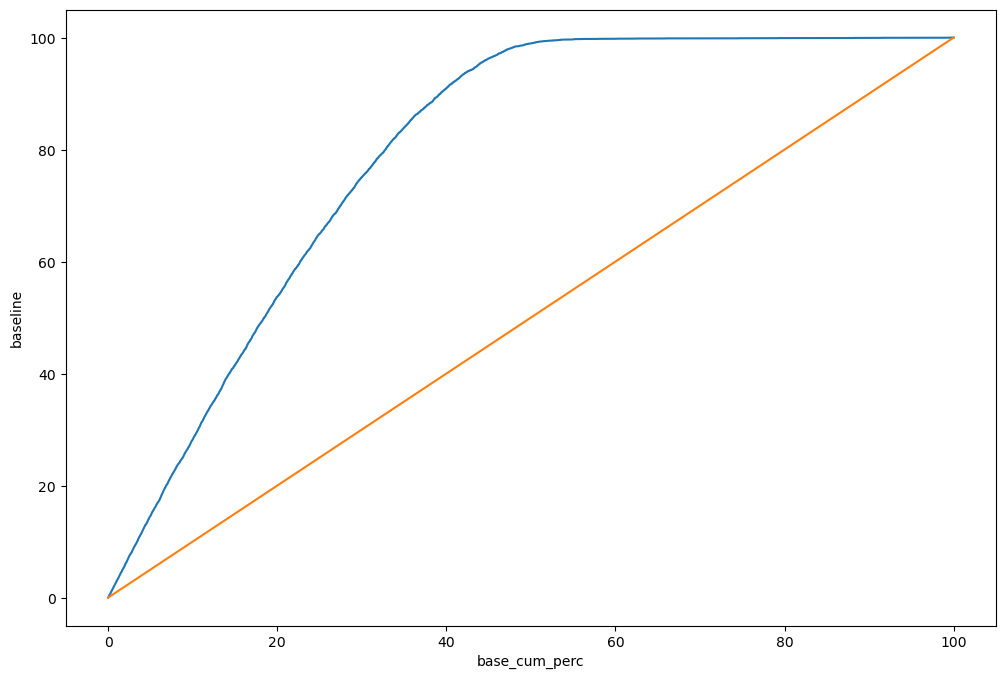

In [ ]:
# Cria um dataframe com as colunas de 'predição' e 'real'
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordena por ordem decrescente de acordo com a predição
results = results.sort_values('prediction', ascending=False)

# Calcula a porcentagem acumulada de clientes que realmente compraram (interesse - Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Calcula a porcentagem acumulada de clientes (base)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# Cria uma coluna de referência (baseline)
results['baseline'] = results['base_cum_perc']

# Plota o gráfico com as linhas de porcentagem acumulada de interesse e baseline
plt.figure(figsize=(12,8))
sns.lineplot(x='base_cum_perc', y='real_cum_perc', data=results)
sns.lineplot(x='base_cum_perc', y='baseline', data=results)


## 8.2. Lift Curve Manually

<AxesSubplot: xlabel='base_cum_perc', ylabel='lift'>

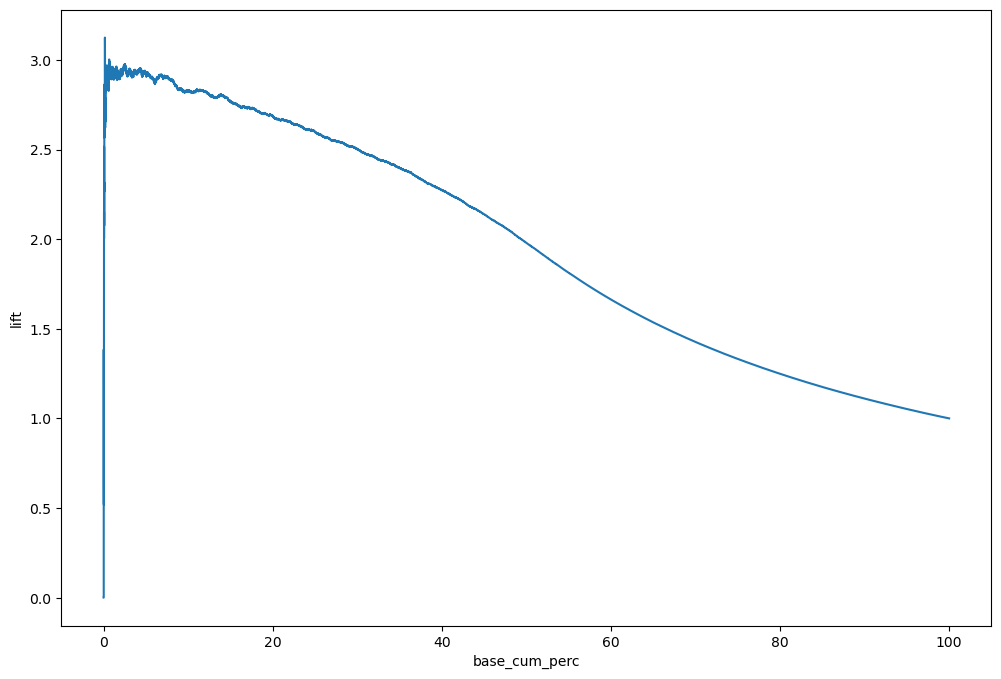

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordenando por previsão
results = results.sort_values('prediction', ascending=False)

# porcentagem de interesse (score de propensão)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum'] / results['real'].sum()

# porcentagem da base (clientes)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base'] / len(results)

# modelo baseline
results['baseline'] = results['base_cum_perc']

# cálculo do lift
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure(figsize=(12,8))
sns.lineplot(x='base_cum_perc', y='lift', data=results)


## 8.3. ROI Curve Manually

<AxesSubplot: xlabel='base_cum_perc', ylabel='lift'>

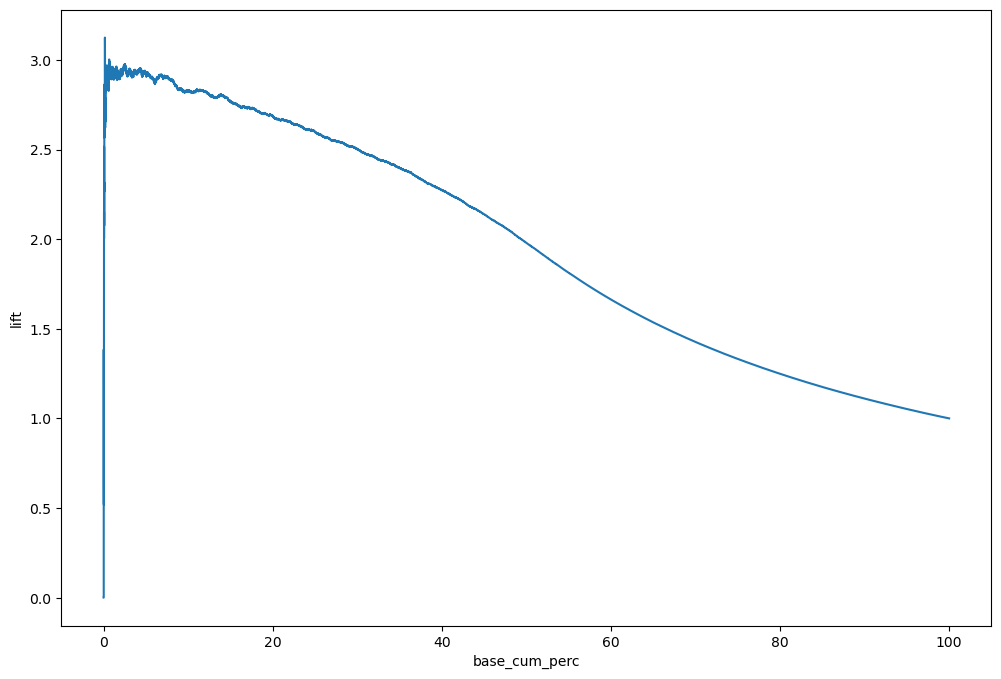

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending=False)

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum'] / results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base'] / len(results)

# Baseline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve
plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )


In [ ]:
# Compute bucket based on prediction values
# O código abaixo cria uma nova coluna chamada "bucket" na tabela "results", 
# que classifica os clientes em diferentes intervalos de propensão de acordo com 
# suas pontuações de predição.
results['bucket'] = results['prediction'].apply(
    lambda x: 0.9 if x >= 0.90 else 
              0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
              0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
              0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
              0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
              0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
              0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
              0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
              0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 
)

# agrupa os clientes por "bucket" e computa a contagem de clientes em cada intervalo de propensão, bem como a pontuação mínima de predição em cada intervalo
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Calcula a receita bruta e o custo em cada intervalo de propensão
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

# Computa o percentual acumulado de clientes e a receita acumulada em cada intervalo de propensão
df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()
df['revenue'] = df['gross_revenue'] - df['cost']

# ordena os resultados por índice de intervalo de propensão em ordem decrescente
df = df.sort_values('index', ascending=False)
df


index  clients  propensity_score  gross_revenue   cost      base    revenue
9   0.90    0.901                45         1621.8  3.604  1.000000   1618.196
8   0.80    0.800               132         4224.0  3.200  0.799822   4220.800
7   0.70    0.700               338         9464.0  2.800  0.622084   9461.200
6   0.60    0.600               782        18768.0  2.400  0.466563  18765.600
5   0.50    0.500              1660        33200.0  2.000  0.333259  33198.000
4   0.40    0.400              2994        47904.0  1.600  0.222173  47902.400
3   0.30    0.300              4654        55848.0  1.200  0.133304  55846.800
2   0.20    0.200              6150        49200.0  0.800  0.066652  49199.200
1   0.10    0.100              6723        26892.0  0.400  0.022217  26891.600
0   0.01    0.000             39612            0.0  0.000  0.000000      0.000

<AxesSubplot: xlabel='base', ylabel='revenue'>

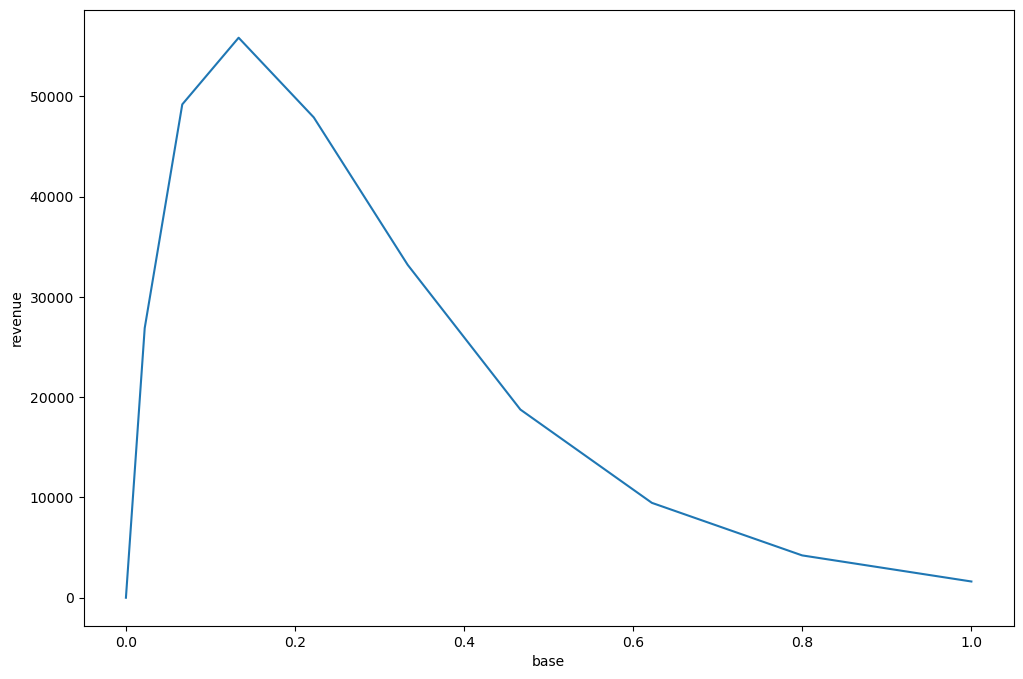

In [ ]:
plt.figure(figsize=(12,8))

# Seleciona apenas os dados com propensity_score maior ou igual a 0.1
aux = df[df['propensity_score'] >= 0.1]

# Criação do gráfico de linha
sns.lineplot(x='base', y='revenue', data=aux)


# bussness performance 

Valor de negócio: Analise o impacto do modelo nos resultados do negócio. Por exemplo, se o modelo for usado para prever a probabilidade de compra de um seguro de carro, você pode calcular o valor monetário das previsões corretas em comparação com as previsões incorretas ou aleatórias. Isso ajudará a quantificar o valor que o modelo está trazendo para o negócio.

# 9.0. Deploy to Production

In [ ]:
# Salva o modelo treinado
#pickle.dump(et, open('C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\src\\models\\model_health_insurance.pkl', 'wb'))
pickle.dump(lr_model, open(r'C:\Users\raquel\Documents\Comunidade DS\repos\06-PA-Health-Insurance-Cross-Sell\health_insurance\health_insurance_ross_sell\src\models\model_linear_regression.pkl', 'wb'))

## 9.1. Health Insurance Class

In [ ]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):
        # Definindo o caminho dos arquivos do projeto
        self.home_path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
        
        # Carregando os objetos scaler gerados no treinamento do modelo
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'src\\features\\annual_premium_scaler.pkl', 'rb'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'src\\features\\age_scaler.pkl', 'rb')) 
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'src\\features\\vintage_scaler.pkl', 'rb')) 
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + 'src\\features\\target_encode_gender_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src\\features\\target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + 'src\\features\\fe_policy_sales_channel_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        # 1.1. Renomeando as colunas
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering(self, df2):
        # 2.0. Feature Engineering

        # Criando a coluna 'vehicle_damage_num' para representar os veículos que já foram danificados (1) e os que não foram danificados (0)
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # Transformando a coluna 'vehicle_age' em uma coluna categórica para aplicação de técnicas de codificação
        df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        
        return df2
    
    
    def data_preparation(self, df5):
        # Aplicando a transformação de Escalonamento Padrão na coluna 'annual_premium'
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'age'
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'vintage'
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # Codificando a coluna 'gender' utilizando a técnica de Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # Aplica o processo de target encoding na coluna region_code
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler)

        # Cria variáveis dummy para a coluna vehicle_age usando a função pd.get_dummies
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # Aplica o processo de frequency encoding na coluna policy_sales_channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        # Feature Selection
        # Seleciona as colunas relevantes para o modelo
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        # Retorna o dataframe com as colunas selecionadas
        return df5[cols_selected]


    def get_prediction(self, model, original_data, test_data):
        # model prediction
        # Usa o modelo treinado para fazer as predições em test_data
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        # Adiciona as predições ao dataframe original
        original_data['score'] = pred
        
        # Retorna o dataframe em formato JSON
        return original_data.to_json(orient='records', date_format='iso')



## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from HealthInsurance import HealthInsurance

# carregando o modelo
path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
model = pickle.load(open(path + 'src/models/model_health_insurance.pkl', 'rb'))

# inicializando a API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # se houver dados
        if isinstance(test_json, dict): # único exemplo
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instanciando a classe HealthInsurance
        pipeline = HealthInsurance()

        # Limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)

        # Engenharia de Recursos
        df2 = pipeline.feature_engineering(df1)

        # Preparação dos dados
        df3 = pipeline.data_preparation(df2)

        # Previsão
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)


ModuleNotFoundError: No module named 'HealthInsurance'

## 9.3. API Tester

In [ ]:
import requests
import json

In [ ]:
 # loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [ ]:
df_test = df_test.sample(10)

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:

data = '[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.0, "vintage": 279}]'
data


'[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.0, "vintage": 279}]'

In [ ]:
# API Call
#url = 'http://localhost:5000/predict'
url = 'https://health-insurance-api-amhg.onrender.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

id    gender       age  driving_license  region_code  \
1  363080  0.138931  0.369231                1     0.187281   
0   74147  0.099967  0.092308                1     0.187281   

   previously_insured   vehicle_age  vehicle_damage  annual_premium  \
1                   0  below_1_year               0        0.489949   
0                   0  below_1_year               0        0.666594   

   policy_sales_channel   vintage     score  
1                  23.0  0.930796  0.051597  
0                 124.0  0.961938  0.045066